# **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from tqdm.notebook import tqdm

import torchinfo
import optuna

import nndl.models.CNN as cnn
import nndl.models.CNNLSTM as cnnlstm
import nndl.utils as utils
import time

# **Load Data From LocalHost**

In [2]:
X_test = np.load("./project_data/X_test.npy")
y_test = np.load("./project_data/y_test.npy") - 769
person_train_valid = np.load("./project_data/person_train_valid.npy")
X_train_valid = np.load("./project_data/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("./project_data/y_train_valid.npy") - 769
person_test = np.load("./project_data/person_test.npy")

print(X_train_valid.shape)
print(X_test.shape)

print(y_train_valid)

(2115, 22, 1000)
(2115, 22, 1000)
(443, 22, 1000)
[2 3 0 ... 3 3 2]


# **Device Setup**

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
elif torch.backends.mps.is_available():
  device = torch.device('mps')
else:
  device = torch.device('cpu')

print("Using", device)

Using cuda


# **Data Prep**

In [4]:
def data_prep(X,y,sub_sample,average,noise,channel_dropout,time_reverse):

    total_X = None
    total_y = None
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    X_average = torch.mean(X.view(X.size(0), X.size(1), -1, average), axis=3)
    X_average = X_average + torch.normal(0.0, 0.5, X_average.shape)

    total_X = torch.cat((total_X, X_average), dim=0)
    total_y = torch.cat((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (torch.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = torch.cat((total_X, X_subsample), dim=0)
        print(total_y.view(-1,1).shape)
        print(y.view(-1,1).shape)
        total_y = torch.cat((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)

    if channel_dropout != 0:
        mask = (torch.rand(total_X.shape[0], total_X.shape[1]) >= channel_dropout).unsqueeze(2)
        X_dropout = mask * total_X
        total_X = torch.cat((total_X, X_dropout))
        total_y = torch.cat((total_y, total_y))

        print(f'Shape of X after channel dropout {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')

    if time_reverse != 0:
        mask = (torch.rand(total_X.shape[0]) >= time_reverse)
        X_reverse = torch.flip((total_X[mask]), [2])
        total_X = torch.cat((total_X, X_reverse))
        total_y = torch.cat((total_y, total_y[mask]))

        print(f'Shape of X after reverse {total_X.shape}')
        print(f'Shape of Y: {total_y.shape}')


    return total_X,total_y
    return total_X,total_y


def test_data_prep(X):

    total_X = None

    X = X[:,:,0:800]
    print('Shape of X after trimming:', X.shape)
    X_max, _ = torch.max(X.view(X.size(0), X.size(1), -1, 2), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

In [5]:
input_size = 22
hidden_size = 256
num_layers = 10
num_classes = 4
learning_rate = 0.001
batch_size = 200
num_epochs = 100
dropout = 0.3

folds = 10
split_seed = 1
subsample = 2
average = 2
channel_dropout = 0.2
time_reverse = 0.3
noise = True

X_train_valid = torch.Tensor(X_train_valid)
y_train_valid = torch.Tensor(y_train_valid)

print(f'SOME {X_train_valid.shape}')
indices = torch.randperm(X_train_valid.shape[0])
split_idx = int(X_train_valid.shape[0] * ((folds-1)/folds))
X_train, X_valid = X_train_valid[indices[:split_idx]], X_train_valid[indices[split_idx:]]
y_train, y_valid = y_train_valid[indices[:split_idx]], y_train_valid[indices[split_idx:]]
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

print('Prepping Training Data')
X_train, y_train = data_prep(X_train, y_train, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Validation Data')
X_valid, y_valid = data_prep(X_valid, y_valid, subsample, average, noise, channel_dropout, time_reverse)
print('\nPrepping Test Data')
X_test = test_data_prep(X_test)
print('\nFINISHED PREP\n')

print('Final shape of training set:', X_train.shape)
print('Final shape of validation set:', X_valid.shape)
print('Final shape of test set:', X_test.shape)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)

print(f'TRAIN_DATA {len(train_loader)}\nVALID_DATA {len(val_loader)}\nTEST_DATA {len(test_loader)}')

SOME torch.Size([2115, 22, 1000])
Prepping Training Data
Shape of X after trimming: torch.Size([1903, 22, 800])
Shape of X after maxpooling: torch.Size([1903, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([3806, 22, 400])
torch.Size([3806, 1])
torch.Size([1903, 1])
torch.Size([5709, 1])
torch.Size([1903, 1])
Shape of X after subsampling and concatenating: torch.Size([7612, 22, 400])
Shape of Y: torch.Size([7612])
Shape of X after channel dropout torch.Size([15224, 22, 400])
Shape of Y: torch.Size([15224])
Shape of X after reverse torch.Size([25945, 22, 400])
Shape of Y: torch.Size([25945])

Prepping Validation Data
Shape of X after trimming: torch.Size([212, 22, 800])
Shape of X after maxpooling: torch.Size([212, 22, 400])
Shape of X after averaging+noise and concatenating: torch.Size([424, 22, 400])
torch.Size([424, 1])
torch.Size([212, 1])
torch.Size([636, 1])
torch.Size([212, 1])
Shape of X after subsampling and concatenating: torch.Size([848, 22, 400])
Sh

# **CNN**

## Find Hyperparameters

In [6]:
# time to measure exactly how much of my life i won't get back
start_time = time.time()
params = utils.learn_hyperparameters(X_train=X_train, 
                                     y_train=y_train, 
                                     X_valid=X_valid, 
                                     y_valid=y_valid, 
                                     model_name='CNN', 
                                     num_epochs=10, 
                                     trials=20)
optim_end = time.time()

[I 2024-03-11 03:54:27,365] A new study created in memory with name: no-name-22948ab1-0c74-4d7b-81f3-48232ab51ccf


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          Adam
        Learning Rate:                  0.0006006486842841649
        Weight Decay:                   0.0014679778448083965
    Model:                              CNN
        Dropout:                        0.5373595997317382
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               4
        Depth:                          50
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.343, Val acc: 0.413, Val loss: 1.711
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.467, Val acc: 0.426, Val loss: 2.007
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.523, Val acc: 0.484, Val loss: 2.063
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.556, Val acc: 0.467, Val loss: 2.069
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.585, Val acc: 0.490, Val loss: 2.404
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.601, Val acc: 0.521, Val loss: 2.027
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.615, Val acc: 0.518, Val loss: 1.991
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.633, Val acc: 0.494, Val loss: 2.987
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.643, Val acc: 0.543, Val loss: 2.099
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 03:55:26,362] Trial 0 finished with value: 0.5428076386451721 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0006006486842841649, 'weight_decay': 0.0014679778448083965, 'momentum': 0.9148014430699385, 'dropout': 0.5373595997317382, 'kernel1': 6, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 5, 'pool_kernel': 4, 'depth': 50, 'scale': 2, 'hidden_dims': 32}. Best is trial 0 with value: 0.5428076386451721.


Train acc: 0.653, Val acc: 0.542, Val loss: 2.104
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          Adamax
        Learning Rate:                  0.008179147842558274
        Weight Decay:                   1.5213353211965212e-05
    Model:                              CNN
        Dropout:                        0.7040660620266157
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               2
        Depth:                          200
        Scale:                          3
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.332, Val acc: 0.357, Val loss: 2.938
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.391, Val acc: 0.407, Val loss: 1.586
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.460, Val acc: 0.479, Val loss: 1.263
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.511, Val acc: 0.480, Val loss: 1.281
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.540, Val acc: 0.424, Val loss: 1.352
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.556, Val acc: 0.505, Val loss: 1.296
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.583, Val acc: 0.521, Val loss: 1.264
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.594, Val acc: 0.504, Val loss: 1.314
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.612, Val acc: 0.488, Val loss: 1.289
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.634, Val acc: 0.506, Val loss: 1.365


[I 2024-03-11 04:04:48,055] Trial 1 finished with value: 0.5209705233573914 and parameters: {'batch_size': 128, 'optimizer_name': 'Adamax', 'learning_rate': 0.008179147842558274, 'weight_decay': 1.5213353211965212e-05, 'momentum': 0.8002965323031742, 'dropout': 0.7040660620266157, 'kernel1': 2, 'kernel2': '(1, 17)', 'kernel3': 6, 'kernel4': 6, 'pool_kernel': 2, 'depth': 200, 'scale': 3, 'hidden_dims': 16}. Best is trial 0 with value: 0.5428076386451721.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          SGD
        Learning Rate:                  0.0002102799145129896
        Weight Decay:                   4.53283707554532e-05
        Momentum:                       0.9108731572783045
    Model:                              CNN
        Dropout:                        0.4093961783866283
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               4
        Depth:                          200
        Scale:                          4
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.321, Val acc: 0.346, Val loss: 1.353
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.428, Val loss: 1.325
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.424, Val acc: 0.452, Val loss: 1.306
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.464, Val loss: 1.329
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.478, Val acc: 0.463, Val loss: 1.316
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.488, Val acc: 0.470, Val loss: 1.324
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.506, Val acc: 0.477, Val loss: 1.343
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.479, Val loss: 1.345
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.529, Val acc: 0.477, Val loss: 1.340
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-11 04:13:29,877] Trial 2 finished with value: 0.47868284583091736 and parameters: {'batch_size': 128, 'optimizer_name': 'SGD', 'learning_rate': 0.0002102799145129896, 'weight_decay': 4.53283707554532e-05, 'momentum': 0.9108731572783045, 'dropout': 0.4093961783866283, 'kernel1': 6, 'kernel2': '(1, 22)', 'kernel3': 2, 'kernel4': 5, 'pool_kernel': 4, 'depth': 200, 'scale': 4, 'hidden_dims': 16}. Best is trial 0 with value: 0.5428076386451721.


Train acc: 0.542, Val acc: 0.460, Val loss: 1.403
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          SGD
        Learning Rate:                  0.0001342977361133572
        Weight Decay:                   5.429121482469064e-05
        Momentum:                       0.9481391790187808
    Model:                              CNN
        Dropout:                        0.7396743845045504
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               5
        Depth:                          25
        Scale:                          3
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.250, Val acc: 0.216, Val loss: 1.406
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.224, Val loss: 1.411
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.214, Val loss: 1.406
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.261, Val acc: 0.218, Val loss: 1.401
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.267, Val acc: 0.214, Val loss: 1.401
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.275, Val acc: 0.215, Val loss: 1.397
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.276, Val acc: 0.212, Val loss: 1.396
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.274, Val acc: 0.212, Val loss: 1.396
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.278, Val acc: 0.212, Val loss: 1.395
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 04:13:55,620] Trial 3 finished with value: 0.22426342964172363 and parameters: {'batch_size': 256, 'optimizer_name': 'SGD', 'learning_rate': 0.0001342977361133572, 'weight_decay': 5.429121482469064e-05, 'momentum': 0.9481391790187808, 'dropout': 0.7396743845045504, 'kernel1': 6, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 2, 'pool_kernel': 5, 'depth': 25, 'scale': 3, 'hidden_dims': 256}. Best is trial 0 with value: 0.5428076386451721.


Train acc: 0.273, Val acc: 0.212, Val loss: 1.400
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          NAdam
        Learning Rate:                  0.00021239737885914793
        Weight Decay:                   0.0004873101657829257
    Model:                              CNN
        Dropout:                        0.6375948876518128
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               4
        Depth:                          25
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.220, Val loss: 1.557
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.308, Val acc: 0.229, Val loss: 1.511
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.348, Val acc: 0.289, Val loss: 1.466
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.372, Val acc: 0.338, Val loss: 1.427
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.394, Val acc: 0.364, Val loss: 1.447
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.364, Val loss: 1.470
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.432, Val acc: 0.415, Val loss: 1.614
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.456, Val acc: 0.444, Val loss: 1.650
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.476, Val acc: 0.443, Val loss: 1.629
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:14:52,285] Trial 4 finished with value: 0.4620450735092163 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.00021239737885914793, 'weight_decay': 0.0004873101657829257, 'momentum': 0.8559799751662089, 'dropout': 0.6375948876518128, 'kernel1': 5, 'kernel2': '(1, 22)', 'kernel3': 2, 'kernel4': 7, 'pool_kernel': 4, 'depth': 25, 'scale': 2, 'hidden_dims': 256}. Best is trial 0 with value: 0.5428076386451721.


Train acc: 0.491, Val acc: 0.462, Val loss: 1.775
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          Adamax
        Learning Rate:                  0.002207588693662573
        Weight Decay:                   0.0006041180673001572
    Model:                              CNN
        Dropout:                        0.5434988181843552
        (Block 1) Conv1d Kernel Size:   9
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          50
        Scale:                          3
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.369, Val acc: 0.411, Val loss: 2.225
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.468, Val acc: 0.437, Val loss: 3.140
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.523, Val acc: 0.463, Val loss: 3.300
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:15:38,133] Trial 5 pruned. 


Train acc: 0.574, Val acc: 0.433, Val loss: 3.952
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Optimizer:                          RMSprop
        Learning Rate:                  0.00043290636447357344
        Weight Decay:                   2.331011690368524e-05
        Momentum:                       0.9339331893622049
    Model:                              CNN
        Dropout:                        0.6432853227430393
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               2
        Depth:                          25
        Scale:                          4
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-11 04:15:45,821] Trial 6 pruned. 


Train acc: 0.285, Val acc: 0.304, Val loss: 1.449
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          NAdam
        Learning Rate:                  0.0020610163439257504
        Weight Decay:                   9.800535482146827e-06
    Model:                              CNN
        Dropout:                        0.6597519713104341
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               3
        Depth:                          200
        Scale:                          5
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.353, Val acc: 0.381, Val loss: 2.221
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.480, Val loss: 1.382
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.539, Val acc: 0.491, Val loss: 1.502
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.597, Val acc: 0.447, Val loss: 1.126
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.646, Val acc: 0.501, Val loss: 1.780
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.694, Val acc: 0.486, Val loss: 1.047
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.736, Val acc: 0.528, Val loss: 1.915
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.776, Val acc: 0.541, Val loss: 1.379
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.533, Val loss: 1.935
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:39:06,988] Trial 7 finished with value: 0.5410745143890381 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.0020610163439257504, 'weight_decay': 9.800535482146827e-06, 'momentum': 0.8649019774560072, 'dropout': 0.6597519713104341, 'kernel1': 10, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 5, 'pool_kernel': 3, 'depth': 200, 'scale': 5, 'hidden_dims': 256}. Best is trial 0 with value: 0.5428076386451721.


Train acc: 0.833, Val acc: 0.528, Val loss: 1.537
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          RMSprop
        Learning Rate:                  0.007306481961324409
        Weight Decay:                   6.266553570505303e-05
        Momentum:                       0.8301183382388381
    Model:                              CNN
        Dropout:                        0.4370191256096428
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               2
        Depth:                          200
        Scale:                          5
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:41:02,735] Trial 8 pruned. 


Train acc: 0.286, Val acc: 0.264, Val loss: 5.406
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          SGD
        Learning Rate:                  0.0011280141567251289
        Weight Decay:                   0.0007041756684291849
        Momentum:                       0.9602610652479766
    Model:                              CNN
        Dropout:                        0.6225868416935824
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               5
        Depth:                          200
        Scale:                          5
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:42:11,955] Trial 9 pruned. 


Train acc: 0.297, Val acc: 0.266, Val loss: 10.624
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.0008851007432006929
        Weight Decay:                   0.009821098399413456
    Model:                              CNN
        Dropout:                        0.5371763608710015
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               3
        Depth:                          50
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.355, Val acc: 0.373, Val loss: 1.354
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.441, Val loss: 1.365
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.517, Val acc: 0.507, Val loss: 1.266
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.559, Val acc: 0.472, Val loss: 1.315
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.587, Val acc: 0.503, Val loss: 1.314
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.607, Val acc: 0.516, Val loss: 1.300
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.620, Val acc: 0.521, Val loss: 1.310
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.628, Val acc: 0.521, Val loss: 1.258
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.641, Val acc: 0.537, Val loss: 1.339
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 04:42:57,578] Trial 10 finished with value: 0.5365684628486633 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.0008851007432006929, 'weight_decay': 0.009821098399413456, 'momentum': 0.8952664731097535, 'dropout': 0.5371763608710015, 'kernel1': 8, 'kernel2': '(1, 17)', 'kernel3': 4, 'kernel4': 3, 'pool_kernel': 3, 'depth': 50, 'scale': 2, 'hidden_dims': 32}. Best is trial 0 with value: 0.5428076386451721.


Train acc: 0.649, Val acc: 0.527, Val loss: 1.240
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          NAdam
        Learning Rate:                  0.0022884859866276765
        Weight Decay:                   3.556599782186388e-06
    Model:                              CNN
        Dropout:                        0.5238149708934852
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               3
        Depth:                          150
        Scale:                          5
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.373, Val acc: 0.383, Val loss: 1.973
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.524, Val acc: 0.486, Val loss: 2.210
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.642, Val acc: 0.497, Val loss: 0.725
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.739, Val acc: 0.507, Val loss: 1.821
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.521, Val loss: 2.725
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.503, Val loss: 2.336
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.885, Val acc: 0.504, Val loss: 3.231
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.908, Val acc: 0.493, Val loss: 2.872
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.915, Val acc: 0.519, Val loss: 2.701
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:55:22,785] Trial 11 finished with value: 0.5247833728790283 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.0022884859866276765, 'weight_decay': 3.556599782186388e-06, 'momentum': 0.8648146343970656, 'dropout': 0.5238149708934852, 'kernel1': 10, 'kernel2': '(1, 17)', 'kernel3': 4, 'kernel4': 4, 'pool_kernel': 3, 'depth': 150, 'scale': 5, 'hidden_dims': 64}. Best is trial 0 with value: 0.5428076386451721.


Train acc: 0.922, Val acc: 0.525, Val loss: 1.847
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          Adam
        Learning Rate:                  0.0027843211207600658
        Weight Decay:                   1.5054145156751363e-06
    Model:                              CNN
        Dropout:                        0.7921954423064799
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               4
        Depth:                          100
        Scale:                          4
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:55:53,435] Trial 12 pruned. 


Train acc: 0.303, Val acc: 0.274, Val loss: 61.518
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Optimizer:                          Adam
        Learning Rate:                  0.0006811732066708978
        Weight Decay:                   0.006729515508837828
    Model:                              CNN
        Dropout:                        0.48934775839024885
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          50
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.402, Val acc: 0.423, Val loss: 1.478
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.523, Val acc: 0.493, Val loss: 1.635
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.523, Val loss: 1.238
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.627, Val acc: 0.513, Val loss: 1.879
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.648, Val acc: 0.538, Val loss: 1.740
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.533, Val loss: 1.634
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.527, Val loss: 1.945
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.515, Val loss: 1.613
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.691, Val acc: 0.545, Val loss: 1.761
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 04:56:57,681] Trial 13 finished with value: 0.5445407032966614 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0006811732066708978, 'weight_decay': 0.006729515508837828, 'momentum': 0.9160520825198128, 'dropout': 0.48934775839024885, 'kernel1': 8, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 6, 'pool_kernel': 3, 'depth': 50, 'scale': 2, 'hidden_dims': 64}. Best is trial 13 with value: 0.5445407032966614.


Train acc: 0.693, Val acc: 0.501, Val loss: 1.754
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.0005621076933923415
        Weight Decay:                   0.009765820794855917
    Model:                              CNN
        Dropout:                        0.47851995866424263
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               4
        Depth:                          50
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.345, Val acc: 0.429, Val loss: 1.318
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.455, Val acc: 0.455, Val loss: 1.336
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.523, Val acc: 0.513, Val loss: 1.298
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.569, Val acc: 0.524, Val loss: 1.304
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.602, Val acc: 0.524, Val loss: 1.350
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.627, Val acc: 0.544, Val loss: 1.335
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.646, Val acc: 0.543, Val loss: 1.348
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.664, Val acc: 0.556, Val loss: 1.299
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.525, Val loss: 1.397
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 04:57:37,619] Trial 14 finished with value: 0.5556325912475586 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.0005621076933923415, 'weight_decay': 0.009765820794855917, 'momentum': 0.9209837838433682, 'dropout': 0.47851995866424263, 'kernel1': 8, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 7, 'pool_kernel': 4, 'depth': 50, 'scale': 2, 'hidden_dims': 64}. Best is trial 14 with value: 0.5556325912475586.


Train acc: 0.685, Val acc: 0.515, Val loss: 1.355
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.00037190815659329134
        Weight Decay:                   0.007790031344550377
    Model:                              CNN
        Dropout:                        0.46955498171788496
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               3
        Depth:                          50
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.352, Val acc: 0.424, Val loss: 1.325
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.442, Val loss: 1.356
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.515, Val acc: 0.497, Val loss: 1.275
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.555, Val acc: 0.516, Val loss: 1.288
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.512, Val loss: 1.408
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.614, Val acc: 0.497, Val loss: 1.417
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.639, Val acc: 0.522, Val loss: 1.378
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.659, Val acc: 0.524, Val loss: 1.391
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.516, Val loss: 1.383
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 04:58:23,107] Trial 15 finished with value: 0.5240901112556458 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.00037190815659329134, 'weight_decay': 0.007790031344550377, 'momentum': 0.9271701095239869, 'dropout': 0.46955498171788496, 'kernel1': 8, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 7, 'pool_kernel': 3, 'depth': 50, 'scale': 2, 'hidden_dims': 64}. Best is trial 14 with value: 0.5556325912475586.


Train acc: 0.696, Val acc: 0.506, Val loss: 1.438
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.0011845658235486293
        Weight Decay:                   0.0027875047202300367
    Model:                              CNN
        Dropout:                        0.4880696921278299
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               5
        Depth:                          50
        Scale:                          3
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.452, Val loss: 1.591
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.502, Val acc: 0.496, Val loss: 1.402
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.558, Val acc: 0.466, Val loss: 1.407
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.598, Val acc: 0.516, Val loss: 1.389
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.631, Val acc: 0.525, Val loss: 1.276
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.657, Val acc: 0.525, Val loss: 1.361
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.515, Val loss: 1.428
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.692, Val acc: 0.514, Val loss: 1.431
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.710, Val acc: 0.533, Val loss: 1.410
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 04:59:12,235] Trial 16 finished with value: 0.53310227394104 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.0011845658235486293, 'weight_decay': 0.0027875047202300367, 'momentum': 0.8902770858834146, 'dropout': 0.4880696921278299, 'kernel1': 7, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 7, 'pool_kernel': 5, 'depth': 50, 'scale': 3, 'hidden_dims': 64}. Best is trial 14 with value: 0.5556325912475586.


Train acc: 0.716, Val acc: 0.526, Val loss: 1.491
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.0003131352066843938
        Weight Decay:                   0.00020432446319866083
    Model:                              CNN
        Dropout:                        0.47427905418040506
        (Block 1) Conv1d Kernel Size:   9
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               4
        Depth:                          100
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.348, Val acc: 0.427, Val loss: 1.367
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.450, Val loss: 1.327
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.512, Val acc: 0.508, Val loss: 1.288
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.563, Val acc: 0.493, Val loss: 1.382
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.600, Val acc: 0.511, Val loss: 1.425
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.624, Val acc: 0.531, Val loss: 1.457
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.652, Val acc: 0.520, Val loss: 1.492
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.673, Val acc: 0.494, Val loss: 1.623
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.695, Val acc: 0.530, Val loss: 1.513
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 05:00:31,570] Trial 17 finished with value: 0.5306758880615234 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.0003131352066843938, 'weight_decay': 0.00020432446319866083, 'momentum': 0.989075602314854, 'dropout': 0.47427905418040506, 'kernel1': 9, 'kernel2': '(1, 17)', 'kernel3': 4, 'kernel4': 6, 'pool_kernel': 4, 'depth': 100, 'scale': 2, 'hidden_dims': 64}. Best is trial 14 with value: 0.5556325912475586.


Train acc: 0.721, Val acc: 0.516, Val loss: 1.520
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.0006729864179733101
        Weight Decay:                   0.003168833794827081
    Model:                              CNN
        Dropout:                        0.5843341225746561
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          150
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.378, Val acc: 0.440, Val loss: 1.458
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.509, Val acc: 0.471, Val loss: 1.423
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.571, Val acc: 0.504, Val loss: 1.393
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.616, Val acc: 0.516, Val loss: 1.391
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.651, Val acc: 0.514, Val loss: 1.338
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.684, Val acc: 0.534, Val loss: 1.462
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.713, Val acc: 0.555, Val loss: 1.530
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.736, Val acc: 0.552, Val loss: 1.372
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.760, Val acc: 0.548, Val loss: 1.416
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 05:03:10,755] Trial 18 finished with value: 0.5545927286148071 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.0006729864179733101, 'weight_decay': 0.003168833794827081, 'momentum': 0.9506637962958524, 'dropout': 0.5843341225746561, 'kernel1': 7, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 6, 'pool_kernel': 3, 'depth': 150, 'scale': 2, 'hidden_dims': 64}. Best is trial 14 with value: 0.5556325912475586.


Train acc: 0.779, Val acc: 0.522, Val loss: 1.529
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.00011270938713450995
        Weight Decay:                   0.002503331180647695
    Model:                              CNN
        Dropout:                        0.5900554195496444
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               4
        Depth:                          150
        Scale:                          3
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

[I 2024-03-11 05:03:35,506] Trial 19 pruned. 


Train acc: 0.311, Val acc: 0.334, Val loss: 1.431
Number of finished trials: 20
Best trial:
    Validation Accuracy: 0.5556325912475586
    Learned Hyperparameters
    ------------------------
    Batch Size:                         256
    Optimizer:                          Adam
        Learning Rate:                  0.0005621076933923415
        Weight Decay:                   0.009765820794855917
    Model:                              CNN
        Dropout:                        0.47851995866424263
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               4
        Depth:                          50
        Scale:                          2


## Model Summary

In [7]:
model = cnn.CNN(num_classes=4,
                dropout=params.get('dropout'),
                kernel1=params.get('kernel1'),
                kernel2=eval(params.get('kernel2')),
                kernel3=params.get('kernel3'),
                kernel4=params.get('kernel4'),
                pool_kernel=params.get('pool_kernel'),
                depth=params.get('depth'),
                scale=params.get('scale')).to(device)


torchinfo.summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [200, 4]                  --
├─Sequential: 1-1                        [200, 50, 393]            --
│    └─Conv1d: 2-1                       [200, 50, 393]            8,850
│    └─ReLU: 2-2                         [200, 50, 393]            --
│    └─BatchNorm1d: 2-3                  [200, 50, 393]            100
│    └─Dropout: 2-4                      [200, 50, 393]            --
├─Sequential: 1-2                        [200, 100, 1, 94]         --
│    └─Conv2d: 2-5                       [200, 100, 1, 377]        85,100
│    └─ELU: 2-6                          [200, 100, 1, 377]        --
│    └─BatchNorm2d: 2-7                  [200, 100, 1, 377]        200
│    └─MaxPool2d: 2-8                    [200, 100, 1, 94]         --
│    └─Dropout: 2-9                      [200, 100, 1, 94]         --
├─Sequential: 1-3                        [200, 200, 23]            --
│    └

## Training with Learned Hyperparameters

In [8]:
criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_accuracies, val_accuracies = utils.train_model(model, 
                                                     criterion, 
                                                     optimizer, 
                                                     scheduler, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader, 
                                                     num_epochs=100)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.350, Val acc: 0.421, Val loss: 1.275
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.469, Val acc: 0.436, Val loss: 1.276
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.536, Val acc: 0.466, Val loss: 1.090
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.582, Val acc: 0.499, Val loss: 1.168
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.606, Val acc: 0.507, Val loss: 1.365
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.637, Val acc: 0.509, Val loss: 1.227
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.651, Val acc: 0.529, Val loss: 0.997
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.668, Val acc: 0.526, Val loss: 1.146
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.672, Val acc: 0.557, Val loss: 1.065
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.686, Val acc: 0.560, Val loss: 1.064
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.693, Val acc: 0.556, Val loss: 0.929
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.699, Val acc: 0.549, Val loss: 1.545
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.706, Val acc: 0.569, Val loss: 1.227
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.706, Val acc: 0.549, Val loss: 0.993
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.706, Val acc: 0.542, Val loss: 1.159
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.708, Val acc: 0.556, Val loss: 1.033
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.710, Val acc: 0.541, Val loss: 1.069
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.714, Val acc: 0.543, Val loss: 1.135
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.715, Val acc: 0.556, Val loss: 1.081
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.719, Val acc: 0.527, Val loss: 1.108
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.727, Val acc: 0.532, Val loss: 1.246
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.726, Val acc: 0.513, Val loss: 1.195
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.765, Val acc: 0.548, Val loss: 1.176
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.770, Val acc: 0.563, Val loss: 1.453
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.778, Val acc: 0.561, Val loss: 1.045
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.782, Val acc: 0.555, Val loss: 0.924
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.789, Val acc: 0.549, Val loss: 1.222
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.792, Val acc: 0.550, Val loss: 1.161
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.794, Val acc: 0.562, Val loss: 1.119
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.796, Val acc: 0.551, Val loss: 1.023
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.800, Val acc: 0.550, Val loss: 1.062
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.801, Val acc: 0.554, Val loss: 0.972
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.806, Val acc: 0.546, Val loss: 1.041
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.809, Val acc: 0.551, Val loss: 0.910
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.812, Val acc: 0.552, Val loss: 1.149
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.816, Val acc: 0.550, Val loss: 1.125
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.815, Val acc: 0.569, Val loss: 1.046
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.820, Val acc: 0.562, Val loss: 1.049
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.823, Val acc: 0.554, Val loss: 1.099
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.826, Val acc: 0.549, Val loss: 0.872
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.830, Val acc: 0.554, Val loss: 1.181
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.825, Val acc: 0.543, Val loss: 1.247
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.830, Val acc: 0.553, Val loss: 1.201
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.831, Val acc: 0.553, Val loss: 1.295
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.831, Val acc: 0.551, Val loss: 1.049
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.837, Val acc: 0.551, Val loss: 1.071
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.836, Val acc: 0.554, Val loss: 1.007
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.838, Val acc: 0.553, Val loss: 1.009
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.840, Val acc: 0.549, Val loss: 1.134
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.839, Val acc: 0.562, Val loss: 0.875
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.843, Val acc: 0.566, Val loss: 1.144
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.559, Val loss: 0.873
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.850, Val acc: 0.561, Val loss: 1.092
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.562, Val loss: 1.118
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.559, Val loss: 1.025
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.561, Val loss: 1.153
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.563, Val loss: 1.243
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.563, Val loss: 1.118
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.561, Val loss: 1.138
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.558, Val loss: 1.074
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.559, Val loss: 1.011
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.563, Val loss: 1.206
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.566, Val loss: 1.209
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.562, Val loss: 1.196
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.565, Val loss: 1.073
Epoch 66


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.566, Val loss: 1.055
Epoch 67


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.563, Val loss: 1.016
Epoch 68


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.564, Val loss: 1.158
Epoch 69


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.564, Val loss: 1.292
Epoch 70


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.565, Val loss: 1.191
Epoch 71


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.566, Val loss: 1.158
Epoch 72


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.564, Val loss: 1.078
Epoch 73


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.858, Val acc: 0.565, Val loss: 1.000
Epoch 74


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.562, Val loss: 1.223
Epoch 75


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.563, Val loss: 0.936
Epoch 76


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.563, Val loss: 1.077
Epoch 77


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.563, Val loss: 1.291
Epoch 78


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.564, Val loss: 1.140
Epoch 79


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.564, Val loss: 1.135
Epoch 80


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.564, Val loss: 1.027
Epoch 81


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.564, Val loss: 1.050
Epoch 82


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.859, Val acc: 0.565, Val loss: 0.934
Epoch 83


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.562, Val loss: 1.134
Epoch 84


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.852, Val acc: 0.563, Val loss: 1.116
Epoch 85


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.559, Val loss: 1.178
Epoch 86


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.562, Val loss: 1.070
Epoch 87


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.563, Val loss: 1.203
Epoch 88


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.564, Val loss: 1.126
Epoch 89


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.564, Val loss: 1.296
Epoch 90


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.563, Val loss: 1.006
Epoch 91


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.563, Val loss: 1.282
Epoch 92


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.563, Val loss: 1.346
Epoch 93


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.854, Val acc: 0.565, Val loss: 0.948
Epoch 94


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.567, Val loss: 0.820
Epoch 95


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.565, Val loss: 1.128
Epoch 96


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.851, Val acc: 0.563, Val loss: 1.071
Epoch 97


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.856, Val acc: 0.564, Val loss: 1.214
Epoch 98


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.855, Val acc: 0.562, Val loss: 1.059
Epoch 99


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.857, Val acc: 0.565, Val loss: 1.104
Epoch 100


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.853, Val acc: 0.563, Val loss: 1.056


## Training and Accuracy Graph

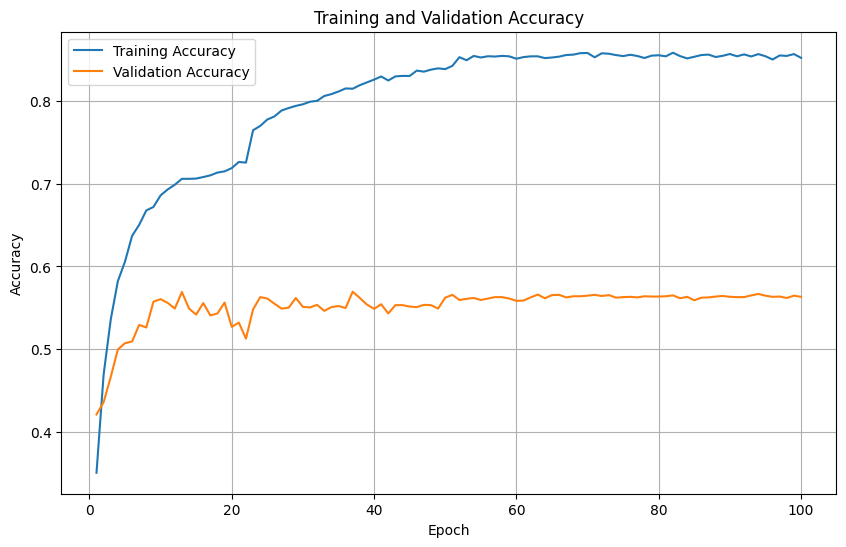

In [9]:
import matplotlib.pyplot as plt
num_epochs = 100
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

utils.test_model(model, test_loader)
end_time = time.time()

hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

Test acc: 0.641
time to train hyperparameters: 1.0 hours, 9.0 minutes, 8 seconds
time to train model: 1.0 hours, 9.0 minutes, 8 seconds


# **CNN-LSTM**

## Find Hyperparameters

In [11]:
# time to measure exactly how much of my life i won't get back
start_time = time.time()
params = utils.learn_hyperparameters(X_train=X_train, 
                                     y_train=y_train, 
                                     X_valid=X_valid, 
                                     y_valid=y_valid, 
                                     model_name='CNNLSTM', 
                                     num_epochs=10, 
                                     trials=20)
optim_end = time.time()

[I 2024-03-11 05:09:44,776] A new study created in memory with name: no-name-50d1fab9-3203-426f-a02e-9d1cb914ed2f


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  64
    Optimizer:                          SGD
        Learning Rate:                  0.002681638559247825
        Weight Decay:                   0.0005595405413719119
        Momentum:                       0.8396016751513767
    Model:                              CNNLSTM
        Dropout:                        0.4961320760316572
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               4
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.258, Val acc: 0.213, Val loss: 1.385
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.266, Val acc: 0.221, Val loss: 1.386
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.275, Val acc: 0.211, Val loss: 1.385
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.289, Val acc: 0.215, Val loss: 1.385


[I 2024-03-11 05:10:01,202] Trial 0 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  32
    Optimizer:                          SGD
        Learning Rate:                  0.004846116940275821
        Weight Decay:                   3.778614662430099e-06
        Momentum:                       0.8826844505026615
    Model:                              CNNLSTM
        Dropout:                        0.5750520102159097
        (Block 1) Conv1d Kernel Size:   9
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.246, Val acc: 0.212, Val loss: 1.385
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.212, Val loss: 1.383
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.212, Val loss: 1.383
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-11 05:10:17,626] Trial 1 pruned. 


Train acc: 0.258, Val acc: 0.212, Val loss: 1.383
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  64
    Optimizer:                          RMSprop
        Learning Rate:                  0.0022568356529607363
        Weight Decay:                   1.5047645032869539e-06
        Momentum:                       0.9309347454725664
    Model:                              CNNLSTM
        Dropout:                        0.56973696278004
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   7
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.282, Val loss: 1.434
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.283, Val loss: 1.405
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.246, Val acc: 0.253, Val loss: 1.396
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.254, Val acc: 0.283, Val loss: 1.399
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.212, Val loss: 1.393


[I 2024-03-11 05:10:55,530] Trial 2 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  256
    Optimizer:                          SGD
        Learning Rate:                  0.003924450733481583
        Weight Decay:                   0.005556846825422449
        Momentum:                       0.832310486461166
    Model:                              CNNLSTM
        Dropout:                        0.5104284828509007
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.252, Val acc: 0.212, Val loss: 1.383
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.271, Val acc: 0.212, Val loss: 1.379
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.280, Val acc: 0.221, Val loss: 1.377
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:12:05,770] Trial 3 pruned. 


Train acc: 0.287, Val acc: 0.232, Val loss: 1.373
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  32
    Optimizer:                          Adam
        Learning Rate:                  0.005182111685772867
        Weight Decay:                   0.0004937964759299547
    Model:                              CNNLSTM
        Dropout:                        0.5026501849964197
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.336, Val acc: 0.370, Val loss: 1.245
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.404, Val acc: 0.373, Val loss: 1.144
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.431, Val loss: 1.140
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.412, Val acc: 0.429, Val loss: 1.136
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.417, Val acc: 0.399, Val loss: 1.080
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.461, Val loss: 1.069
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.427, Val loss: 1.177
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.444, Val loss: 1.038
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.435, Val acc: 0.445, Val loss: 0.919
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:13:20,575] Trial 4 finished with value: 0.46447139978408813 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.005182111685772867, 'weight_decay': 0.0004937964759299547, 'momentum': 0.8635074021524499, 'dropout': 0.5026501849964197, 'kernel1': 7, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 3, 'depth': 150, 'scale': 5, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.444, Val acc: 0.464, Val loss: 1.075
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  32
    Optimizer:                          Adam
        Learning Rate:                  0.004092107789235703
        Weight Decay:                   0.002604826482702102
    Model:                              CNNLSTM
        Dropout:                        0.40351056406014263
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.298, Val acc: 0.345, Val loss: 1.307
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.387, Val acc: 0.387, Val loss: 1.265
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.409, Val acc: 0.407, Val loss: 1.308
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.404, Val loss: 1.287
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.393, Val loss: 1.332
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.424, Val loss: 1.320
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.446, Val acc: 0.437, Val loss: 1.273
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.453, Val acc: 0.421, Val loss: 1.341
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.450, Val acc: 0.436, Val loss: 1.303
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.457, Val acc: 0.415, Val loss: 1.336


[I 2024-03-11 05:13:46,621] Trial 5 finished with value: 0.43708840012550354 and parameters: {'batch_size': 256, 'optimizer_name': 'Adam', 'learning_rate': 0.004092107789235703, 'weight_decay': 0.002604826482702102, 'momentum': 0.9779098010372821, 'dropout': 0.40351056406014263, 'kernel1': 2, 'kernel2': '(1, 25)', 'kernel3': 7, 'kernel4': 2, 'pool_kernel': 5, 'depth': 25, 'scale': 2, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  32
    Optimizer:                          NAdam
        Learning Rate:                  0.0006377570159142858
        Weight Decay:                   1.788658543630336e-05
    Model:                              CNNLSTM
        Dropout:                        0.43543892945794066
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.284, Val acc: 0.261, Val loss: 1.361
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.335, Val acc: 0.301, Val loss: 1.381
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.358, Val acc: 0.307, Val loss: 1.515
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.366, Val acc: 0.303, Val loss: 1.342
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.376, Val acc: 0.302, Val loss: 1.371
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.312, Val loss: 1.494
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.382, Val acc: 0.319, Val loss: 1.397
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.396, Val acc: 0.319, Val loss: 1.510
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.420, Val acc: 0.358, Val loss: 1.374
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.419, Val acc: 0.359, Val loss: 1.241


[I 2024-03-11 05:15:02,218] Trial 6 finished with value: 0.35875216126441956 and parameters: {'batch_size': 64, 'optimizer_name': 'NAdam', 'learning_rate': 0.0006377570159142858, 'weight_decay': 1.788658543630336e-05, 'momentum': 0.9009876812408784, 'dropout': 0.43543892945794066, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 4, 'kernel4': 3, 'pool_kernel': 5, 'depth': 150, 'scale': 5, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  256
    Optimizer:                          SGD
        Learning Rate:                  0.00030677356369238236
        Weight Decay:                   3.383963635692009e-05
        Momentum:                       0.9664239695298955
    Model:                              CNNLSTM
        Dropout:                        0.6327037565783107
        (Block 1) Conv1d Kernel Size:   2
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   4
        (Block 3) Conv1d Kernel Size:   2
        Pool Kernel Size:               4
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.251, Val acc: 0.283, Val loss: 1.386
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.211, Val loss: 1.385
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.212, Val loss: 1.384
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

[I 2024-03-11 05:15:41,519] Trial 7 pruned. 


Train acc: 0.260, Val acc: 0.212, Val loss: 1.383
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adamax
        Learning Rate:                  0.002227742683487569
        Weight Decay:                   3.212721619189215e-06
    Model:                              CNNLSTM
        Dropout:                        0.4118963677663743
        (Block 1) Conv1d Kernel Size:   3
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.268, Val acc: 0.261, Val loss: 1.391
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.305, Val acc: 0.288, Val loss: 1.391
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.359, Val acc: 0.358, Val loss: 1.318
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.384, Val acc: 0.402, Val loss: 1.221
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.426, Val loss: 1.206
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.431, Val loss: 1.191
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.436, Val acc: 0.430, Val loss: 1.188
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.429, Val loss: 1.150
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.431, Val loss: 1.212
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:17:13,382] Trial 8 finished with value: 0.441247820854187 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.002227742683487569, 'weight_decay': 3.212721619189215e-06, 'momentum': 0.9846813200732064, 'dropout': 0.4118963677663743, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 2, 'depth': 100, 'scale': 2, 'hidden_dims': 16}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.464, Val acc: 0.441, Val loss: 1.173
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  256
    Optimizer:                          NAdam
        Learning Rate:                  0.003051707984160668
        Weight Decay:                   0.0006308846101282516
    Model:                              CNNLSTM
        Dropout:                        0.42977160242592227
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 25)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               5
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.285, Val acc: 0.332, Val loss: 1.401
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.314, Val acc: 0.326, Val loss: 1.231
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.360, Val acc: 0.378, Val loss: 1.152
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.416, Val loss: 1.123
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.296, Val acc: 0.226, Val loss: 1.408


[I 2024-03-11 05:18:41,107] Trial 9 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  128
    Optimizer:                          Adam
        Learning Rate:                  0.008747256091848397
        Weight Decay:                   0.00022690745080871614
    Model:                              CNNLSTM
        Dropout:                        0.7774549027306548
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   2
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.274, Val acc: 0.299, Val loss: 1.401
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.345, Val acc: 0.316, Val loss: 1.365
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.371, Val acc: 0.331, Val loss: 1.360
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.377, Val acc: 0.273, Val loss: 1.385


[I 2024-03-11 05:18:57,377] Trial 10 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adamax
        Learning Rate:                  0.0012558083189720525
        Weight Decay:                   5.921947459517738e-05
    Model:                              CNNLSTM
        Dropout:                        0.4969493439432344
        (Block 1) Conv1d Kernel Size:   5
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.249, Val acc: 0.267, Val loss: 1.386
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.265, Val acc: 0.287, Val loss: 1.351
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.297, Val acc: 0.389, Val loss: 1.358
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.350, Val acc: 0.421, Val loss: 1.330
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.381, Val acc: 0.416, Val loss: 1.247
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.395, Val acc: 0.416, Val loss: 1.236
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.418, Val loss: 1.298
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.408, Val acc: 0.418, Val loss: 1.349
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.431, Val loss: 1.346
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:20:30,033] Trial 11 finished with value: 0.43084922432899475 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.0012558083189720525, 'weight_decay': 5.921947459517738e-05, 'momentum': 0.8735639331892612, 'dropout': 0.4969493439432344, 'kernel1': 5, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 2, 'depth': 100, 'scale': 4, 'hidden_dims': 16}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.423, Val acc: 0.419, Val loss: 1.367
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adamax
        Learning Rate:                  0.00012787939853683275
        Weight Decay:                   6.910659274245531e-06
    Model:                              CNNLSTM
        Dropout:                        0.6463201756959247
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.255, Val acc: 0.212, Val loss: 1.266
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.259, Val acc: 0.212, Val loss: 1.272
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.257, Val acc: 0.212, Val loss: 1.279
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.262, Val acc: 0.212, Val loss: 1.284


[I 2024-03-11 05:21:07,192] Trial 12 pruned. 


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.009839712408012851
        Weight Decay:                   0.00014939086554806899
    Model:                              CNNLSTM
        Dropout:                        0.4764719938211102
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   4
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.329, Val acc: 0.401, Val loss: 1.206
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.401, Val acc: 0.428, Val loss: 1.285
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.403, Val loss: 1.305
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.434, Val loss: 1.227
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.406, Val loss: 1.087
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.430, Val acc: 0.417, Val loss: 1.253
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.407, Val loss: 1.115
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.425, Val loss: 1.165
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.418, Val loss: 1.057
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:22:22,727] Trial 13 finished with value: 0.43396881222724915 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.009839712408012851, 'weight_decay': 0.00014939086554806899, 'momentum': 0.8521215498452793, 'dropout': 0.4764719938211102, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 5, 'kernel4': 4, 'pool_kernel': 2, 'depth': 200, 'scale': 5, 'hidden_dims': 16}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.449, Val acc: 0.398, Val loss: 1.068
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  128
    Optimizer:                          Adamax
        Learning Rate:                  0.0012570465836046567
        Weight Decay:                   0.001048339890891603
    Model:                              CNNLSTM
        Dropout:                        0.5338969374641107
        (Block 1) Conv1d Kernel Size:   6
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   6
        (Block 3) Conv1d Kernel Size:   3
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.330, Val acc: 0.413, Val loss: 1.299
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.398, Val acc: 0.396, Val loss: 1.108
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.411, Val acc: 0.393, Val loss: 1.065
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.424, Val acc: 0.401, Val loss: 1.137
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.435, Val acc: 0.412, Val loss: 1.136
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.437, Val acc: 0.409, Val loss: 1.095
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.442, Val acc: 0.409, Val loss: 1.159
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.454, Val acc: 0.423, Val loss: 1.176
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.463, Val acc: 0.427, Val loss: 1.216
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

[I 2024-03-11 05:23:53,302] Trial 14 finished with value: 0.4270364046096802 and parameters: {'batch_size': 64, 'optimizer_name': 'Adamax', 'learning_rate': 0.0012570465836046567, 'weight_decay': 0.001048339890891603, 'momentum': 0.9406552042778109, 'dropout': 0.5338969374641107, 'kernel1': 6, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 3, 'pool_kernel': 3, 'depth': 100, 'scale': 3, 'hidden_dims': 128}. Best is trial 4 with value: 0.46447139978408813.


Train acc: 0.477, Val acc: 0.421, Val loss: 1.358
Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  32
    Optimizer:                          RMSprop
        Learning Rate:                  0.0006315875746669627
        Weight Decay:                   1.543353531599272e-05
        Momentum:                       0.8658045458951797
    Model:                              CNNLSTM
        Dropout:                        0.7372633926761906
        (Block 1) Conv1d Kernel Size:   4
        (Block 1) Conv2d Kernel Size:   (1, 22)
        (Block 2) Conv1d Kernel Size:   7
        (Block 3) Conv1d Kernel Size:   5
        Pool Kernel Size:               2
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.265, Val acc: 0.349, Val loss: 1.381
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.339, Val acc: 0.417, Val loss: 1.313
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.380, Val acc: 0.408, Val loss: 1.315
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.396, Val acc: 0.418, Val loss: 1.281
Epoch 5


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.410, Val loss: 1.314
Epoch 6


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.399, Val loss: 1.318
Epoch 7


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.393, Val loss: 1.312
Epoch 8


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.393, Val loss: 1.320
Epoch 9


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.423, Val acc: 0.387, Val loss: 1.311
Epoch 10


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.427, Val acc: 0.403, Val loss: 1.311


[I 2024-03-11 05:24:19,624] Trial 15 finished with value: 0.4180242717266083 and parameters: {'batch_size': 256, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0006315875746669627, 'weight_decay': 1.543353531599272e-05, 'momentum': 0.8658045458951797, 'dropout': 0.7372633926761906, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 5, 'pool_kernel': 2, 'depth': 150, 'scale': 4, 'hidden_dims': 32}. Best is trial 4 with value: 0.46447139978408813.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.001546825635948739
        Weight Decay:                   0.00018254194580256077
    Model:                              CNNLSTM
        Dropout:                        0.45512227914263886
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.338, Val acc: 0.416, Val loss: 1.143
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.400, Val acc: 0.415, Val loss: 1.151
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.413, Val acc: 0.416, Val loss: 1.209
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.425, Val acc: 0.418, Val loss: 1.277
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.431, Val acc: 0.432, Val loss: 1.156
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.435, Val loss: 1.452
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.469, Val acc: 0.455, Val loss: 1.235
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.485, Val acc: 0.472, Val loss: 1.432
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.497, Val acc: 0.488, Val loss: 1.523
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.505, Val acc: 0.493, Val loss: 1.499


[I 2024-03-11 05:25:33,675] Trial 16 finished with value: 0.4932408928871155 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.001546825635948739, 'weight_decay': 0.00018254194580256077, 'momentum': 0.9069342595487224, 'dropout': 0.45512227914263886, 'kernel1': 7, 'kernel2': '(1, 17)', 'kernel3': 5, 'kernel4': 6, 'pool_kernel': 3, 'depth': 100, 'scale': 5, 'hidden_dims': 16}. Best is trial 16 with value: 0.4932408928871155.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.0057851449247431725
        Weight Decay:                   0.0001650076926169088
    Model:                              CNNLSTM
        Dropout:                        0.46265098109915254
        (Block 1) Conv1d Kernel Size:   8
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               4
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.318, Val acc: 0.393, Val loss: 1.287
Epoch 2


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.390, Val acc: 0.434, Val loss: 1.204
Epoch 3


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.414, Val loss: 1.249
Epoch 4


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.406, Val acc: 0.404, Val loss: 1.287
Epoch 5


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.418, Val acc: 0.368, Val loss: 1.039
Epoch 6


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.429, Val acc: 0.408, Val loss: 1.033
Epoch 7


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.439, Val acc: 0.446, Val loss: 1.083
Epoch 8


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.447, Val acc: 0.412, Val loss: 1.010
Epoch 9


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.451, Val acc: 0.450, Val loss: 1.116
Epoch 10


  0%|          | 0/406 [00:00<?, ?it/s]

Train acc: 0.459, Val acc: 0.428, Val loss: 1.130


[I 2024-03-11 05:26:47,366] Trial 17 finished with value: 0.44956672191619873 and parameters: {'batch_size': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0057851449247431725, 'weight_decay': 0.0001650076926169088, 'momentum': 0.9053066214699917, 'dropout': 0.46265098109915254, 'kernel1': 8, 'kernel2': '(1, 17)', 'kernel3': 5, 'kernel4': 6, 'pool_kernel': 4, 'depth': 150, 'scale': 5, 'hidden_dims': 16}. Best is trial 16 with value: 0.4932408928871155.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         128
    Hidden Dimensions:                  32
    Optimizer:                          Adam
        Learning Rate:                  0.0007338282996969646
        Weight Decay:                   0.00984097477512793
    Model:                              CNNLSTM
        Dropout:                        0.5465729487630663
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   3
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.283, Val acc: 0.251, Val loss: 1.375
Epoch 2


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.368, Val acc: 0.280, Val loss: 1.317
Epoch 3


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.388, Val acc: 0.320, Val loss: 1.300
Epoch 4


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.403, Val acc: 0.339, Val loss: 1.302
Epoch 5


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.407, Val acc: 0.399, Val loss: 1.302
Epoch 6


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.411, Val acc: 0.353, Val loss: 1.294
Epoch 7


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.379, Val loss: 1.302
Epoch 8


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.414, Val acc: 0.374, Val loss: 1.334
Epoch 9


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.415, Val acc: 0.377, Val loss: 1.302
Epoch 10


  0%|          | 0/203 [00:00<?, ?it/s]

Train acc: 0.416, Val acc: 0.380, Val loss: 1.303


[I 2024-03-11 05:27:29,392] Trial 18 finished with value: 0.39861351251602173 and parameters: {'batch_size': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0007338282996969646, 'weight_decay': 0.00984097477512793, 'momentum': 0.8217117341107333, 'dropout': 0.5465729487630663, 'kernel1': 7, 'kernel2': '(1, 17)', 'kernel3': 3, 'kernel4': 6, 'pool_kernel': 3, 'depth': 50, 'scale': 5, 'hidden_dims': 32}. Best is trial 16 with value: 0.4932408928871155.


Training with the following hyperparameters:
---------------------------------------------
    Batch Size:                         256
    Hidden Dimensions:                  128
    Optimizer:                          Adam
        Learning Rate:                  0.00036618660279759077
        Weight Decay:                   0.001697632540859746
    Model:                              CNNLSTM
        Dropout:                        0.6190505091007079
        (Block 1) Conv1d Kernel Size:   10
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          22
        Scale:                          2
Epoch 1


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.263, Val acc: 0.214, Val loss: 1.385
Epoch 2


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.321, Val acc: 0.236, Val loss: 1.374
Epoch 3


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.381, Val acc: 0.295, Val loss: 1.338
Epoch 4


  0%|          | 0/102 [00:00<?, ?it/s]

Train acc: 0.404, Val acc: 0.277, Val loss: 1.355


[I 2024-03-11 05:27:45,767] Trial 19 pruned. 


Number of finished trials: 20
Best trial:
    Validation Accuracy: 0.4932408928871155
    Learned Hyperparameters
    ------------------------
    Batch Size:                         64
    Hidden Dimensions:                  16
    Optimizer:                          Adam
        Learning Rate:                  0.001546825635948739
        Weight Decay:                   0.00018254194580256077
    Model:                              CNNLSTM
        Dropout:                        0.45512227914263886
        (Block 1) Conv1d Kernel Size:   7
        (Block 1) Conv2d Kernel Size:   (1, 17)
        (Block 2) Conv1d Kernel Size:   5
        (Block 3) Conv1d Kernel Size:   6
        Pool Kernel Size:               3
        Depth:                          100
        Scale:                          5


## Model Summary

In [12]:
model = cnnlstm.CNNLSTM(num_classes=4,
                        hidden_dims=params.get('hidden_dims'),
                        dropout=params.get('dropout'),
                        kernel1=params.get('kernel1'),
                        kernel2=eval(params.get('kernel2')),
                        kernel3=params.get('kernel3'),
                        kernel4=params.get('kernel4'),
                        pool_kernel=params.get('pool_kernel'),
                        depth=params.get('depth'),
                        scale=params.get('scale')).to(device)


torchinfo.summary(model, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [200, 4]                  --
├─Sequential: 1-1                        [200, 100, 394]           --
│    └─Conv1d: 2-1                       [200, 100, 394]           15,500
│    └─ReLU: 2-2                         [200, 100, 394]           --
│    └─BatchNorm1d: 2-3                  [200, 100, 394]           200
│    └─Dropout: 2-4                      [200, 100, 394]           --
├─Sequential: 1-2                        [200, 100, 1, 126]        --
│    └─Conv2d: 2-5                       [200, 100, 1, 378]        170,100
│    └─ELU: 2-6                          [200, 100, 1, 378]        --
│    └─BatchNorm2d: 2-7                  [200, 100, 1, 378]        200
│    └─MaxPool2d: 2-8                    [200, 100, 1, 126]        --
│    └─Dropout: 2-9                      [200, 100, 1, 126]        --
├─Sequential: 1-3                        [200, 500, 40]            --
│   

## Training with Learned Hyperparameters

In [13]:
criterion = nn.CrossEntropyLoss()
if params.get('optimizer_name') == 'RMSprop' or params.get('optimizer_name') == 'SGD':
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'),
                                                                    momentum=params.get('momentum'))
else:
    optimizer = getattr(torch.optim, params.get('optimizer_name'))(model.parameters(),
                                                                    lr=params.get('learning_rate'),
                                                                    weight_decay=params.get('weight_decay'))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

train_accuracies, val_accuracies = utils.train_model(model, 
                                                     criterion, 
                                                     optimizer, 
                                                     scheduler, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader, 
                                                     num_epochs=100)

Epoch 1


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.310, Val acc: 0.415, Val loss: 1.216
Epoch 2


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.399, Val acc: 0.424, Val loss: 1.274
Epoch 3


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.422, Val acc: 0.409, Val loss: 1.285
Epoch 4


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.438, Val acc: 0.415, Val loss: 1.358
Epoch 5


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.452, Val acc: 0.412, Val loss: 1.260
Epoch 6


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.469, Val acc: 0.423, Val loss: 1.142
Epoch 7


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.481, Val acc: 0.426, Val loss: 1.213
Epoch 8


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.500, Val acc: 0.430, Val loss: 1.410
Epoch 9


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.514, Val acc: 0.415, Val loss: 1.220
Epoch 10


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.532, Val acc: 0.419, Val loss: 1.488
Epoch 11


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.549, Val acc: 0.434, Val loss: 1.246
Epoch 12


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.555, Val acc: 0.426, Val loss: 1.300
Epoch 13


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.567, Val acc: 0.454, Val loss: 1.301
Epoch 14


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.574, Val acc: 0.449, Val loss: 1.504
Epoch 15


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.588, Val acc: 0.431, Val loss: 1.487
Epoch 16


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.596, Val acc: 0.420, Val loss: 1.315
Epoch 17


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.603, Val acc: 0.445, Val loss: 1.310
Epoch 18


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.632, Val acc: 0.457, Val loss: 1.530
Epoch 19


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.644, Val acc: 0.451, Val loss: 1.545
Epoch 20


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.647, Val acc: 0.451, Val loss: 1.245
Epoch 21


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.656, Val acc: 0.452, Val loss: 1.251
Epoch 22


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.658, Val acc: 0.452, Val loss: 1.643
Epoch 23


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.657, Val acc: 0.452, Val loss: 1.553
Epoch 24


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.657, Val acc: 0.450, Val loss: 1.555
Epoch 25


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.660, Val acc: 0.450, Val loss: 1.438
Epoch 26


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.669, Val acc: 0.446, Val loss: 1.536
Epoch 27


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.666, Val acc: 0.450, Val loss: 1.647
Epoch 28


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.443, Val loss: 1.429
Epoch 29


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.671, Val acc: 0.443, Val loss: 1.757
Epoch 30


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.445, Val loss: 1.527
Epoch 31


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.162
Epoch 32


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.448, Val loss: 1.506
Epoch 33


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.420
Epoch 34


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.444, Val loss: 1.554
Epoch 35


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.592
Epoch 36


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.448, Val loss: 1.625
Epoch 37


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.259
Epoch 38


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.448, Val loss: 1.540
Epoch 39


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.444, Val loss: 1.559
Epoch 40


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.448, Val loss: 1.587
Epoch 41


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.234
Epoch 42


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.446, Val loss: 1.669
Epoch 43


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.448, Val loss: 1.499
Epoch 44


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.356
Epoch 45


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.447, Val loss: 1.606
Epoch 46


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.449, Val loss: 1.429
Epoch 47


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.448, Val loss: 1.202
Epoch 48


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.717
Epoch 49


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.363
Epoch 50


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.449, Val loss: 1.461
Epoch 51


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.445, Val loss: 1.419
Epoch 52


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.388
Epoch 53


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.682, Val acc: 0.447, Val loss: 1.246
Epoch 54


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.448, Val loss: 1.262
Epoch 55


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.444
Epoch 56


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.448, Val loss: 1.548
Epoch 57


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.676, Val acc: 0.447, Val loss: 1.254
Epoch 58


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.626
Epoch 59


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.592
Epoch 60


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.449, Val loss: 1.398
Epoch 61


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.446, Val loss: 1.452
Epoch 62


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.494
Epoch 63


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.445, Val loss: 1.390
Epoch 64


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.447, Val loss: 1.581
Epoch 65


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.449, Val loss: 1.577
Epoch 66


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.447, Val loss: 1.772
Epoch 67


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.445, Val loss: 1.473
Epoch 68


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.650
Epoch 69


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.687, Val acc: 0.446, Val loss: 1.369
Epoch 70


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.447, Val loss: 1.598
Epoch 71


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.448, Val loss: 1.289
Epoch 72


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.446, Val loss: 1.429
Epoch 73


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.445, Val loss: 1.577
Epoch 74


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.445, Val loss: 1.435
Epoch 75


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.345
Epoch 76


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.449, Val loss: 1.334
Epoch 77


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.347
Epoch 78


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.683, Val acc: 0.448, Val loss: 1.285
Epoch 79


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.310
Epoch 80


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.446, Val loss: 1.397
Epoch 81


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.446, Val loss: 1.289
Epoch 82


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.449, Val loss: 1.584
Epoch 83


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.674, Val acc: 0.448, Val loss: 1.426
Epoch 84


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.414
Epoch 85


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.446, Val loss: 1.500
Epoch 86


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.445, Val loss: 1.636
Epoch 87


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.446, Val loss: 1.781
Epoch 88


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.447, Val loss: 1.414
Epoch 89


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.448, Val loss: 1.594
Epoch 90


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.675, Val acc: 0.447, Val loss: 1.596
Epoch 91


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.278
Epoch 92


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.446, Val loss: 1.359
Epoch 93


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.446, Val loss: 1.626
Epoch 94


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.679, Val acc: 0.447, Val loss: 1.520
Epoch 95


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.447, Val loss: 1.390
Epoch 96


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.678, Val acc: 0.447, Val loss: 1.450
Epoch 97


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.680, Val acc: 0.447, Val loss: 1.293
Epoch 98


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.685, Val acc: 0.449, Val loss: 1.572
Epoch 99


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.677, Val acc: 0.445, Val loss: 1.411
Epoch 100


  0%|          | 0/130 [00:00<?, ?it/s]

Train acc: 0.681, Val acc: 0.448, Val loss: 1.795


## Training and Accuracy Graph

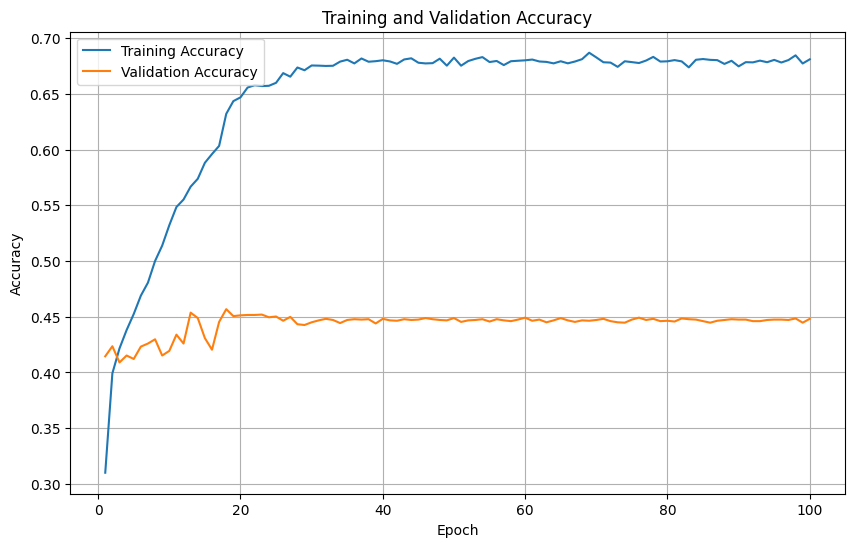

In [14]:
import matplotlib.pyplot as plt
num_epochs = 100
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

utils.test_model(model, test_loader)
end_time = time.time()

hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

Test acc: 0.479
time to train hyperparameters: 0.0 hours, 18.0 minutes, 1 seconds
time to train model: 0.0 hours, 18.0 minutes, 1 seconds


# **SCORED MODELS**

## Optimization (CNN) Got 74.7% (Run block to train)
* TODO: i realized too late that the hyperparameters with ranges should just be an avg of the patero front, not the max.

## CNN Architecture

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
        super(CNN, self).__init__()

        self.time_bins = 400
        self.magic_number = self.time_bins + kernel3 - 1

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Dropout(dropout)
        )

        self.L_pool = self.time_bins - kernel1 + 1

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=25, out_channels=50, kernel_size=kernel2),
            nn.ELU(),
            nn.BatchNorm2d(50),
            nn.MaxPool2d(kernel_size=(1, pool_kernel)),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel2[1] + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=100, kernel_size=kernel3),
            nn.ELU(),
            nn.BatchNorm1d(100),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel3 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.conv4 = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
            nn.ELU(),
            nn.BatchNorm1d(self.magic_number),
            nn.MaxPool1d(kernel_size=pool_kernel),
            nn.Dropout(dropout)
        )

        self.L_pool = self.L_pool - kernel4 + 1
        self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

        self.dense = nn.Linear(in_features= self.L_pool * self.magic_number, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = x.unsqueeze(2)      # match dims for Conv2d().
        x = self.conv2(x)
        x = x.squeeze(2)        # match dims for Conv1d().
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.flatten(x, 1) # match dims for affine.
        x = self.dense(x)

        return F.log_softmax(x, dim=1)


## Model Summary

In [ ]:
cnn = CNN(num_classes=4,
          dropout=dropout,
          kernel1=kernel1,
          kernel2=eval(kernel2),
          kernel3=kernel3,
          kernel4=kernel4,
          pool_kernel=pool_kernel).to(device)
summary(cnn, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 4]                   --
├─Sequential: 1-1                        [64, 25, 396]             --
│    └─Conv1d: 2-1                       [64, 25, 396]             2,775
│    └─ReLU: 2-2                         [64, 25, 396]             --
│    └─BatchNorm1d: 2-3                  [64, 25, 396]             50
│    └─Dropout: 2-4                      [64, 25, 396]             --
├─Sequential: 1-2                        [64, 50, 1, 124]          --
│    └─Conv2d: 2-5                       [64, 50, 1, 372]          31,300
│    └─ELU: 2-6                          [64, 50, 1, 372]          --
│    └─BatchNorm2d: 2-7                  [64, 50, 1, 372]          100
│    └─MaxPool2d: 2-8                    [64, 50, 1, 124]          --
│    └─Dropout: 2-9                      [64, 50, 1, 124]          --
├─Sequential: 1-3                        [64, 100, 39]             --
│    └─

## Training with Learned Hyperparameters

In [ ]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

model = CNN(num_classes=4,
            dropout=dropout,
            kernel1=kernel1,
            kernel2=eval(kernel2),
            kernel3=kernel3,
            kernel4=kernel4,
            pool_kernel=pool_kernel
            ).to(device)

criterion = nn.CrossEntropyLoss()

if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(),
                                                                    lr=learning_rate,
                                                                    weight_decay=weight_decay,
                                                                    momentum=momentum)
else:
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(),
                                                                    lr=learning_rate,
                                                                    weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
train_accuracies = [] # for accuracy graph
val_accuracies = []   # for accuracy graph

for epoch_idx in range(num_epochs):
    print(f'EPOCH {epoch_idx}')

    model.train()
    train_count = 0
    train_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)

        logits = model(train_x)
        loss = criterion(logits, train_y)

        optimizer.zero_grad()                         # no gradient accumulation between batches
        loss.backward()                               # do backwards pass
        optimizer.step()                              # take a step using gradients

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count     # getting accuracy measure

    model.eval()                                      # validation
    val_count = 0
    val_correct_count = 0

    with torch.no_grad():                             # dont want gradients to be computed
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1)      # choose most probable class in output
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_y.size(0)
            val_loss = criterion(logits, val_y)

    val_acc = val_correct_count / val_count
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    scheduler.step(val_loss)

    print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

EPOCH 0


100%|██████████| 119/119 [00:01<00:00, 109.12it/s]


Train acc: 0.421, Val acc: 0.520
EPOCH 1


100%|██████████| 119/119 [00:01<00:00, 112.35it/s]


Train acc: 0.555, Val acc: 0.585
EPOCH 2


100%|██████████| 119/119 [00:01<00:00, 112.51it/s]


Train acc: 0.620, Val acc: 0.611
EPOCH 3


100%|██████████| 119/119 [00:01<00:00, 113.23it/s]


Train acc: 0.666, Val acc: 0.601
EPOCH 4


100%|██████████| 119/119 [00:01<00:00, 112.34it/s]


Train acc: 0.721, Val acc: 0.658
EPOCH 5


100%|██████████| 119/119 [00:01<00:00, 111.59it/s]


Train acc: 0.760, Val acc: 0.698
EPOCH 6


100%|██████████| 119/119 [00:01<00:00, 111.68it/s]


Train acc: 0.792, Val acc: 0.686
EPOCH 7


100%|██████████| 119/119 [00:01<00:00, 105.29it/s]


Train acc: 0.810, Val acc: 0.725
EPOCH 8


100%|██████████| 119/119 [00:01<00:00, 102.44it/s]


Train acc: 0.837, Val acc: 0.713
EPOCH 9


100%|██████████| 119/119 [00:01<00:00, 94.35it/s] 


Train acc: 0.860, Val acc: 0.680
EPOCH 10


100%|██████████| 119/119 [00:01<00:00, 113.31it/s]


Train acc: 0.863, Val acc: 0.716
EPOCH 11


100%|██████████| 119/119 [00:01<00:00, 111.29it/s]


Train acc: 0.879, Val acc: 0.704
EPOCH 12


100%|██████████| 119/119 [00:01<00:00, 112.92it/s]


Train acc: 0.882, Val acc: 0.684
EPOCH 13


100%|██████████| 119/119 [00:01<00:00, 113.09it/s]


Train acc: 0.887, Val acc: 0.698
EPOCH 14


100%|██████████| 119/119 [00:01<00:00, 110.62it/s]


Train acc: 0.903, Val acc: 0.725
EPOCH 15


100%|██████████| 119/119 [00:01<00:00, 113.62it/s]


Train acc: 0.905, Val acc: 0.699
EPOCH 16


100%|██████████| 119/119 [00:01<00:00, 113.13it/s]


Train acc: 0.906, Val acc: 0.718
EPOCH 17


100%|██████████| 119/119 [00:01<00:00, 112.87it/s]


Train acc: 0.908, Val acc: 0.723
EPOCH 18


100%|██████████| 119/119 [00:01<00:00, 106.58it/s]


Train acc: 0.913, Val acc: 0.697
EPOCH 19


100%|██████████| 119/119 [00:01<00:00, 102.50it/s]


Train acc: 0.921, Val acc: 0.732
EPOCH 20


100%|██████████| 119/119 [00:01<00:00, 89.98it/s]


Train acc: 0.922, Val acc: 0.711
EPOCH 21


100%|██████████| 119/119 [00:01<00:00, 111.56it/s]


Train acc: 0.926, Val acc: 0.725
EPOCH 22


100%|██████████| 119/119 [00:01<00:00, 111.30it/s]


Train acc: 0.932, Val acc: 0.722
EPOCH 23


100%|██████████| 119/119 [00:01<00:00, 112.04it/s]


Train acc: 0.928, Val acc: 0.739
EPOCH 24


100%|██████████| 119/119 [00:01<00:00, 111.38it/s]


Train acc: 0.932, Val acc: 0.726
EPOCH 25


100%|██████████| 119/119 [00:01<00:00, 112.28it/s]


Train acc: 0.937, Val acc: 0.723
EPOCH 26


100%|██████████| 119/119 [00:01<00:00, 112.29it/s]


Train acc: 0.935, Val acc: 0.717
EPOCH 27


100%|██████████| 119/119 [00:01<00:00, 110.64it/s]


Train acc: 0.938, Val acc: 0.700
EPOCH 28


100%|██████████| 119/119 [00:01<00:00, 112.24it/s]


Train acc: 0.965, Val acc: 0.757
EPOCH 29


100%|██████████| 119/119 [00:01<00:00, 109.31it/s]


Train acc: 0.969, Val acc: 0.759
EPOCH 30


100%|██████████| 119/119 [00:01<00:00, 102.50it/s]


Train acc: 0.972, Val acc: 0.756
EPOCH 31


100%|██████████| 119/119 [00:01<00:00, 93.13it/s]


Train acc: 0.977, Val acc: 0.762
EPOCH 32


100%|██████████| 119/119 [00:01<00:00, 111.01it/s]


Train acc: 0.973, Val acc: 0.755
EPOCH 33


100%|██████████| 119/119 [00:01<00:00, 113.30it/s]


Train acc: 0.978, Val acc: 0.767
EPOCH 34


100%|██████████| 119/119 [00:01<00:00, 113.05it/s]


Train acc: 0.977, Val acc: 0.757
EPOCH 35


100%|██████████| 119/119 [00:01<00:00, 111.74it/s]


Train acc: 0.977, Val acc: 0.762
EPOCH 36


100%|██████████| 119/119 [00:01<00:00, 112.86it/s]


Train acc: 0.979, Val acc: 0.758
EPOCH 37


100%|██████████| 119/119 [00:01<00:00, 112.44it/s]


Train acc: 0.979, Val acc: 0.761
EPOCH 38


100%|██████████| 119/119 [00:01<00:00, 112.38it/s]


Train acc: 0.979, Val acc: 0.759
EPOCH 39


100%|██████████| 119/119 [00:01<00:00, 111.66it/s]


Train acc: 0.982, Val acc: 0.763
EPOCH 40


100%|██████████| 119/119 [00:01<00:00, 112.39it/s]


Train acc: 0.982, Val acc: 0.762
EPOCH 41


100%|██████████| 119/119 [00:01<00:00, 97.14it/s]


Train acc: 0.980, Val acc: 0.767
EPOCH 42


100%|██████████| 119/119 [00:01<00:00, 95.50it/s]


Train acc: 0.983, Val acc: 0.767
EPOCH 43


100%|██████████| 119/119 [00:01<00:00, 103.71it/s]


Train acc: 0.984, Val acc: 0.761
EPOCH 44


100%|██████████| 119/119 [00:01<00:00, 112.09it/s]


Train acc: 0.982, Val acc: 0.764
EPOCH 45


100%|██████████| 119/119 [00:01<00:00, 111.85it/s]


Train acc: 0.980, Val acc: 0.763
EPOCH 46


100%|██████████| 119/119 [00:01<00:00, 111.27it/s]


Train acc: 0.984, Val acc: 0.765
EPOCH 47


100%|██████████| 119/119 [00:01<00:00, 111.41it/s]


Train acc: 0.982, Val acc: 0.769
EPOCH 48


100%|██████████| 119/119 [00:01<00:00, 112.83it/s]


Train acc: 0.983, Val acc: 0.764
EPOCH 49


100%|██████████| 119/119 [00:01<00:00, 112.61it/s]


Train acc: 0.984, Val acc: 0.765
EPOCH 50


100%|██████████| 119/119 [00:01<00:00, 107.41it/s]


Train acc: 0.984, Val acc: 0.772
EPOCH 51


100%|██████████| 119/119 [00:01<00:00, 113.47it/s]


Train acc: 0.983, Val acc: 0.771
EPOCH 52


100%|██████████| 119/119 [00:01<00:00, 101.80it/s]


Train acc: 0.982, Val acc: 0.761
EPOCH 53


100%|██████████| 119/119 [00:01<00:00, 98.35it/s]


Train acc: 0.982, Val acc: 0.762
EPOCH 54


100%|██████████| 119/119 [00:01<00:00, 102.98it/s]


Train acc: 0.981, Val acc: 0.763
EPOCH 55


100%|██████████| 119/119 [00:01<00:00, 112.96it/s]


Train acc: 0.984, Val acc: 0.768
EPOCH 56


100%|██████████| 119/119 [00:01<00:00, 112.27it/s]


Train acc: 0.982, Val acc: 0.763
EPOCH 57


100%|██████████| 119/119 [00:01<00:00, 103.75it/s]


Train acc: 0.983, Val acc: 0.767
EPOCH 58


100%|██████████| 119/119 [00:01<00:00, 103.51it/s]


Train acc: 0.983, Val acc: 0.763
EPOCH 59


100%|██████████| 119/119 [00:01<00:00, 93.26it/s]


Train acc: 0.980, Val acc: 0.765
EPOCH 60


100%|██████████| 119/119 [00:01<00:00, 112.14it/s]


Train acc: 0.981, Val acc: 0.764
EPOCH 61


100%|██████████| 119/119 [00:01<00:00, 111.94it/s]


Train acc: 0.984, Val acc: 0.770
EPOCH 62


100%|██████████| 119/119 [00:01<00:00, 111.72it/s]


Train acc: 0.985, Val acc: 0.769
EPOCH 63


100%|██████████| 119/119 [00:01<00:00, 98.50it/s] 


Train acc: 0.983, Val acc: 0.765
EPOCH 64


100%|██████████| 119/119 [00:01<00:00, 99.35it/s]


Train acc: 0.983, Val acc: 0.765
EPOCH 65


100%|██████████| 119/119 [00:01<00:00, 103.11it/s]


Train acc: 0.982, Val acc: 0.769
EPOCH 66


100%|██████████| 119/119 [00:01<00:00, 113.11it/s]


Train acc: 0.983, Val acc: 0.763
EPOCH 67


100%|██████████| 119/119 [00:01<00:00, 112.08it/s]


Train acc: 0.982, Val acc: 0.772
EPOCH 68


100%|██████████| 119/119 [00:01<00:00, 112.77it/s]


Train acc: 0.982, Val acc: 0.765
EPOCH 69


100%|██████████| 119/119 [00:01<00:00, 111.91it/s]


Train acc: 0.983, Val acc: 0.769
EPOCH 70


100%|██████████| 119/119 [00:01<00:00, 112.96it/s]


Train acc: 0.983, Val acc: 0.764
EPOCH 71


100%|██████████| 119/119 [00:01<00:00, 113.34it/s]


Train acc: 0.983, Val acc: 0.765
EPOCH 72


100%|██████████| 119/119 [00:01<00:00, 113.73it/s]


Train acc: 0.982, Val acc: 0.771
EPOCH 73


100%|██████████| 119/119 [00:01<00:00, 110.90it/s]


Train acc: 0.984, Val acc: 0.764
EPOCH 74


100%|██████████| 119/119 [00:01<00:00, 103.32it/s]


Train acc: 0.980, Val acc: 0.762
EPOCH 75


100%|██████████| 119/119 [00:01<00:00, 103.52it/s]


Train acc: 0.981, Val acc: 0.765
EPOCH 76


100%|██████████| 119/119 [00:01<00:00, 94.82it/s] 


Train acc: 0.984, Val acc: 0.771
EPOCH 77


100%|██████████| 119/119 [00:01<00:00, 112.15it/s]


Train acc: 0.981, Val acc: 0.767
EPOCH 78


100%|██████████| 119/119 [00:01<00:00, 112.74it/s]


Train acc: 0.979, Val acc: 0.768
EPOCH 79


100%|██████████| 119/119 [00:01<00:00, 111.69it/s]


Train acc: 0.985, Val acc: 0.765
EPOCH 80


100%|██████████| 119/119 [00:01<00:00, 111.16it/s]


Train acc: 0.986, Val acc: 0.770
EPOCH 81


100%|██████████| 119/119 [00:01<00:00, 110.70it/s]


Train acc: 0.981, Val acc: 0.762
EPOCH 82


100%|██████████| 119/119 [00:01<00:00, 113.77it/s]


Train acc: 0.984, Val acc: 0.764
EPOCH 83


100%|██████████| 119/119 [00:01<00:00, 112.64it/s]


Train acc: 0.984, Val acc: 0.769
EPOCH 84


100%|██████████| 119/119 [00:01<00:00, 113.18it/s]


Train acc: 0.982, Val acc: 0.767
EPOCH 85


100%|██████████| 119/119 [00:01<00:00, 102.74it/s]


Train acc: 0.984, Val acc: 0.769
EPOCH 86


100%|██████████| 119/119 [00:01<00:00, 102.96it/s]


Train acc: 0.983, Val acc: 0.768
EPOCH 87


100%|██████████| 119/119 [00:01<00:00, 93.95it/s]


Train acc: 0.982, Val acc: 0.772
EPOCH 88


100%|██████████| 119/119 [00:01<00:00, 112.62it/s]


Train acc: 0.983, Val acc: 0.768
EPOCH 89


100%|██████████| 119/119 [00:01<00:00, 111.96it/s]


Train acc: 0.983, Val acc: 0.763
EPOCH 90


100%|██████████| 119/119 [00:01<00:00, 113.26it/s]


Train acc: 0.980, Val acc: 0.768
EPOCH 91


100%|██████████| 119/119 [00:01<00:00, 112.65it/s]


Train acc: 0.983, Val acc: 0.771
EPOCH 92


100%|██████████| 119/119 [00:01<00:00, 111.75it/s]


Train acc: 0.982, Val acc: 0.764
EPOCH 93


100%|██████████| 119/119 [00:01<00:00, 114.13it/s]


Train acc: 0.980, Val acc: 0.763
EPOCH 94


100%|██████████| 119/119 [00:01<00:00, 112.23it/s]


Train acc: 0.983, Val acc: 0.769
EPOCH 95


100%|██████████| 119/119 [00:01<00:00, 113.38it/s]


Train acc: 0.985, Val acc: 0.768
EPOCH 96


100%|██████████| 119/119 [00:01<00:00, 109.06it/s]


Train acc: 0.982, Val acc: 0.769
EPOCH 97


100%|██████████| 119/119 [00:01<00:00, 101.45it/s]


Train acc: 0.981, Val acc: 0.764
EPOCH 98


100%|██████████| 119/119 [00:01<00:00, 93.90it/s]


Train acc: 0.985, Val acc: 0.763
EPOCH 99


100%|██████████| 119/119 [00:01<00:00, 107.22it/s]


Train acc: 0.982, Val acc: 0.763


## Training and Validation Accuracy Graph

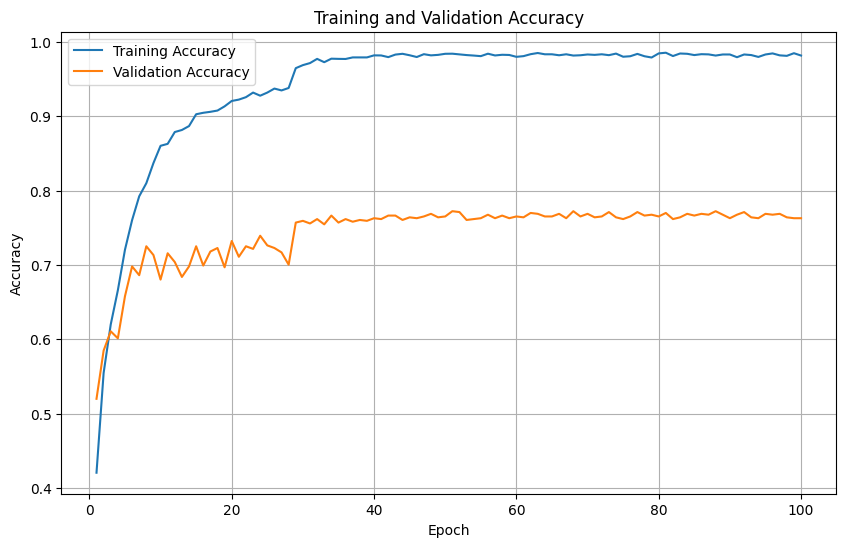

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Test Accuracy

In [ ]:
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Test acc: {:.3f}'.format(test_acc))

    end_time = time.time()


hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

Test acc: 0.747
time to train hyperparameters: 0.0 hours, 8.0 minutes, 48 seconds
time to train model: 0.0 hours, 8.0 minutes, 48 seconds


## Optimization (CNN-LSTM) WIP (Run block to train)
* i would like to make the network shallower since it looks like it's overfitting.
  also, it is not nice to my gpu

## CNN-LSTM Architecture

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes, hidden_dims, dropout, kernel1, kernel2, kernel3, kernel4, pool_kernel):
          super(CNNLSTM, self).__init__()

          self.time_bins = 400
          self.magic_number = self.time_bins + kernel3 - 1

          self.conv1 = nn.Sequential(
              nn.Conv1d(in_channels=22, out_channels=25, kernel_size=kernel1),
              nn.ReLU(),
              nn.BatchNorm1d(25),
              nn.Dropout(dropout)
          )

          self.L_pool = self.time_bins - kernel1 + 1

          self.conv2 = nn.Sequential(
              nn.Conv2d(in_channels=25, out_channels=25, kernel_size=kernel2),
              nn.ELU(),
              nn.BatchNorm2d(25),
              nn.MaxPool2d(kernel_size=(1, pool_kernel)),
              nn.Dropout(dropout)
          )

          self.L_pool = self.L_pool - kernel2[1] + 1
          self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

          self.conv3 = nn.Sequential(
              nn.Conv1d(in_channels=25, out_channels=100, kernel_size=kernel3),
              nn.ELU(),
              nn.BatchNorm1d(100),
              nn.MaxPool1d(kernel_size=pool_kernel),
              nn.Dropout(dropout)
          )

          self.L_pool = self.L_pool - kernel3 + 1
          self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

          self.conv4 = nn.Sequential(
              nn.Conv1d(in_channels=100, out_channels=self.magic_number, kernel_size=kernel4),
              nn.ReLU(),
              nn.BatchNorm1d(self.magic_number),
              nn.MaxPool1d(kernel_size=pool_kernel),
              nn.Dropout(dropout)
          )

          self.L_pool = self.L_pool - kernel4 + 1
          self.L_pool = (self.L_pool - pool_kernel) // pool_kernel + 1

          self.lstm = nn.LSTM(input_size=self.L_pool, hidden_size=hidden_dims, num_layers=2, batch_first=True)
          self.dropout = nn.Dropout(dropout)
          self.dense = nn.Linear(in_features=hidden_dims, out_features=num_classes)

    def forward(self, x):
      x = self.conv1(x)
      x = x.unsqueeze(2)
      x = self.conv2(x)
      x = x.squeeze(2)
      x = self.conv3(x)
      x = self.conv4(x)
      x, _ = self.lstm(x)
      x = self.dropout(x)
      x = self.dense(x[:, -1])
      return F.log_softmax(x, dim=1)

## Optuna (Learning Hyperparameters)

In [ ]:
import optuna
import time
import gc
import collections

def objective(trial):
    # data hyperparameters
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    hidden_dims = trial.suggest_categorical('hidden_dims', [16, 32, 64, 128])

    # optimizer hyperparameters
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'RMSprop', 'SGD'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.8, 0.99, log=True)  # only used for RMSprop and SGD

    # model hyperparameters
    dropout = trial.suggest_float('dropout', 0.4, 0.8)
    kernel1 = trial.suggest_int('kernel1', 2, 9)
    kernel2 = eval(trial.suggest_categorical('kernel2', ['(1, 17)', '(1, 22)', '(1, 25)']))
    kernel3 = trial.suggest_int('kernel3', 2, 9)
    kernel4 = trial.suggest_int('kernel4', 2, 9)
    pool_kernel = trial.suggest_int('pool_kernel', 2, 5)

    model = CNNLSTM(num_classes=4,
                dropout=dropout,
                hidden_dims=hidden_dims,
                kernel1=kernel1,
                kernel2=kernel2,
                kernel3=kernel3,
                kernel4=kernel4,
                pool_kernel=pool_kernel).to(device)
    criterion = torch.nn.CrossEntropyLoss()

    if optimizer_name == 'Adam':
        optimizer = torch.optim.RMSprop(model.parameters(),
                                        lr=learning_rate,
                                        weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(),
                                        lr=learning_rate,
                                        weight_decay=weight_decay,
                                        momentum=momentum)
    elif optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(),
                                    lr=learning_rate,
                                    weight_decay=weight_decay,
                                    momentum=momentum)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    # im not entirely sure i need this, but it's here since it works
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)

    # info dump
    print('Training with the following hyperparameters:')
    print(f'  Batch Size: {batch_size}')
    print(f'  Hidden Dimensions: {hidden_dims}')
    print(f'  Optimizer: {optimizer_name}')
    print(f'    Learning Rate: {learning_rate}')
    print(f'    Weight Decay: {weight_decay}')
    if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
        print(f'    Momentum: {momentum}')
    print(f'  Model: CNNLSTM')
    print(f'    Dropout: {dropout}')
    print(f'    (Block 1) Conv1d Kernel Size: {kernel1}')
    print(f'    (Block 1) Conv2d Kernel Size: {kernel2}')
    print(f'    (Block 2) Conv1d Kernel Size: {kernel3}')
    print(f'    (Block 3) Conv1d Kernel Size: {kernel4}')
    print(f'    Pool Kernel Size: {pool_kernel}')

    val_accuracies = []
    NUM_EPOCHS = 10                                     # number of epochs for hyperparameter search
    for epoch_idx in range(NUM_EPOCHS):
        print(f'EPOCH {epoch_idx}')

        model.train()
        train_count = 0
        train_correct_count = 0

        for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
            train_x = train_x.float().to(device)
            train_y = train_y.long().to(device)

            logits = model(train_x)
            loss = criterion(logits, train_y)

            optimizer.zero_grad()                       # no gradient accumulation between batches
            loss.backward()                             # backprop
            optimizer.step()                            # gradient step

            with torch.no_grad():
                y_hat = torch.argmax(logits, dim=-1)
                train_correct_count += torch.sum(y_hat == train_y, axis=-1)
                train_count += train_x.size(0)

        train_acc = train_correct_count / train_count   # getting accuracy measure

        model.eval()                                    # validation
        val_count = 0
        val_correct_count = 0
        val_loss = 0

        with torch.no_grad():                           # dont want gradients to be computed
            for idx, (val_x, val_y) in enumerate(val_loader):
                val_x = val_x.float().to(device)
                val_y = val_y.long().to(device)
                logits = model(val_x).detach()
                y_hat = torch.argmax(logits, dim=-1)        # choose most probable class in output
                val_correct_count += torch.sum(y_hat == val_y, axis=-1)
                val_count += val_y.size(0)
                val_loss = criterion(logits, val_y)

        val_acc = val_correct_count / val_count
        val_accuracies.append(val_acc.item())
        scheduler.step(val_loss)

        print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

        # trial pruning so my gpu doesn't shit itself
        trial.report(val_acc.item(), epoch_idx)
        if trial.should_prune():
            # garbage collection so my gpu doesn't shit itself
            del model
            torch.cuda.empty_cache()
            gc.collect()
            raise optuna.TrialPruned()

    # garbage collection so my gpu doesn't shit itself
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return max(val_accuracies)

study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.ThresholdPruner(lower=0.28, n_warmup_steps=3))

start_time = time.time()                                # time just for fun
study.optimize(objective, n_trials=100)
optim_end = time.time()

#info dump
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
batch_size = trial.params.get('batch_size')
hidden_dims = trial.params.get('hidden_dims')
optimizer_name = trial.params.get('optimizer_name')
learning_rate = trial.params.get('learning_rate')
weight_decay = trial.params.get('weight_decay')
if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
    momentum = trial.params.get('momentum')
dropout = trial.params.get('dropout')
kernel1 = trial.params.get('kernel1')
kernel2 = trial.params.get('kernel2')
kernel3 = trial.params.get('kernel3')
kernel4 = trial.params.get('kernel4')
pool_kernel = trial.params.get('pool_kernel')

print('  Validation Accuracy: ', trial.value)
print('  --------------------')
print('  Hyperparameters: ')
print(f'    Batch Size: {batch_size}')
print(f'    Optimizer: {optimizer_name}')
print(f'      Learning Rate: {learning_rate}')
print(f'      Weight Decay: {weight_decay}')
if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
    print(f'      Momentum: {momentum}')
print(f'    Model: CNNLSTM')
print(f'      Dropout: {dropout}')
print(f'      (Block 1) Conv1d Kernel Size: {kernel1}')
print(f'      (Block 1) Conv2d Kernel Size: {kernel2}')
print(f'      (Block 2) Conv1d Kernel Size: {kernel3}')
print(f'      (Block 3) Conv1d Kernel Size: {kernel4}')
print(f'      Pool Kernel Size: {pool_kernel}')


print('Patero Front:')
batch_sizes = collections.defaultdict(int)
hidden_dimss = collections.defaultdict(int)
optimizer_names = collections.defaultdict(int)
learning_rates = collections.defaultdict(int)
weight_decays = collections.defaultdict(int)
momentums = collections.defaultdict(int)
dropouts = collections.defaultdict(int)
kernel1s = collections.defaultdict(int)
kernel2s = collections.defaultdict(int)
kernel3s = collections.defaultdict(int)
kernel4s = collections.defaultdict(int)
pool_kernels = collections.defaultdict(int)

for trial in study.best_trials:
    batch_size = trial.params.get('batch_size')
    batch_sizes[batch_size] += 1

    hidden_dims = trial.params.get('hidden_dims')
    hidden_dimss[hidden_dims] += 1

    optimizer_name = trial.params.get('optimizer_name')
    optimizer_names[optimizer_name] += 1

    learning_rate = trial.params.get('learning_rate')
    learning_rates[learning_rate] += 1

    weight_decay = trial.params.get('weight_decay')
    weight_decays[weight_decay] += 1

    if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
        momentum = trial.params.get('momentum')
        momentums[momentum] += 1

    dropout = trial.params.get('dropout')
    dropouts[dropout] += 1

    kernel1 = trial.params.get('kernel1')
    kernel1s[kernel1] += 1

    kernel2 = trial.params.get('kernel2')
    kernel2s[kernel2] += 1

    kernel3 = trial.params.get('kernel3')
    kernel3s[kernel3] += 1

    kernel4 = trial.params.get('kernel4')
    kernel4s[kernel4] += 1

    pool_kernel = trial.params.get('pool_kernel')
    pool_kernels[pool_kernel] += 1

    print('  Validation Accuracy: ', trial.value)
    print('  --------------------')
    print('  Hyperparameters: ')
    print(f'    Batch Size: {batch_size}')
    print(f'  Hidden Dimensions: {hidden_dims}')
    print(f'    Optimizer: {optimizer_name}')
    print(f'      Learning Rate: {learning_rate}')
    print(f'      Weight Decay: {weight_decay}')
    if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
        print(f'      Momentum: {momentum}')
    print(f'    Model: CNNLSTM')
    print(f'      Dropout: {dropout}')
    print(f'      (Block 1) Conv1d Kernel Size: {kernel2}')
    print(f'      (Block 1) Conv2d Kernel Size: {kernel2}')
    print(f'      (Block 2) Conv1d Kernel Size: {kernel3}')
    print(f'      (Block 3) Conv1d Kernel Size: {kernel4}')
    print(f'      Pool Kernel Size: {pool_kernel}')


print('Using the following hyperparemters:')
print('-----------------------------------')
trial = study.best_trial
batch_size = trial.params.get('batch_size')
hidden_dims = trial.params.get('hidden_dims')
optimizer_name = trial.params.get('optimizer_name')
learning_rate = trial.params.get('learning_rate')
weight_decay = trial.params.get('weight_decay')
if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
    momentum = trial.params.get('momentum')
dropout = trial.params.get('dropout')
kernel1 = trial.params.get('kernel1')
kernel2 = trial.params.get('kernel2')
kernel3 = trial.params.get('kernel3')
kernel4 = trial.params.get('kernel4')
pool_kernel = trial.params.get('pool_kernel')
print('  Hyperparameters: ')
print(f'    Batch Size: {batch_size}')
print(f'    Hidden Dimensions: {hidden_dims}')
print(f'    Optimizer: {optimizer_name}')
print(f'      Learning Rate: {learning_rate}')
print(f'      Weight Decay: {weight_decay}')
if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
    print(f'      Momentum: {momentum}')
print(f'    Model: CNNLSTM')
print(f'      Dropout: {dropout}')
print(f'      (Block 1) Conv1d Kernel Size: {kernel1}')
print(f'      (Block 1) Conv2d Kernel Size: {kernel2}')
print(f'      (Block 2) Conv1d Kernel Size: {kernel3}')
print(f'      (Block 3) Conv1d Kernel Size: {kernel4}')
print(f'      Pool Kernel Size: {pool_kernel}')

[I 2024-03-10 20:05:03,281] A new study created in memory with name: no-name-7c6462b7-3888-49aa-8c89-85d6463fe016


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 32
  Optimizer: Adam
    Learning Rate: 0.0019155860135481658
    Weight Decay: 0.0004531456531719483
  Model: CNNLSTM
    Dropout: 0.7767539707412322
    (Block 1) Conv1d Kernel Size: 6
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 5
    (Block 3) Conv1d Kernel Size: 5
    Pool Kernel Size: 2
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.04it/s]


Train acc: 0.284, Val acc: 0.367
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 44.10it/s]


Train acc: 0.399, Val acc: 0.356
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 44.10it/s]


Train acc: 0.420, Val acc: 0.420
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.84it/s]


Train acc: 0.443, Val acc: 0.397
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.71it/s]


Train acc: 0.453, Val acc: 0.392
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.57it/s]


Train acc: 0.451, Val acc: 0.417
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.66it/s]


Train acc: 0.459, Val acc: 0.379
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.12it/s]


Train acc: 0.463, Val acc: 0.341
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.60it/s]


Train acc: 0.465, Val acc: 0.364
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.82it/s]


Train acc: 0.477, Val acc: 0.337


[I 2024-03-10 20:05:31,343] Trial 0 finished with value: 0.41981133818626404 and parameters: {'batch_size': 64, 'hidden_dims': 32, 'optimizer_name': 'Adam', 'learning_rate': 0.0019155860135481658, 'weight_decay': 0.0004531456531719483, 'momentum': 0.8243917477378804, 'dropout': 0.7767539707412322, 'kernel1': 6, 'kernel2': '(1, 25)', 'kernel3': 5, 'kernel4': 5, 'pool_kernel': 2}. Best is trial 0 with value: 0.41981133818626404.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 64
  Optimizer: Adam
    Learning Rate: 0.0002774161576448549
    Weight Decay: 0.0008555549544890586
  Model: CNNLSTM
    Dropout: 0.4534439334973652
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 3
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 4
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.40it/s]


Train acc: 0.271, Val acc: 0.371
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.35it/s]


Train acc: 0.352, Val acc: 0.413
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.60it/s]


Train acc: 0.411, Val acc: 0.423
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.49it/s]


Train acc: 0.433, Val acc: 0.446
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.51it/s]


Train acc: 0.451, Val acc: 0.478
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.68it/s]


Train acc: 0.461, Val acc: 0.454
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.84it/s]


Train acc: 0.460, Val acc: 0.474
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.82it/s]


Train acc: 0.481, Val acc: 0.495
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.20it/s]


Train acc: 0.471, Val acc: 0.474
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.92it/s]


Train acc: 0.493, Val acc: 0.483


[I 2024-03-10 20:05:57,782] Trial 1 finished with value: 0.4952830374240875 and parameters: {'batch_size': 64, 'hidden_dims': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0002774161576448549, 'weight_decay': 0.0008555549544890586, 'momentum': 0.8985812031311053, 'dropout': 0.4534439334973652, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 3, 'kernel4': 3, 'pool_kernel': 4}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0029208331868038184
    Weight Decay: 0.0009905742221884132
  Model: CNNLSTM
    Dropout: 0.4699950067794842
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 4
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 5
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.64it/s]


Train acc: 0.275, Val acc: 0.292
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.57it/s]


Train acc: 0.337, Val acc: 0.318
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.87it/s]


Train acc: 0.336, Val acc: 0.355
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.67it/s]


Train acc: 0.363, Val acc: 0.340
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.22it/s]


Train acc: 0.378, Val acc: 0.294
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.12it/s]


Train acc: 0.388, Val acc: 0.330
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.64it/s]


Train acc: 0.400, Val acc: 0.366
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.86it/s]


Train acc: 0.424, Val acc: 0.432
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.64it/s]


Train acc: 0.462, Val acc: 0.422
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.55it/s]


Train acc: 0.486, Val acc: 0.453


[I 2024-03-10 20:06:35,423] Trial 2 finished with value: 0.4528301954269409 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0029208331868038184, 'weight_decay': 0.0009905742221884132, 'momentum': 0.9361290036244193, 'dropout': 0.4699950067794842, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 4, 'kernel4': 9, 'pool_kernel': 5}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.003895989964621619
    Weight Decay: 6.377707002494931e-05
  Model: CNNLSTM
    Dropout: 0.528473204150446
    (Block 1) Conv1d Kernel Size: 9
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 5
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.72it/s]


Train acc: 0.317, Val acc: 0.373
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.83it/s]


Train acc: 0.430, Val acc: 0.377
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.84it/s]


Train acc: 0.476, Val acc: 0.401
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.71it/s]


Train acc: 0.530, Val acc: 0.430
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.39it/s]


Train acc: 0.585, Val acc: 0.430
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.81it/s]


Train acc: 0.643, Val acc: 0.392
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.69it/s]


Train acc: 0.698, Val acc: 0.336
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.37it/s]


Train acc: 0.759, Val acc: 0.369
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.36it/s]


Train acc: 0.802, Val acc: 0.361
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.70it/s]


Train acc: 0.833, Val acc: 0.375


[I 2024-03-10 20:07:01,151] Trial 3 finished with value: 0.4304245412349701 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.003895989964621619, 'weight_decay': 6.377707002494931e-05, 'momentum': 0.8201134728773657, 'dropout': 0.528473204150446, 'kernel1': 9, 'kernel2': '(1, 17)', 'kernel3': 5, 'kernel4': 3, 'pool_kernel': 2}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 32
  Optimizer: RMSprop
    Learning Rate: 0.001344789557888014
    Weight Decay: 3.0180845748079798e-06
    Momentum: 0.9596511526854689
  Model: CNNLSTM
    Dropout: 0.417995380112669
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 6
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.11it/s]


Train acc: 0.288, Val acc: 0.321
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.53it/s]


Train acc: 0.328, Val acc: 0.350
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 43.85it/s]


Train acc: 0.378, Val acc: 0.342
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.04it/s]


Train acc: 0.402, Val acc: 0.340
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 43.49it/s]


Train acc: 0.407, Val acc: 0.367
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.68it/s]


Train acc: 0.433, Val acc: 0.409
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.92it/s]


Train acc: 0.426, Val acc: 0.344
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.87it/s]


Train acc: 0.435, Val acc: 0.370
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.22it/s]


Train acc: 0.440, Val acc: 0.406
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.20it/s]


Train acc: 0.447, Val acc: 0.450


[I 2024-03-10 20:07:28,554] Trial 4 finished with value: 0.4504716992378235 and parameters: {'batch_size': 64, 'hidden_dims': 32, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001344789557888014, 'weight_decay': 3.0180845748079798e-06, 'momentum': 0.9596511526854689, 'dropout': 0.417995380112669, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 6, 'kernel4': 4, 'pool_kernel': 3}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.00029245664007733046
    Weight Decay: 3.3241204198823624e-05
  Model: CNNLSTM
    Dropout: 0.42746218069754427
    (Block 1) Conv1d Kernel Size: 8
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 2
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.26it/s]


Train acc: 0.360, Val acc: 0.402
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.25it/s]


Train acc: 0.443, Val acc: 0.325
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.02it/s]


Train acc: 0.470, Val acc: 0.364
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.72it/s]


Train acc: 0.482, Val acc: 0.314
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.52it/s]


Train acc: 0.484, Val acc: 0.432
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.72it/s]


Train acc: 0.500, Val acc: 0.421
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.22it/s]


Train acc: 0.514, Val acc: 0.392
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.81it/s]


Train acc: 0.520, Val acc: 0.394
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.20it/s]


Train acc: 0.532, Val acc: 0.419
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.78it/s]


Train acc: 0.543, Val acc: 0.399


[I 2024-03-10 20:08:02,545] Trial 5 finished with value: 0.4316037893295288 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.00029245664007733046, 'weight_decay': 3.3241204198823624e-05, 'momentum': 0.8785849406430077, 'dropout': 0.42746218069754427, 'kernel1': 8, 'kernel2': '(1, 25)', 'kernel3': 2, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0013194971717871823
    Weight Decay: 0.0085860743101145
    Momentum: 0.9809762514300854
  Model: CNNLSTM
    Dropout: 0.44407491901162455
    (Block 1) Conv1d Kernel Size: 6
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 2
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 5
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.66it/s]


Train acc: 0.241, Val acc: 0.236
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.86it/s]


Train acc: 0.253, Val acc: 0.241
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.39it/s]


Train acc: 0.261, Val acc: 0.270
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.04it/s]


Train acc: 0.254, Val acc: 0.274


[I 2024-03-10 20:08:11,143] Trial 6 pruned. 


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 16
  Optimizer: SGD
    Learning Rate: 0.0011457957082230666
    Weight Decay: 0.006570065558701554
    Momentum: 0.8915015048133815
  Model: CNNLSTM
    Dropout: 0.7600474390410065
    (Block 1) Conv1d Kernel Size: 9
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 5
    (Block 3) Conv1d Kernel Size: 6
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.87it/s]


Train acc: 0.252, Val acc: 0.221
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.79it/s]


Train acc: 0.249, Val acc: 0.200
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.48it/s]


Train acc: 0.248, Val acc: 0.202
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.27it/s]
[I 2024-03-10 20:08:14,984] Trial 7 pruned. 


Train acc: 0.247, Val acc: 0.199
Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.005471411095423452
    Weight Decay: 9.898621149806199e-05
  Model: CNNLSTM
    Dropout: 0.5843466407263205
    (Block 1) Conv1d Kernel Size: 8
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 2
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.64it/s]


Train acc: 0.307, Val acc: 0.312
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.53it/s]


Train acc: 0.426, Val acc: 0.407
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.70it/s]


Train acc: 0.475, Val acc: 0.406
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.58it/s]


Train acc: 0.506, Val acc: 0.388
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.09it/s]


Train acc: 0.531, Val acc: 0.407
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.25it/s]


Train acc: 0.562, Val acc: 0.395
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.96it/s]


Train acc: 0.607, Val acc: 0.404
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.82it/s]


Train acc: 0.642, Val acc: 0.340
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.76it/s]


Train acc: 0.681, Val acc: 0.392
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.89it/s]


Train acc: 0.703, Val acc: 0.399


[I 2024-03-10 20:08:49,867] Trial 8 finished with value: 0.40683963894844055 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.005471411095423452, 'weight_decay': 9.898621149806199e-05, 'momentum': 0.9580952144059043, 'dropout': 0.5843466407263205, 'kernel1': 8, 'kernel2': '(1, 25)', 'kernel3': 8, 'kernel4': 3, 'pool_kernel': 2}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 32
  Optimizer: Adam
    Learning Rate: 0.000499171836151787
    Weight Decay: 0.0013842021671350746
  Model: CNNLSTM
    Dropout: 0.7405808854836473
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 5
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 5
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.47it/s]


Train acc: 0.249, Val acc: 0.274
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.72it/s]


Train acc: 0.256, Val acc: 0.271
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.56it/s]


Train acc: 0.278, Val acc: 0.252
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.60it/s]


Train acc: 0.301, Val acc: 0.277


[I 2024-03-10 20:08:56,021] Trial 9 pruned. 


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: SGD
    Learning Rate: 0.00011720737388317254
    Weight Decay: 6.346585986472256e-06
    Momentum: 0.8821318393544482
  Model: CNNLSTM
    Dropout: 0.6712365517459828
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.86it/s]


Train acc: 0.256, Val acc: 0.236
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.21it/s]


Train acc: 0.259, Val acc: 0.236
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.74it/s]


Train acc: 0.262, Val acc: 0.236
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 46.10it/s]


Train acc: 0.259, Val acc: 0.236


[I 2024-03-10 20:09:02,070] Trial 10 pruned. 


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 64
  Optimizer: Adam
    Learning Rate: 0.00899973303127139
    Weight Decay: 0.0006814041216136314
  Model: CNNLSTM
    Dropout: 0.5106068260743486
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 3
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 4
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.66it/s]


Train acc: 0.253, Val acc: 0.224
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.30it/s]


Train acc: 0.252, Val acc: 0.275
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.94it/s]


Train acc: 0.242, Val acc: 0.241
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.28it/s]
[I 2024-03-10 20:09:12,625] Trial 11 pruned. 


Train acc: 0.247, Val acc: 0.241
Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 64
  Optimizer: Adam
    Learning Rate: 0.0004438905248569066
    Weight Decay: 0.001788195615049096
  Model: CNNLSTM
    Dropout: 0.5026367284496938
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 3
    (Block 3) Conv1d Kernel Size: 5
    Pool Kernel Size: 5
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.41it/s]


Train acc: 0.277, Val acc: 0.315
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.07it/s]


Train acc: 0.342, Val acc: 0.389
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.24it/s]


Train acc: 0.384, Val acc: 0.390
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.74it/s]


Train acc: 0.401, Val acc: 0.390
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.36it/s]


Train acc: 0.406, Val acc: 0.350
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.25it/s]


Train acc: 0.409, Val acc: 0.382
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.65it/s]


Train acc: 0.418, Val acc: 0.402
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.09it/s]


Train acc: 0.425, Val acc: 0.390
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 51.43it/s]


Train acc: 0.423, Val acc: 0.373
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 51.01it/s]


Train acc: 0.435, Val acc: 0.399


[I 2024-03-10 20:09:37,932] Trial 12 finished with value: 0.4021226465702057 and parameters: {'batch_size': 64, 'hidden_dims': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0004438905248569066, 'weight_decay': 0.001788195615049096, 'momentum': 0.9170886560180823, 'dropout': 0.5026367284496938, 'kernel1': 2, 'kernel2': '(1, 22)', 'kernel3': 3, 'kernel4': 5, 'pool_kernel': 5}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 16
  Optimizer: SGD
    Learning Rate: 0.00011621666139452251
    Weight Decay: 0.0002805767422617265
    Momentum: 0.8552998745181226
  Model: CNNLSTM
    Dropout: 0.6029077619250469
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 3
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 4
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.64it/s]


Train acc: 0.252, Val acc: 0.274
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 51.35it/s]


Train acc: 0.254, Val acc: 0.274
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 51.91it/s]


Train acc: 0.251, Val acc: 0.274
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 52.34it/s]
[I 2024-03-10 20:09:48,045] Trial 13 pruned. 


Train acc: 0.248, Val acc: 0.274
Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 64
  Optimizer: Adam
    Learning Rate: 0.0024755803386484906
    Weight Decay: 0.002372994110740586
  Model: CNNLSTM
    Dropout: 0.4782302780411535
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 4
    (Block 3) Conv1d Kernel Size: 6
    Pool Kernel Size: 5
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.19it/s]


Train acc: 0.347, Val acc: 0.420
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.18it/s]


Train acc: 0.404, Val acc: 0.423
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.39it/s]


Train acc: 0.413, Val acc: 0.425
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.01it/s]


Train acc: 0.436, Val acc: 0.433
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.11it/s]


Train acc: 0.438, Val acc: 0.433
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.37it/s]


Train acc: 0.443, Val acc: 0.440
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.88it/s]


Train acc: 0.451, Val acc: 0.443
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.61it/s]


Train acc: 0.456, Val acc: 0.485
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.79it/s]


Train acc: 0.470, Val acc: 0.482
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.54it/s]


Train acc: 0.481, Val acc: 0.435


[I 2024-03-10 20:10:14,694] Trial 14 finished with value: 0.4846698045730591 and parameters: {'batch_size': 64, 'hidden_dims': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0024755803386484906, 'weight_decay': 0.002372994110740586, 'momentum': 0.9258533025930531, 'dropout': 0.4782302780411535, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 4, 'kernel4': 6, 'pool_kernel': 5}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00024735483074324045
    Weight Decay: 0.0027517225374082965
    Momentum: 0.8537817446867816
  Model: CNNLSTM
    Dropout: 0.5612265711775696
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 6
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.64it/s]


Train acc: 0.303, Val acc: 0.406
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.48it/s]


Train acc: 0.412, Val acc: 0.404
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.10it/s]


Train acc: 0.429, Val acc: 0.440
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.18it/s]


Train acc: 0.446, Val acc: 0.459
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.42it/s]


Train acc: 0.457, Val acc: 0.387
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.40it/s]


Train acc: 0.463, Val acc: 0.394
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.43it/s]


Train acc: 0.465, Val acc: 0.409
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.75it/s]


Train acc: 0.472, Val acc: 0.432
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.22it/s]


Train acc: 0.487, Val acc: 0.412
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.33it/s]


Train acc: 0.484, Val acc: 0.448


[I 2024-03-10 20:10:31,333] Trial 15 finished with value: 0.4587264358997345 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00024735483074324045, 'weight_decay': 0.0027517225374082965, 'momentum': 0.8537817446867816, 'dropout': 0.5612265711775696, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 6, 'pool_kernel': 4}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 64
  Optimizer: Adam
    Learning Rate: 0.0007463796548063634
    Weight Decay: 0.00018023850765841915
  Model: CNNLSTM
    Dropout: 0.6337340932218303
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 4
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 5
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.08it/s]


Train acc: 0.264, Val acc: 0.276
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.53it/s]


Train acc: 0.323, Val acc: 0.368
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.50it/s]


Train acc: 0.361, Val acc: 0.395
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.83it/s]


Train acc: 0.364, Val acc: 0.395
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.28it/s]


Train acc: 0.377, Val acc: 0.417
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.29it/s]


Train acc: 0.387, Val acc: 0.334
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 51.06it/s]


Train acc: 0.389, Val acc: 0.406
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 50.85it/s]


Train acc: 0.394, Val acc: 0.415
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 49.12it/s]


Train acc: 0.404, Val acc: 0.410
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.12it/s]


Train acc: 0.418, Val acc: 0.392


[I 2024-03-10 20:10:57,051] Trial 16 finished with value: 0.4174528419971466 and parameters: {'batch_size': 64, 'hidden_dims': 64, 'optimizer_name': 'Adam', 'learning_rate': 0.0007463796548063634, 'weight_decay': 0.00018023850765841915, 'momentum': 0.9124035543066844, 'dropout': 0.6337340932218303, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 4, 'kernel4': 4, 'pool_kernel': 5}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 64
  Optimizer: Adam
    Learning Rate: 0.00020917744975249187
    Weight Decay: 2.321212917587797e-05
  Model: CNNLSTM
    Dropout: 0.47378485573921053
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 4
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 4
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 44.19it/s]


Train acc: 0.306, Val acc: 0.278
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.97it/s]


Train acc: 0.390, Val acc: 0.284
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 44.99it/s]


Train acc: 0.418, Val acc: 0.267
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.63it/s]


Train acc: 0.434, Val acc: 0.278


[I 2024-03-10 20:11:08,930] Trial 17 pruned. 


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 64
  Optimizer: SGD
    Learning Rate: 0.0006789445338457174
    Weight Decay: 0.0035859414816205967
    Momentum: 0.8566935606648822
  Model: CNNLSTM
    Dropout: 0.4048092299141978
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 6
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 5
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 28.82it/s]


Train acc: 0.245, Val acc: 0.241
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.89it/s]


Train acc: 0.242, Val acc: 0.241
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.19it/s]


Train acc: 0.247, Val acc: 0.241
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.68it/s]


Train acc: 0.247, Val acc: 0.241


[I 2024-03-10 20:11:13,668] Trial 18 pruned. 


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.0021488788786726775
    Weight Decay: 0.0002826433803031621
    Momentum: 0.9284681829303376
  Model: CNNLSTM
    Dropout: 0.5484833808033069
    (Block 1) Conv1d Kernel Size: 7
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 2
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.04it/s]


Train acc: 0.255, Val acc: 0.250
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.74it/s]


Train acc: 0.294, Val acc: 0.386
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.01it/s]


Train acc: 0.324, Val acc: 0.276
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.98it/s]


Train acc: 0.379, Val acc: 0.310
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.04it/s]


Train acc: 0.385, Val acc: 0.361
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.93it/s]


Train acc: 0.389, Val acc: 0.336
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.24it/s]


Train acc: 0.421, Val acc: 0.300
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.89it/s]


Train acc: 0.420, Val acc: 0.354
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.48it/s]


Train acc: 0.416, Val acc: 0.321
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.68it/s]


Train acc: 0.412, Val acc: 0.343


[I 2024-03-10 20:11:30,474] Trial 19 finished with value: 0.38561320304870605 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0021488788786726775, 'weight_decay': 0.0002826433803031621, 'momentum': 0.9284681829303376, 'dropout': 0.5484833808033069, 'kernel1': 7, 'kernel2': '(1, 22)', 'kernel3': 2, 'kernel4': 3, 'pool_kernel': 4}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 16
  Optimizer: Adam
    Learning Rate: 0.00661320416943049
    Weight Decay: 0.004546863049945855
  Model: CNNLSTM
    Dropout: 0.4734125620034943
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 3
    (Block 3) Conv1d Kernel Size: 5
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 43.99it/s]


Train acc: 0.293, Val acc: 0.408
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 44.64it/s]


Train acc: 0.378, Val acc: 0.327
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 43.62it/s]


Train acc: 0.394, Val acc: 0.295
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.46it/s]


Train acc: 0.407, Val acc: 0.409
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 44.73it/s]


Train acc: 0.405, Val acc: 0.493
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 45.97it/s]


Train acc: 0.413, Val acc: 0.262


[I 2024-03-10 20:11:47,628] Trial 20 pruned. 


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00020099337130303083
    Weight Decay: 0.0023216655503198766
    Momentum: 0.8616366178434212
  Model: CNNLSTM
    Dropout: 0.5343138436451983
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 6
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.70it/s]


Train acc: 0.342, Val acc: 0.440
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.29it/s]


Train acc: 0.429, Val acc: 0.433
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.33it/s]


Train acc: 0.431, Val acc: 0.488
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.76it/s]


Train acc: 0.454, Val acc: 0.427
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.39it/s]


Train acc: 0.455, Val acc: 0.492
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.12it/s]


Train acc: 0.464, Val acc: 0.450
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.91it/s]


Train acc: 0.467, Val acc: 0.448
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.68it/s]


Train acc: 0.482, Val acc: 0.481
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.34it/s]


Train acc: 0.480, Val acc: 0.416
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.88it/s]


Train acc: 0.486, Val acc: 0.446


[I 2024-03-10 20:12:04,164] Trial 21 finished with value: 0.4917452931404114 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00020099337130303083, 'weight_decay': 0.0023216655503198766, 'momentum': 0.8616366178434212, 'dropout': 0.5343138436451983, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 6, 'pool_kernel': 4}. Best is trial 1 with value: 0.4952830374240875.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00018617267861374183
    Weight Decay: 0.0009336389579676727
    Momentum: 0.8935730771523864
  Model: CNNLSTM
    Dropout: 0.48607594161983325
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.52it/s]


Train acc: 0.329, Val acc: 0.415
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.05it/s]


Train acc: 0.427, Val acc: 0.440
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.26it/s]


Train acc: 0.438, Val acc: 0.425
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.66it/s]


Train acc: 0.457, Val acc: 0.450
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.04it/s]


Train acc: 0.467, Val acc: 0.443
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.24it/s]


Train acc: 0.474, Val acc: 0.445
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.05it/s]


Train acc: 0.481, Val acc: 0.461
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.24it/s]


Train acc: 0.489, Val acc: 0.501
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.17it/s]


Train acc: 0.506, Val acc: 0.506
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.81it/s]


Train acc: 0.511, Val acc: 0.481


[I 2024-03-10 20:12:20,856] Trial 22 finished with value: 0.5058962106704712 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00018617267861374183, 'weight_decay': 0.0009336389579676727, 'momentum': 0.8935730771523864, 'dropout': 0.48607594161983325, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 7, 'pool_kernel': 4}. Best is trial 22 with value: 0.5058962106704712.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00017129988174518278
    Weight Decay: 0.0005555014137901892
    Momentum: 0.8963192587819366
  Model: CNNLSTM
    Dropout: 0.5295437446763945
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.84it/s]


Train acc: 0.330, Val acc: 0.307
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.92it/s]


Train acc: 0.420, Val acc: 0.446
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.74it/s]


Train acc: 0.448, Val acc: 0.420
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.90it/s]


Train acc: 0.458, Val acc: 0.336
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.43it/s]


Train acc: 0.468, Val acc: 0.397
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.80it/s]


Train acc: 0.484, Val acc: 0.416
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.76it/s]


Train acc: 0.500, Val acc: 0.435
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.62it/s]


Train acc: 0.517, Val acc: 0.408
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.82it/s]


Train acc: 0.519, Val acc: 0.413
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.40it/s]


Train acc: 0.519, Val acc: 0.496


[I 2024-03-10 20:12:36,984] Trial 23 finished with value: 0.49646228551864624 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00017129988174518278, 'weight_decay': 0.0005555014137901892, 'momentum': 0.8963192587819366, 'dropout': 0.5295437446763945, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 7, 'pool_kernel': 4}. Best is trial 22 with value: 0.5058962106704712.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00016583299189948966
    Weight Decay: 0.0006215605855994625
    Momentum: 0.8962290583534697
  Model: CNNLSTM
    Dropout: 0.4467384247636505
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.38it/s]


Train acc: 0.343, Val acc: 0.422
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.34it/s]


Train acc: 0.446, Val acc: 0.448
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.17it/s]


Train acc: 0.459, Val acc: 0.442
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.15it/s]


Train acc: 0.485, Val acc: 0.483
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.36it/s]


Train acc: 0.487, Val acc: 0.433
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.10it/s]


Train acc: 0.509, Val acc: 0.412
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.63it/s]


Train acc: 0.512, Val acc: 0.423
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.25it/s]


Train acc: 0.525, Val acc: 0.446
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.44it/s]


Train acc: 0.533, Val acc: 0.463
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.67it/s]


Train acc: 0.541, Val acc: 0.478


[I 2024-03-10 20:12:52,995] Trial 24 finished with value: 0.48349058628082275 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00016583299189948966, 'weight_decay': 0.0006215605855994625, 'momentum': 0.8962290583534697, 'dropout': 0.4467384247636505, 'kernel1': 5, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 7, 'pool_kernel': 4}. Best is trial 22 with value: 0.5058962106704712.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.0003603477952917538
    Weight Decay: 0.0001644060109731878
    Momentum: 0.9014323317644721
  Model: CNNLSTM
    Dropout: 0.5021619879983809
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.64it/s]


Train acc: 0.358, Val acc: 0.423
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.72it/s]


Train acc: 0.442, Val acc: 0.406
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.22it/s]


Train acc: 0.467, Val acc: 0.355
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.77it/s]


Train acc: 0.476, Val acc: 0.408
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.04it/s]


Train acc: 0.502, Val acc: 0.452
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.88it/s]


Train acc: 0.518, Val acc: 0.466
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.36it/s]


Train acc: 0.522, Val acc: 0.443
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.73it/s]


Train acc: 0.534, Val acc: 0.471
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.73it/s]


Train acc: 0.551, Val acc: 0.481
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.15it/s]


Train acc: 0.569, Val acc: 0.507


[I 2024-03-10 20:13:09,088] Trial 25 finished with value: 0.5070754885673523 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0003603477952917538, 'weight_decay': 0.0001644060109731878, 'momentum': 0.9014323317644721, 'dropout': 0.5021619879983809, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 8, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 25 with value: 0.5070754885673523.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00042773673271849163
    Weight Decay: 0.00011917537379243643
    Momentum: 0.8716369838315629
  Model: CNNLSTM
    Dropout: 0.5787256884913525
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.57it/s]


Train acc: 0.371, Val acc: 0.351
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.60it/s]


Train acc: 0.442, Val acc: 0.416
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.55it/s]


Train acc: 0.459, Val acc: 0.407
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.76it/s]


Train acc: 0.475, Val acc: 0.380
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.43it/s]


Train acc: 0.489, Val acc: 0.399
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.91it/s]


Train acc: 0.499, Val acc: 0.406
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.02it/s]


Train acc: 0.511, Val acc: 0.436
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.41it/s]


Train acc: 0.514, Val acc: 0.427
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.20it/s]


Train acc: 0.533, Val acc: 0.433
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.00it/s]


Train acc: 0.543, Val acc: 0.443


[I 2024-03-10 20:13:25,767] Trial 26 finished with value: 0.4433962404727936 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00042773673271849163, 'weight_decay': 0.00011917537379243643, 'momentum': 0.8716369838315629, 'dropout': 0.5787256884913525, 'kernel1': 2, 'kernel2': '(1, 22)', 'kernel3': 9, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 25 with value: 0.5070754885673523.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00013694588456595772
    Weight Decay: 1.474987936340189e-05
    Momentum: 0.8365827836768022
  Model: CNNLSTM
    Dropout: 0.6263334872731948
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.68it/s]


Train acc: 0.313, Val acc: 0.406
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.32it/s]


Train acc: 0.419, Val acc: 0.404
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.45it/s]


Train acc: 0.452, Val acc: 0.401
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.86it/s]


Train acc: 0.449, Val acc: 0.375
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.67it/s]


Train acc: 0.461, Val acc: 0.388
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.50it/s]


Train acc: 0.470, Val acc: 0.373
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.80it/s]


Train acc: 0.483, Val acc: 0.396
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.45it/s]


Train acc: 0.483, Val acc: 0.428
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.57it/s]


Train acc: 0.481, Val acc: 0.416
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.74it/s]


Train acc: 0.487, Val acc: 0.368


[I 2024-03-10 20:13:41,930] Trial 27 finished with value: 0.42806604504585266 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00013694588456595772, 'weight_decay': 1.474987936340189e-05, 'momentum': 0.8365827836768022, 'dropout': 0.6263334872731948, 'kernel1': 3, 'kernel2': '(1, 22)', 'kernel3': 8, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 25 with value: 0.5070754885673523.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 32
  Optimizer: RMSprop
    Learning Rate: 0.00035489535844890395
    Weight Decay: 1.1192645233993942e-06
    Momentum: 0.9017452495562142
  Model: CNNLSTM
    Dropout: 0.5048114269007505
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.11it/s]


Train acc: 0.293, Val acc: 0.400
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.63it/s]


Train acc: 0.423, Val acc: 0.377
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.70it/s]


Train acc: 0.466, Val acc: 0.441
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.80it/s]


Train acc: 0.477, Val acc: 0.434
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.80it/s]


Train acc: 0.487, Val acc: 0.384
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.09it/s]


Train acc: 0.498, Val acc: 0.454
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.49it/s]


Train acc: 0.509, Val acc: 0.438
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.91it/s]


Train acc: 0.513, Val acc: 0.407
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.10it/s]


Train acc: 0.520, Val acc: 0.414
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.39it/s]


Train acc: 0.529, Val acc: 0.436


[I 2024-03-10 20:13:58,497] Trial 28 finished with value: 0.45400944352149963 and parameters: {'batch_size': 128, 'hidden_dims': 32, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00035489535844890395, 'weight_decay': 1.1192645233993942e-06, 'momentum': 0.9017452495562142, 'dropout': 0.5048114269007505, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 7, 'pool_kernel': 3}. Best is trial 25 with value: 0.5070754885673523.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 16
  Optimizer: RMSprop
    Learning Rate: 0.0006680396623540715
    Weight Decay: 0.000413308642450511
    Momentum: 0.8366293548784612
  Model: CNNLSTM
    Dropout: 0.5034191279496926
    (Block 1) Conv1d Kernel Size: 6
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 6
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.72it/s]


Train acc: 0.294, Val acc: 0.382
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.36it/s]


Train acc: 0.417, Val acc: 0.400
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.99it/s]


Train acc: 0.462, Val acc: 0.434
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.37it/s]


Train acc: 0.487, Val acc: 0.482
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.45it/s]


Train acc: 0.503, Val acc: 0.442
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.00it/s]


Train acc: 0.518, Val acc: 0.430
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.03it/s]


Train acc: 0.530, Val acc: 0.465
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.43it/s]


Train acc: 0.535, Val acc: 0.443
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.61it/s]


Train acc: 0.539, Val acc: 0.455
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.29it/s]


Train acc: 0.552, Val acc: 0.509


[I 2024-03-10 20:14:14,904] Trial 29 finished with value: 0.5094339847564697 and parameters: {'batch_size': 128, 'hidden_dims': 16, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0006680396623540715, 'weight_decay': 0.000413308642450511, 'momentum': 0.8366293548784612, 'dropout': 0.5034191279496926, 'kernel1': 6, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 9, 'pool_kernel': 2}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 16
  Optimizer: RMSprop
    Learning Rate: 0.0007735942432050407
    Weight Decay: 0.0003302885828947865
    Momentum: 0.8411074168816722
  Model: CNNLSTM
    Dropout: 0.6688442028055465
    (Block 1) Conv1d Kernel Size: 6
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 6
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.56it/s]


Train acc: 0.274, Val acc: 0.324
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.39it/s]


Train acc: 0.372, Val acc: 0.383
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.93it/s]


Train acc: 0.444, Val acc: 0.408
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.20it/s]


Train acc: 0.447, Val acc: 0.427
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.84it/s]


Train acc: 0.453, Val acc: 0.434
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.23it/s]


Train acc: 0.466, Val acc: 0.419
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.34it/s]


Train acc: 0.465, Val acc: 0.426
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.00it/s]


Train acc: 0.470, Val acc: 0.357
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.15it/s]


Train acc: 0.469, Val acc: 0.459
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.84it/s]


Train acc: 0.480, Val acc: 0.381


[I 2024-03-10 20:14:31,466] Trial 30 finished with value: 0.4587264358997345 and parameters: {'batch_size': 128, 'hidden_dims': 16, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007735942432050407, 'weight_decay': 0.0003302885828947865, 'momentum': 0.8411074168816722, 'dropout': 0.6688442028055465, 'kernel1': 6, 'kernel2': '(1, 25)', 'kernel3': 6, 'kernel4': 9, 'pool_kernel': 2}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 16
  Optimizer: RMSprop
    Learning Rate: 0.00017464169557547074
    Weight Decay: 5.9678453010065455e-05
    Momentum: 0.8741109155517595
  Model: CNNLSTM
    Dropout: 0.5060862519599596
    (Block 1) Conv1d Kernel Size: 7
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.95it/s]


Train acc: 0.295, Val acc: 0.371
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.82it/s]


Train acc: 0.403, Val acc: 0.419
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.80it/s]


Train acc: 0.447, Val acc: 0.428
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.27it/s]


Train acc: 0.477, Val acc: 0.438
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.85it/s]


Train acc: 0.492, Val acc: 0.468
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.16it/s]


Train acc: 0.505, Val acc: 0.469
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.93it/s]


Train acc: 0.519, Val acc: 0.441
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.90it/s]


Train acc: 0.518, Val acc: 0.404
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.23it/s]


Train acc: 0.525, Val acc: 0.458
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.08it/s]


Train acc: 0.533, Val acc: 0.438


[I 2024-03-10 20:14:48,247] Trial 31 finished with value: 0.46933963894844055 and parameters: {'batch_size': 128, 'hidden_dims': 16, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00017464169557547074, 'weight_decay': 5.9678453010065455e-05, 'momentum': 0.8741109155517595, 'dropout': 0.5060862519599596, 'kernel1': 7, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 8, 'pool_kernel': 2}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 16
  Optimizer: RMSprop
    Learning Rate: 0.0005964764407881694
    Weight Decay: 0.0004177366093937299
    Momentum: 0.8846980425148396
  Model: CNNLSTM
    Dropout: 0.5342486939309711
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.99it/s]


Train acc: 0.309, Val acc: 0.408
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.27it/s]


Train acc: 0.424, Val acc: 0.420
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.17it/s]


Train acc: 0.454, Val acc: 0.447
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.24it/s]


Train acc: 0.474, Val acc: 0.413
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.68it/s]


Train acc: 0.479, Val acc: 0.438
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.82it/s]


Train acc: 0.495, Val acc: 0.422
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.40it/s]


Train acc: 0.507, Val acc: 0.435
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.76it/s]


Train acc: 0.509, Val acc: 0.492
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.67it/s]


Train acc: 0.521, Val acc: 0.456
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.95it/s]


Train acc: 0.534, Val acc: 0.495


[I 2024-03-10 20:15:03,930] Trial 32 finished with value: 0.4952830374240875 and parameters: {'batch_size': 128, 'hidden_dims': 16, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0005964764407881694, 'weight_decay': 0.0004177366093937299, 'momentum': 0.8846980425148396, 'dropout': 0.5342486939309711, 'kernel1': 5, 'kernel2': '(1, 22)', 'kernel3': 8, 'kernel4': 9, 'pool_kernel': 2}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 16
  Optimizer: RMSprop
    Learning Rate: 0.00032293998480369454
    Weight Decay: 0.00018505752228455314
    Momentum: 0.8107741978178493
  Model: CNNLSTM
    Dropout: 0.488663584760687
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 6
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.40it/s]


Train acc: 0.256, Val acc: 0.271
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.48it/s]


Train acc: 0.316, Val acc: 0.367
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.82it/s]


Train acc: 0.400, Val acc: 0.396
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.61it/s]


Train acc: 0.447, Val acc: 0.409
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.71it/s]


Train acc: 0.460, Val acc: 0.407
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.54it/s]


Train acc: 0.486, Val acc: 0.406
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.04it/s]


Train acc: 0.497, Val acc: 0.463
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.93it/s]


Train acc: 0.511, Val acc: 0.407
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.20it/s]


Train acc: 0.516, Val acc: 0.438
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.13it/s]


Train acc: 0.530, Val acc: 0.448


[I 2024-03-10 20:15:20,220] Trial 33 finished with value: 0.463443398475647 and parameters: {'batch_size': 128, 'hidden_dims': 16, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00032293998480369454, 'weight_decay': 0.00018505752228455314, 'momentum': 0.8107741978178493, 'dropout': 0.488663584760687, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 7, 'pool_kernel': 2}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 32
  Optimizer: RMSprop
    Learning Rate: 0.00023532799711220267
    Weight Decay: 0.0009990243683203135
    Momentum: 0.9039579321229875
  Model: CNNLSTM
    Dropout: 0.5575092511658577
    (Block 1) Conv1d Kernel Size: 7
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.03it/s]


Train acc: 0.295, Val acc: 0.400
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.08it/s]


Train acc: 0.401, Val acc: 0.412
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.35it/s]


Train acc: 0.434, Val acc: 0.406
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.46it/s]


Train acc: 0.449, Val acc: 0.387
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.21it/s]


Train acc: 0.459, Val acc: 0.415
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.59it/s]


Train acc: 0.463, Val acc: 0.346
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.81it/s]


Train acc: 0.472, Val acc: 0.380
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.70it/s]


Train acc: 0.480, Val acc: 0.434
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.56it/s]


Train acc: 0.487, Val acc: 0.409
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.76it/s]


Train acc: 0.486, Val acc: 0.395


[I 2024-03-10 20:15:36,194] Trial 34 finished with value: 0.43396228551864624 and parameters: {'batch_size': 128, 'hidden_dims': 32, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00023532799711220267, 'weight_decay': 0.0009990243683203135, 'momentum': 0.9039579321229875, 'dropout': 0.5575092511658577, 'kernel1': 7, 'kernel2': '(1, 22)', 'kernel3': 7, 'kernel4': 8, 'pool_kernel': 4}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.0008818780336844449
    Weight Decay: 0.0005520842622093704
    Momentum: 0.837393463395676
  Model: CNNLSTM
    Dropout: 0.5251170621545901
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.78it/s]


Train acc: 0.338, Val acc: 0.454
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.00it/s]


Train acc: 0.443, Val acc: 0.456
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.49it/s]


Train acc: 0.455, Val acc: 0.361
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.80it/s]


Train acc: 0.465, Val acc: 0.403
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.49it/s]


Train acc: 0.476, Val acc: 0.397
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.58it/s]


Train acc: 0.484, Val acc: 0.404
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.75it/s]


Train acc: 0.488, Val acc: 0.455
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.85it/s]


Train acc: 0.497, Val acc: 0.449
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.41it/s]


Train acc: 0.506, Val acc: 0.354
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.20it/s]


Train acc: 0.523, Val acc: 0.478


[I 2024-03-10 20:15:52,887] Trial 35 finished with value: 0.4775943458080292 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0008818780336844449, 'weight_decay': 0.0005520842622093704, 'momentum': 0.837393463395676, 'dropout': 0.5251170621545901, 'kernel1': 5, 'kernel2': '(1, 22)', 'kernel3': 8, 'kernel4': 9, 'pool_kernel': 3}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.00015002815851799007
    Weight Decay: 0.001188028565584941
    Momentum: 0.8668804919003253
  Model: CNNLSTM
    Dropout: 0.4561051669958648
    (Block 1) Conv1d Kernel Size: 6
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 6
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.04it/s]


Train acc: 0.297, Val acc: 0.292
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.33it/s]


Train acc: 0.389, Val acc: 0.338
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.29it/s]


Train acc: 0.437, Val acc: 0.349
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.62it/s]


Train acc: 0.467, Val acc: 0.397
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.04it/s]


Train acc: 0.484, Val acc: 0.360
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.39it/s]


Train acc: 0.490, Val acc: 0.395
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.74it/s]


Train acc: 0.506, Val acc: 0.399
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.87it/s]


Train acc: 0.518, Val acc: 0.403
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.97it/s]


Train acc: 0.523, Val acc: 0.416
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.20it/s]


Train acc: 0.537, Val acc: 0.430


[I 2024-03-10 20:16:09,856] Trial 36 finished with value: 0.4304245412349701 and parameters: {'batch_size': 128, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00015002815851799007, 'weight_decay': 0.001188028565584941, 'momentum': 0.8668804919003253, 'dropout': 0.4561051669958648, 'kernel1': 6, 'kernel2': '(1, 22)', 'kernel3': 6, 'kernel4': 8, 'pool_kernel': 4}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0003603886354944585
    Weight Decay: 0.00014518159040443013
    Momentum: 0.888608618737071
  Model: CNNLSTM
    Dropout: 0.42779588046846334
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.81it/s]


Train acc: 0.359, Val acc: 0.388
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.19it/s]


Train acc: 0.456, Val acc: 0.394
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.65it/s]


Train acc: 0.488, Val acc: 0.406
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.35it/s]


Train acc: 0.507, Val acc: 0.396
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.88it/s]


Train acc: 0.517, Val acc: 0.427
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.39it/s]


Train acc: 0.539, Val acc: 0.422
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.83it/s]


Train acc: 0.535, Val acc: 0.419
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.54it/s]


Train acc: 0.562, Val acc: 0.476
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.70it/s]


Train acc: 0.575, Val acc: 0.467
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.08it/s]


Train acc: 0.599, Val acc: 0.505


[I 2024-03-10 20:16:39,141] Trial 37 finished with value: 0.5047169923782349 and parameters: {'batch_size': 128, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0003603886354944585, 'weight_decay': 0.00014518159040443013, 'momentum': 0.888608618737071, 'dropout': 0.42779588046846334, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 7, 'pool_kernel': 3}. Best is trial 29 with value: 0.5094339847564697.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0016259671944971023
    Weight Decay: 6.036403054028166e-05
    Momentum: 0.8215754270022029
  Model: CNNLSTM
    Dropout: 0.42327203823723764
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.81it/s]


Train acc: 0.280, Val acc: 0.320
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.80it/s]


Train acc: 0.383, Val acc: 0.448
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.78it/s]


Train acc: 0.446, Val acc: 0.428
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.21it/s]


Train acc: 0.472, Val acc: 0.475
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.25it/s]


Train acc: 0.493, Val acc: 0.483
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.16it/s]


Train acc: 0.519, Val acc: 0.499
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.25it/s]


Train acc: 0.544, Val acc: 0.491
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.76it/s]


Train acc: 0.568, Val acc: 0.473
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.68it/s]


Train acc: 0.585, Val acc: 0.471
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.48it/s]


Train acc: 0.608, Val acc: 0.535


[I 2024-03-10 20:17:05,223] Trial 38 finished with value: 0.5353773832321167 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016259671944971023, 'weight_decay': 6.036403054028166e-05, 'momentum': 0.8215754270022029, 'dropout': 0.42327203823723764, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 9, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0016871102788223178
    Weight Decay: 5.2510752505313206e-05
    Momentum: 0.8259896443161816
  Model: CNNLSTM
    Dropout: 0.4016841288124079
    (Block 1) Conv1d Kernel Size: 6
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.45it/s]


Train acc: 0.341, Val acc: 0.419
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.20it/s]


Train acc: 0.453, Val acc: 0.419
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.19it/s]


Train acc: 0.504, Val acc: 0.426
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.23it/s]


Train acc: 0.550, Val acc: 0.412
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.22it/s]


Train acc: 0.601, Val acc: 0.413
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.18it/s]


Train acc: 0.651, Val acc: 0.450
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.96it/s]


Train acc: 0.698, Val acc: 0.429
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.70it/s]


Train acc: 0.744, Val acc: 0.400
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.22it/s]


Train acc: 0.793, Val acc: 0.397
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.23it/s]


Train acc: 0.822, Val acc: 0.427


[I 2024-03-10 20:17:35,147] Trial 39 finished with value: 0.4504716992378235 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0016871102788223178, 'weight_decay': 5.2510752505313206e-05, 'momentum': 0.8259896443161816, 'dropout': 0.4016841288124079, 'kernel1': 6, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 9, 'pool_kernel': 2}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0037035689445395676
    Weight Decay: 8.424210364195369e-05
    Momentum: 0.8211727693915873
  Model: CNNLSTM
    Dropout: 0.44915057090333477
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.02it/s]


Train acc: 0.257, Val acc: 0.263
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.22it/s]


Train acc: 0.290, Val acc: 0.274
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.03it/s]


Train acc: 0.350, Val acc: 0.426
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.20it/s]


Train acc: 0.405, Val acc: 0.341
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.19it/s]


Train acc: 0.428, Val acc: 0.390
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.19it/s]


Train acc: 0.450, Val acc: 0.414
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.18it/s]


Train acc: 0.465, Val acc: 0.380
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.06it/s]


Train acc: 0.477, Val acc: 0.384
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.06it/s]


Train acc: 0.485, Val acc: 0.472
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.24it/s]


Train acc: 0.518, Val acc: 0.466


[I 2024-03-10 20:18:00,119] Trial 40 finished with value: 0.4716981053352356 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0037035689445395676, 'weight_decay': 8.424210364195369e-05, 'momentum': 0.8211727693915873, 'dropout': 0.44915057090333477, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 9, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0010714624080348334
    Weight Decay: 0.00015540511875407407
    Momentum: 0.8458899394896694
  Model: CNNLSTM
    Dropout: 0.4196831405690005
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.29it/s]


Train acc: 0.357, Val acc: 0.447
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.18it/s]


Train acc: 0.440, Val acc: 0.446
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.07it/s]


Train acc: 0.472, Val acc: 0.414
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.01it/s]


Train acc: 0.485, Val acc: 0.401
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.83it/s]


Train acc: 0.505, Val acc: 0.469
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.25it/s]


Train acc: 0.525, Val acc: 0.453
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.44it/s]


Train acc: 0.542, Val acc: 0.447
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.88it/s]


Train acc: 0.560, Val acc: 0.480
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Train acc: 0.575, Val acc: 0.502
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.20it/s]


Train acc: 0.593, Val acc: 0.473


[I 2024-03-10 20:18:25,686] Trial 41 finished with value: 0.5023584961891174 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010714624080348334, 'weight_decay': 0.00015540511875407407, 'momentum': 0.8458899394896694, 'dropout': 0.4196831405690005, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0005610110091394683
    Weight Decay: 3.093117385798161e-05
    Momentum: 0.8271138579874625
  Model: CNNLSTM
    Dropout: 0.43545664353075403
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.90it/s]


Train acc: 0.365, Val acc: 0.429
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.01it/s]


Train acc: 0.458, Val acc: 0.416
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Train acc: 0.477, Val acc: 0.408
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.40it/s]


Train acc: 0.496, Val acc: 0.440
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.89it/s]


Train acc: 0.512, Val acc: 0.408
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.06it/s]


Train acc: 0.520, Val acc: 0.449
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.51it/s]


Train acc: 0.545, Val acc: 0.471
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.15it/s]


Train acc: 0.557, Val acc: 0.483
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.21it/s]


Train acc: 0.561, Val acc: 0.453
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.01it/s]


Train acc: 0.583, Val acc: 0.439


[I 2024-03-10 20:18:52,116] Trial 42 finished with value: 0.48349058628082275 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0005610110091394683, 'weight_decay': 3.093117385798161e-05, 'momentum': 0.8271138579874625, 'dropout': 0.43545664353075403, 'kernel1': 5, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 9, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0003690696665369595
    Weight Decay: 1.1552644071794613e-05
    Momentum: 0.8129704651654021
  Model: CNNLSTM
    Dropout: 0.4551088368271826
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.34it/s]


Train acc: 0.372, Val acc: 0.449
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.72it/s]


Train acc: 0.452, Val acc: 0.432
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.86it/s]


Train acc: 0.483, Val acc: 0.380
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.43it/s]


Train acc: 0.499, Val acc: 0.473
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Train acc: 0.525, Val acc: 0.434
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.79it/s]


Train acc: 0.545, Val acc: 0.432
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.65it/s]


Train acc: 0.573, Val acc: 0.434
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.94it/s]


Train acc: 0.580, Val acc: 0.445
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.58it/s]


Train acc: 0.591, Val acc: 0.488
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.82it/s]


Train acc: 0.610, Val acc: 0.467


[I 2024-03-10 20:19:18,489] Trial 43 finished with value: 0.48820754885673523 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0003690696665369595, 'weight_decay': 1.1552644071794613e-05, 'momentum': 0.8129704651654021, 'dropout': 0.4551088368271826, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 128
  Optimizer: SGD
    Learning Rate: 0.0013747245710743158
    Weight Decay: 0.00022780175744318787
    Momentum: 0.8878396946052126
  Model: CNNLSTM
    Dropout: 0.4262546158316634
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.29it/s]


Train acc: 0.255, Val acc: 0.236
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.96it/s]


Train acc: 0.255, Val acc: 0.278
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.16it/s]


Train acc: 0.255, Val acc: 0.248
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.40it/s]


Train acc: 0.261, Val acc: 0.236


[I 2024-03-10 20:19:30,333] Trial 44 pruned. 


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0002775169542343611
    Weight Decay: 4.6256006566162875e-05
    Momentum: 0.9672476262106514
  Model: CNNLSTM
    Dropout: 0.49375181319663514
    (Block 1) Conv1d Kernel Size: 8
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.25it/s]


Train acc: 0.316, Val acc: 0.380
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.88it/s]


Train acc: 0.385, Val acc: 0.460
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.15it/s]


Train acc: 0.446, Val acc: 0.481
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.59it/s]


Train acc: 0.489, Val acc: 0.387
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.63it/s]


Train acc: 0.509, Val acc: 0.450
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.32it/s]


Train acc: 0.524, Val acc: 0.415
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.34it/s]


Train acc: 0.558, Val acc: 0.423
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.19it/s]


Train acc: 0.590, Val acc: 0.388
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.66it/s]


Train acc: 0.626, Val acc: 0.414
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.51it/s]


Train acc: 0.655, Val acc: 0.410


[I 2024-03-10 20:20:02,881] Trial 45 finished with value: 0.4811320900917053 and parameters: {'batch_size': 128, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0002775169542343611, 'weight_decay': 4.6256006566162875e-05, 'momentum': 0.9672476262106514, 'dropout': 0.49375181319663514, 'kernel1': 8, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 9, 'pool_kernel': 2}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0004564302562438378
    Weight Decay: 9.38515231571071e-05
    Momentum: 0.9325948450918352
  Model: CNNLSTM
    Dropout: 0.46189937789728774
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.98it/s]


Train acc: 0.333, Val acc: 0.400
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.12it/s]


Train acc: 0.427, Val acc: 0.383
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.33it/s]


Train acc: 0.460, Val acc: 0.442
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.30it/s]


Train acc: 0.481, Val acc: 0.439
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.29it/s]


Train acc: 0.487, Val acc: 0.419
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.27it/s]


Train acc: 0.500, Val acc: 0.400
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.37it/s]


Train acc: 0.515, Val acc: 0.400
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.25it/s]


Train acc: 0.515, Val acc: 0.442
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.34it/s]


Train acc: 0.532, Val acc: 0.452
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.30it/s]


Train acc: 0.553, Val acc: 0.404


[I 2024-03-10 20:20:27,440] Trial 46 finished with value: 0.4516509473323822 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0004564302562438378, 'weight_decay': 9.38515231571071e-05, 'momentum': 0.9325948450918352, 'dropout': 0.46189937789728774, 'kernel1': 5, 'kernel2': '(1, 25)', 'kernel3': 8, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 32
  Optimizer: RMSprop
    Learning Rate: 0.0017091661103273471
    Weight Decay: 0.00013829983144060396
    Momentum: 0.9166844251845118
  Model: CNNLSTM
    Dropout: 0.41422468887809805
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 5
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.91it/s]


Train acc: 0.293, Val acc: 0.322
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.85it/s]


Train acc: 0.398, Val acc: 0.400
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.15it/s]


Train acc: 0.437, Val acc: 0.376
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.17it/s]


Train acc: 0.457, Val acc: 0.417
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.55it/s]


Train acc: 0.469, Val acc: 0.430
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.43it/s]


Train acc: 0.472, Val acc: 0.415
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.06it/s]


Train acc: 0.487, Val acc: 0.406
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.26it/s]


Train acc: 0.506, Val acc: 0.441
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.47it/s]


Train acc: 0.503, Val acc: 0.461
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.40it/s]


Train acc: 0.524, Val acc: 0.447


[I 2024-03-10 20:20:43,792] Trial 47 finished with value: 0.46108490228652954 and parameters: {'batch_size': 128, 'hidden_dims': 32, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0017091661103273471, 'weight_decay': 0.00013829983144060396, 'momentum': 0.9166844251845118, 'dropout': 0.41422468887809805, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 5, 'kernel4': 7, 'pool_kernel': 2}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 16
  Optimizer: SGD
    Learning Rate: 0.0005696634096364076
    Weight Decay: 0.0008046607173265845
    Momentum: 0.9454685030032556
  Model: CNNLSTM
    Dropout: 0.4364126341945349
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 6
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.62it/s]


Train acc: 0.259, Val acc: 0.236
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.15it/s]


Train acc: 0.262, Val acc: 0.236
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.73it/s]


Train acc: 0.258, Val acc: 0.236
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.64it/s]


Train acc: 0.262, Val acc: 0.236


[I 2024-03-10 20:20:50,374] Trial 48 pruned. 


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.00010027595657904084
    Weight Decay: 0.0003717851105705494
    Momentum: 0.9069567904340151
  Model: CNNLSTM
    Dropout: 0.4804718296047552
    (Block 1) Conv1d Kernel Size: 7
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.79it/s]


Train acc: 0.330, Val acc: 0.397
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.87it/s]


Train acc: 0.435, Val acc: 0.390
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.32it/s]


Train acc: 0.472, Val acc: 0.399
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.84it/s]


Train acc: 0.473, Val acc: 0.369
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.34it/s]


Train acc: 0.496, Val acc: 0.465
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]


Train acc: 0.507, Val acc: 0.432
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Train acc: 0.519, Val acc: 0.462
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.75it/s]


Train acc: 0.542, Val acc: 0.434
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.85it/s]


Train acc: 0.551, Val acc: 0.475
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.18it/s]


Train acc: 0.567, Val acc: 0.480


[I 2024-03-10 20:21:16,722] Trial 49 finished with value: 0.4799528419971466 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00010027595657904084, 'weight_decay': 0.0003717851105705494, 'momentum': 0.9069567904340151, 'dropout': 0.4804718296047552, 'kernel1': 7, 'kernel2': '(1, 25)', 'kernel3': 8, 'kernel4': 9, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.00037869411276937837
    Weight Decay: 7.522538280422827e-05
    Momentum: 0.8482134389040966
  Model: CNNLSTM
    Dropout: 0.5166989869409376
    (Block 1) Conv1d Kernel Size: 6
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 6
    Pool Kernel Size: 2
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.33it/s]


Train acc: 0.353, Val acc: 0.416
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.07it/s]


Train acc: 0.465, Val acc: 0.446
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.84it/s]


Train acc: 0.502, Val acc: 0.461
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.81it/s]


Train acc: 0.530, Val acc: 0.427
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.49it/s]


Train acc: 0.583, Val acc: 0.392
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.58it/s]


Train acc: 0.637, Val acc: 0.455
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.64it/s]


Train acc: 0.692, Val acc: 0.432
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.22it/s]


Train acc: 0.751, Val acc: 0.408
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.46it/s]


Train acc: 0.794, Val acc: 0.408
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.01it/s]


Train acc: 0.823, Val acc: 0.419


[I 2024-03-10 20:21:47,919] Trial 50 finished with value: 0.46108490228652954 and parameters: {'batch_size': 128, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.00037869411276937837, 'weight_decay': 7.522538280422827e-05, 'momentum': 0.8482134389040966, 'dropout': 0.5166989869409376, 'kernel1': 6, 'kernel2': '(1, 17)', 'kernel3': 7, 'kernel4': 6, 'pool_kernel': 2}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0010222070635959011
    Weight Decay: 0.0001447046663972788
    Momentum: 0.8311137984823723
  Model: CNNLSTM
    Dropout: 0.42104502510726916
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.16it/s]


Train acc: 0.324, Val acc: 0.408
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.20it/s]


Train acc: 0.431, Val acc: 0.454
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.49it/s]


Train acc: 0.472, Val acc: 0.371
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.30it/s]


Train acc: 0.486, Val acc: 0.419
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.36it/s]


Train acc: 0.501, Val acc: 0.397
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.45it/s]


Train acc: 0.511, Val acc: 0.423
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.40it/s]


Train acc: 0.529, Val acc: 0.459
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.26it/s]


Train acc: 0.547, Val acc: 0.463
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.21it/s]


Train acc: 0.564, Val acc: 0.450
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.35it/s]


Train acc: 0.586, Val acc: 0.519


[I 2024-03-10 20:22:12,589] Trial 51 finished with value: 0.5188679099082947 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010222070635959011, 'weight_decay': 0.0001447046663972788, 'momentum': 0.8311137984823723, 'dropout': 0.42104502510726916, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 38 with value: 0.5353773832321167.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.000921788465839611
    Weight Decay: 0.00022992146691910287
    Momentum: 0.8116217612046868
  Model: CNNLSTM
    Dropout: 0.42559412285287995
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


Train acc: 0.345, Val acc: 0.421
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.02it/s]


Train acc: 0.442, Val acc: 0.423
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.15it/s]


Train acc: 0.468, Val acc: 0.446
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.05it/s]


Train acc: 0.489, Val acc: 0.445
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Train acc: 0.510, Val acc: 0.466
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.59it/s]


Train acc: 0.545, Val acc: 0.529
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Train acc: 0.582, Val acc: 0.527
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.72it/s]


Train acc: 0.612, Val acc: 0.538
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.35it/s]


Train acc: 0.630, Val acc: 0.522
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.24it/s]


Train acc: 0.649, Val acc: 0.605


[I 2024-03-10 20:22:38,736] Trial 52 finished with value: 0.6049528121948242 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.000921788465839611, 'weight_decay': 0.00022992146691910287, 'momentum': 0.8116217612046868, 'dropout': 0.42559412285287995, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.001221290984283368
    Weight Decay: 0.00026829034073591986
    Momentum: 0.8047798379112838
  Model: CNNLSTM
    Dropout: 0.7989558100965273
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.25it/s]


Train acc: 0.254, Val acc: 0.245
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.43it/s]


Train acc: 0.259, Val acc: 0.274
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.47it/s]


Train acc: 0.281, Val acc: 0.288
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.56it/s]
[I 2024-03-10 20:22:49,145] Trial 53 pruned. 


Train acc: 0.307, Val acc: 0.249
Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0015298056394019406
    Weight Decay: 3.4496459400069624e-05
    Momentum: 0.8154721246725936
  Model: CNNLSTM
    Dropout: 0.4012938190557487
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.95it/s]


Train acc: 0.302, Val acc: 0.314
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.89it/s]


Train acc: 0.279, Val acc: 0.317
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.05it/s]


Train acc: 0.317, Val acc: 0.362
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.16it/s]


Train acc: 0.362, Val acc: 0.368
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.63it/s]


Train acc: 0.386, Val acc: 0.379
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.94it/s]


Train acc: 0.423, Val acc: 0.404
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.30it/s]


Train acc: 0.445, Val acc: 0.408
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.26it/s]


Train acc: 0.448, Val acc: 0.459
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.11it/s]


Train acc: 0.465, Val acc: 0.474
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.96it/s]


Train acc: 0.479, Val acc: 0.465


[I 2024-03-10 20:23:14,762] Trial 54 finished with value: 0.474056601524353 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0015298056394019406, 'weight_decay': 3.4496459400069624e-05, 'momentum': 0.8154721246725936, 'dropout': 0.4012938190557487, 'kernel1': 5, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 16
  Optimizer: SGD
    Learning Rate: 0.0008960543690759276
    Weight Decay: 0.00020984120252990918
    Momentum: 0.8314486566720815
  Model: CNNLSTM
    Dropout: 0.4640073002800015
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 6
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.37it/s]


Train acc: 0.248, Val acc: 0.248
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.05it/s]


Train acc: 0.239, Val acc: 0.248
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.79it/s]


Train acc: 0.252, Val acc: 0.248
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.60it/s]


Train acc: 0.237, Val acc: 0.248


[I 2024-03-10 20:23:19,119] Trial 55 pruned. 


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.002083374409669241
    Weight Decay: 0.0014764790885823593
    Momentum: 0.8079491744758333
  Model: CNNLSTM
    Dropout: 0.4387123515017388
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.49it/s]


Train acc: 0.295, Val acc: 0.317
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.85it/s]


Train acc: 0.389, Val acc: 0.305
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.97it/s]


Train acc: 0.424, Val acc: 0.337
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.80it/s]


Train acc: 0.447, Val acc: 0.354
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.77it/s]


Train acc: 0.455, Val acc: 0.426
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.04it/s]


Train acc: 0.460, Val acc: 0.435
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.47it/s]


Train acc: 0.465, Val acc: 0.400
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.17it/s]


Train acc: 0.480, Val acc: 0.360
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.80it/s]


Train acc: 0.478, Val acc: 0.404
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.23it/s]


Train acc: 0.487, Val acc: 0.404


[I 2024-03-10 20:23:43,386] Trial 56 finished with value: 0.43514150381088257 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002083374409669241, 'weight_decay': 0.0014764790885823593, 'momentum': 0.8079491744758333, 'dropout': 0.4387123515017388, 'kernel1': 2, 'kernel2': '(1, 25)', 'kernel3': 9, 'kernel4': 8, 'pool_kernel': 4}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 32
  Optimizer: RMSprop
    Learning Rate: 0.002622768798863657
    Weight Decay: 0.00040666455269412955
    Momentum: 0.8181327580338967
  Model: CNNLSTM
    Dropout: 0.49221042666829
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 7
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.72it/s]


Train acc: 0.305, Val acc: 0.344
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.08it/s]


Train acc: 0.407, Val acc: 0.384
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.24it/s]


Train acc: 0.427, Val acc: 0.384
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.08it/s]


Train acc: 0.438, Val acc: 0.375
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.29it/s]


Train acc: 0.444, Val acc: 0.323
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.62it/s]


Train acc: 0.461, Val acc: 0.377
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.65it/s]


Train acc: 0.455, Val acc: 0.413
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.93it/s]


Train acc: 0.461, Val acc: 0.449
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.22it/s]


Train acc: 0.465, Val acc: 0.392
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.77it/s]


Train acc: 0.461, Val acc: 0.442


[I 2024-03-10 20:23:53,780] Trial 57 finished with value: 0.44929245114326477 and parameters: {'batch_size': 256, 'hidden_dims': 32, 'optimizer_name': 'RMSprop', 'learning_rate': 0.002622768798863657, 'weight_decay': 0.00040666455269412955, 'momentum': 0.8181327580338967, 'dropout': 0.49221042666829, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 7, 'kernel4': 9, 'pool_kernel': 4}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0006634858923700144
    Weight Decay: 9.725081000941012e-05
    Momentum: 0.8316218667465973
  Model: CNNLSTM
    Dropout: 0.41838923984420084
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.61it/s]


Train acc: 0.367, Val acc: 0.379
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.36it/s]


Train acc: 0.464, Val acc: 0.394
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.19it/s]


Train acc: 0.483, Val acc: 0.449
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.31it/s]


Train acc: 0.511, Val acc: 0.476
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.06it/s]


Train acc: 0.536, Val acc: 0.501
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.03it/s]


Train acc: 0.556, Val acc: 0.466
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.07it/s]


Train acc: 0.585, Val acc: 0.495
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.70it/s]


Train acc: 0.607, Val acc: 0.499
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.69it/s]


Train acc: 0.625, Val acc: 0.453
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.18it/s]


Train acc: 0.640, Val acc: 0.489


[I 2024-03-10 20:24:20,065] Trial 58 finished with value: 0.5011792778968811 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0006634858923700144, 'weight_decay': 9.725081000941012e-05, 'momentum': 0.8316218667465973, 'dropout': 0.41838923984420084, 'kernel1': 4, 'kernel2': '(1, 22)', 'kernel3': 8, 'kernel4': 8, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 16
  Optimizer: Adam
    Learning Rate: 0.0009575709144244809
    Weight Decay: 0.000828553746870819
  Model: CNNLSTM
    Dropout: 0.7064539437052485
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 22)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 9
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.45it/s]


Train acc: 0.261, Val acc: 0.265
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.52it/s]


Train acc: 0.262, Val acc: 0.285
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.03it/s]


Train acc: 0.308, Val acc: 0.291
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.30it/s]
[I 2024-03-10 20:24:24,518] Trial 59 pruned. 


Train acc: 0.352, Val acc: 0.256
Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 64
  Optimizer: RMSprop
    Learning Rate: 0.0007814609317551203
    Weight Decay: 1.8929424686905368e-05
    Momentum: 0.8770983816743141
  Model: CNNLSTM
    Dropout: 0.4708396861623654
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 8
    Pool Kernel Size: 4
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.91it/s]


Train acc: 0.304, Val acc: 0.362
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.37it/s]


Train acc: 0.417, Val acc: 0.397
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.59it/s]


Train acc: 0.434, Val acc: 0.322
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.08it/s]


Train acc: 0.435, Val acc: 0.409
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.14it/s]


Train acc: 0.460, Val acc: 0.429
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.16it/s]


Train acc: 0.470, Val acc: 0.376
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 29.85it/s]


Train acc: 0.475, Val acc: 0.321
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30.42it/s]


Train acc: 0.488, Val acc: 0.363
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.15it/s]


Train acc: 0.493, Val acc: 0.413
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.78it/s]


Train acc: 0.498, Val acc: 0.380


[I 2024-03-10 20:24:35,273] Trial 60 finished with value: 0.4292452931404114 and parameters: {'batch_size': 256, 'hidden_dims': 64, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0007814609317551203, 'weight_decay': 1.8929424686905368e-05, 'momentum': 0.8770983816743141, 'dropout': 0.4708396861623654, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 8, 'pool_kernel': 4}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0011621237831774204
    Weight Decay: 0.00014487251618568528
    Momentum: 0.8255552388506922
  Model: CNNLSTM
    Dropout: 0.43004639361848424
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.67it/s]


Train acc: 0.354, Val acc: 0.432
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.75it/s]


Train acc: 0.440, Val acc: 0.440
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.50it/s]


Train acc: 0.480, Val acc: 0.505
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.76it/s]


Train acc: 0.484, Val acc: 0.461
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.19it/s]


Train acc: 0.496, Val acc: 0.511
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.87it/s]


Train acc: 0.535, Val acc: 0.537
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.72it/s]


Train acc: 0.569, Val acc: 0.512
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.00it/s]


Train acc: 0.584, Val acc: 0.551
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.59it/s]


Train acc: 0.605, Val acc: 0.492
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.92it/s]


Train acc: 0.620, Val acc: 0.577


[I 2024-03-10 20:25:05,526] Trial 61 finished with value: 0.5766509771347046 and parameters: {'batch_size': 128, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0011621237831774204, 'weight_decay': 0.00014487251618568528, 'momentum': 0.8255552388506922, 'dropout': 0.43004639361848424, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 7, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 128
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0011540517258118736
    Weight Decay: 0.0001921906150543954
    Momentum: 0.823441649236061
  Model: CNNLSTM
    Dropout: 0.43119787067028614
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.04it/s]


Train acc: 0.363, Val acc: 0.435
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.17it/s]


Train acc: 0.443, Val acc: 0.412
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.17it/s]


Train acc: 0.473, Val acc: 0.455
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.65it/s]


Train acc: 0.483, Val acc: 0.508
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.00it/s]


Train acc: 0.503, Val acc: 0.363
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.09it/s]


Train acc: 0.520, Val acc: 0.460
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.91it/s]


Train acc: 0.548, Val acc: 0.508
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.95it/s]


Train acc: 0.570, Val acc: 0.426
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.86it/s]


Train acc: 0.592, Val acc: 0.538
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.04it/s]


Train acc: 0.624, Val acc: 0.491


[I 2024-03-10 20:25:33,464] Trial 62 finished with value: 0.5377358794212341 and parameters: {'batch_size': 128, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0011540517258118736, 'weight_decay': 0.0001921906150543954, 'momentum': 0.823441649236061, 'dropout': 0.43119787067028614, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 7, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 256
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0010380518794486152
    Weight Decay: 0.0002433227829286616
    Momentum: 0.8233737594971517
  Model: CNNLSTM
    Dropout: 0.41191092988909317
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 7
    Pool Kernel Size: 3
EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.30it/s]


Train acc: 0.311, Val acc: 0.343
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.33it/s]


Train acc: 0.447, Val acc: 0.419
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.39it/s]


Train acc: 0.470, Val acc: 0.389
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.28it/s]


Train acc: 0.475, Val acc: 0.460
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.30it/s]


Train acc: 0.483, Val acc: 0.370
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.28it/s]


Train acc: 0.499, Val acc: 0.455
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.09it/s]


Train acc: 0.519, Val acc: 0.507
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.83it/s]


Train acc: 0.524, Val acc: 0.481
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.22it/s]


Train acc: 0.542, Val acc: 0.447
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.86it/s]


Train acc: 0.563, Val acc: 0.435


[I 2024-03-10 20:25:58,797] Trial 63 finished with value: 0.5070754885673523 and parameters: {'batch_size': 256, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0010380518794486152, 'weight_decay': 0.0002433227829286616, 'momentum': 0.8233737594971517, 'dropout': 0.41191092988909317, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 7, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.001219369597151894
    Weight Decay: 0.00011839645361253269
    Momentum: 0.830033472721304
  Model: CNNLSTM
    Dropout: 0.4419700622816708
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 5
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.87it/s]


Train acc: 0.319, Val acc: 0.472
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.08it/s]


Train acc: 0.424, Val acc: 0.353
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.87it/s]


Train acc: 0.455, Val acc: 0.462
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.99it/s]


Train acc: 0.472, Val acc: 0.377
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.30it/s]


Train acc: 0.490, Val acc: 0.491
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.75it/s]


Train acc: 0.499, Val acc: 0.491
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.58it/s]


Train acc: 0.510, Val acc: 0.453
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.77it/s]


Train acc: 0.526, Val acc: 0.517
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.23it/s]


Train acc: 0.536, Val acc: 0.441
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.32it/s]


Train acc: 0.565, Val acc: 0.474


[I 2024-03-10 20:26:31,702] Trial 64 finished with value: 0.5165094137191772 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001219369597151894, 'weight_decay': 0.00011839645361253269, 'momentum': 0.830033472721304, 'dropout': 0.4419700622816708, 'kernel1': 5, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 5, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.001279866667254466
    Weight Decay: 6.659942194266858e-05
    Momentum: 0.8314453898036599
  Model: CNNLSTM
    Dropout: 0.431573707860399
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.86it/s]


Train acc: 0.319, Val acc: 0.415
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.79it/s]


Train acc: 0.427, Val acc: 0.475
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.93it/s]


Train acc: 0.451, Val acc: 0.402
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.97it/s]


Train acc: 0.465, Val acc: 0.397
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.95it/s]


Train acc: 0.484, Val acc: 0.469
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.98it/s]


Train acc: 0.507, Val acc: 0.434
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.28it/s]


Train acc: 0.531, Val acc: 0.493
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.16it/s]


Train acc: 0.547, Val acc: 0.514
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.10it/s]


Train acc: 0.581, Val acc: 0.496
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.91it/s]


Train acc: 0.588, Val acc: 0.522


[I 2024-03-10 20:27:03,164] Trial 65 finished with value: 0.5224056839942932 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001279866667254466, 'weight_decay': 6.659942194266858e-05, 'momentum': 0.8314453898036599, 'dropout': 0.431573707860399, 'kernel1': 5, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 4, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0013321626762651045
    Weight Decay: 4.1958234053894207e-05
    Momentum: 0.8290693303323438
  Model: CNNLSTM
    Dropout: 0.4450651790019165
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.01it/s]


Train acc: 0.248, Val acc: 0.265
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.67it/s]


Train acc: 0.265, Val acc: 0.335
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.42it/s]


Train acc: 0.305, Val acc: 0.377
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.97it/s]


Train acc: 0.367, Val acc: 0.435
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.61it/s]


Train acc: 0.405, Val acc: 0.413
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.91it/s]


Train acc: 0.430, Val acc: 0.478
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.91it/s]


Train acc: 0.442, Val acc: 0.376
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.25it/s]


Train acc: 0.459, Val acc: 0.409
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.23it/s]


Train acc: 0.462, Val acc: 0.454
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.17it/s]


Train acc: 0.476, Val acc: 0.414


[I 2024-03-10 20:27:34,391] Trial 66 finished with value: 0.4775943458080292 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0013321626762651045, 'weight_decay': 4.1958234053894207e-05, 'momentum': 0.8290693303323438, 'dropout': 0.4450651790019165, 'kernel1': 5, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 4, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: SGD
    Learning Rate: 0.0018264503796058104
    Weight Decay: 0.00010459657634763868
    Momentum: 0.8446878661464703
  Model: CNNLSTM
    Dropout: 0.42757029648042777
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 5
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.69it/s]


Train acc: 0.256, Val acc: 0.244
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.10it/s]


Train acc: 0.259, Val acc: 0.236
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.93it/s]


Train acc: 0.266, Val acc: 0.238
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.56it/s]


Train acc: 0.262, Val acc: 0.248


[I 2024-03-10 20:27:47,272] Trial 67 pruned. 


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.0011428297919113064
    Weight Decay: 5.618324995595111e-05
    Momentum: 0.8182157996513489
  Model: CNNLSTM
    Dropout: 0.43270803359801535
    (Block 1) Conv1d Kernel Size: 5
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.40it/s]


Train acc: 0.308, Val acc: 0.349
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.65it/s]


Train acc: 0.358, Val acc: 0.420
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.19it/s]


Train acc: 0.419, Val acc: 0.341
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.52it/s]


Train acc: 0.452, Val acc: 0.363
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.49it/s]


Train acc: 0.463, Val acc: 0.441
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.96it/s]


Train acc: 0.477, Val acc: 0.408
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.05it/s]


Train acc: 0.488, Val acc: 0.438
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.68it/s]


Train acc: 0.491, Val acc: 0.461
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.15it/s]


Train acc: 0.520, Val acc: 0.466
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.69it/s]


Train acc: 0.548, Val acc: 0.509


[I 2024-03-10 20:28:20,548] Trial 68 finished with value: 0.5094339847564697 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.0011428297919113064, 'weight_decay': 5.618324995595111e-05, 'momentum': 0.8182157996513489, 'dropout': 0.43270803359801535, 'kernel1': 5, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 4, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: RMSprop
    Learning Rate: 0.001501946901540667
    Weight Decay: 6.396881063567768e-05
    Momentum: 0.8089543153335658
  Model: CNNLSTM
    Dropout: 0.4082600159500467
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.06it/s]


Train acc: 0.345, Val acc: 0.419
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.36it/s]


Train acc: 0.438, Val acc: 0.377
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.92it/s]


Train acc: 0.470, Val acc: 0.449
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.19it/s]


Train acc: 0.491, Val acc: 0.412
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.93it/s]


Train acc: 0.517, Val acc: 0.426
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.36it/s]


Train acc: 0.537, Val acc: 0.461
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.04it/s]


Train acc: 0.561, Val acc: 0.495
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 30.94it/s]


Train acc: 0.579, Val acc: 0.532
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 30.94it/s]


Train acc: 0.603, Val acc: 0.537
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.23it/s]


Train acc: 0.631, Val acc: 0.553


[I 2024-03-10 20:28:56,793] Trial 69 finished with value: 0.553066074848175 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'RMSprop', 'learning_rate': 0.001501946901540667, 'weight_decay': 6.396881063567768e-05, 'momentum': 0.8089543153335658, 'dropout': 0.4082600159500467, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.001497275228810801
    Weight Decay: 7.677194767114646e-05
  Model: CNNLSTM
    Dropout: 0.4165953521593282
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.22it/s]


Train acc: 0.380, Val acc: 0.419
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.64it/s]


Train acc: 0.462, Val acc: 0.487
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.67it/s]


Train acc: 0.503, Val acc: 0.483
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.21it/s]


Train acc: 0.539, Val acc: 0.454
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.37it/s]


Train acc: 0.565, Val acc: 0.529
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.31it/s]


Train acc: 0.587, Val acc: 0.475
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.65it/s]


Train acc: 0.610, Val acc: 0.545
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.38it/s]


Train acc: 0.626, Val acc: 0.534
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.96it/s]


Train acc: 0.628, Val acc: 0.526
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.98it/s]


Train acc: 0.647, Val acc: 0.554


[I 2024-03-10 20:29:28,486] Trial 70 finished with value: 0.5542452931404114 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.001497275228810801, 'weight_decay': 7.677194767114646e-05, 'momentum': 0.811751756469264, 'dropout': 0.4165953521593282, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0023857383690440567
    Weight Decay: 6.928542941135895e-05
  Model: CNNLSTM
    Dropout: 0.4132735756419839
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.79it/s]


Train acc: 0.364, Val acc: 0.428
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.96it/s]


Train acc: 0.465, Val acc: 0.479
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.47it/s]


Train acc: 0.491, Val acc: 0.408
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.14it/s]


Train acc: 0.538, Val acc: 0.460
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.63it/s]


Train acc: 0.563, Val acc: 0.449
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.69it/s]


Train acc: 0.586, Val acc: 0.526
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.01it/s]


Train acc: 0.601, Val acc: 0.552
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.88it/s]


Train acc: 0.630, Val acc: 0.506
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.31it/s]


Train acc: 0.637, Val acc: 0.557
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.76it/s]


Train acc: 0.661, Val acc: 0.525


[I 2024-03-10 20:30:00,747] Trial 71 finished with value: 0.5566037893295288 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0023857383690440567, 'weight_decay': 6.928542941135895e-05, 'momentum': 0.8079950417903498, 'dropout': 0.4132735756419839, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.00232097127419068
    Weight Decay: 6.955868146213302e-05
  Model: CNNLSTM
    Dropout: 0.4017928570763809
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.06it/s]


Train acc: 0.362, Val acc: 0.461
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.51it/s]


Train acc: 0.453, Val acc: 0.468
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.78it/s]


Train acc: 0.481, Val acc: 0.427
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.45it/s]


Train acc: 0.504, Val acc: 0.492
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.76it/s]


Train acc: 0.537, Val acc: 0.526
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.97it/s]


Train acc: 0.571, Val acc: 0.514
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.93it/s]


Train acc: 0.592, Val acc: 0.547
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.83it/s]


Train acc: 0.604, Val acc: 0.540
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.75it/s]


Train acc: 0.576, Val acc: 0.508
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.79it/s]


Train acc: 0.604, Val acc: 0.518


[I 2024-03-10 20:30:32,956] Trial 72 finished with value: 0.5471698045730591 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.00232097127419068, 'weight_decay': 6.955868146213302e-05, 'momentum': 0.8087377446446045, 'dropout': 0.4017928570763809, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.002436932388833901
    Weight Decay: 2.698729130032707e-05
  Model: CNNLSTM
    Dropout: 0.409218296904968
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.52it/s]


Train acc: 0.374, Val acc: 0.329
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.63it/s]


Train acc: 0.475, Val acc: 0.466
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.47it/s]


Train acc: 0.508, Val acc: 0.436
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.46it/s]


Train acc: 0.534, Val acc: 0.496
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.95it/s]


Train acc: 0.560, Val acc: 0.488
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.03it/s]


Train acc: 0.585, Val acc: 0.442
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.45it/s]


Train acc: 0.611, Val acc: 0.476
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.40it/s]


Train acc: 0.633, Val acc: 0.450
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.24it/s]


Train acc: 0.653, Val acc: 0.442
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.41it/s]


Train acc: 0.677, Val acc: 0.494


[I 2024-03-10 20:31:04,528] Trial 73 finished with value: 0.49646228551864624 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.002436932388833901, 'weight_decay': 2.698729130032707e-05, 'momentum': 0.8082981086180758, 'dropout': 0.409218296904968, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0030628114572414816
    Weight Decay: 3.876387433850451e-05
  Model: CNNLSTM
    Dropout: 0.4184133329786327
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.28it/s]


Train acc: 0.332, Val acc: 0.335
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.71it/s]


Train acc: 0.441, Val acc: 0.430
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.30it/s]


Train acc: 0.464, Val acc: 0.425
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.31it/s]


Train acc: 0.494, Val acc: 0.430
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.58it/s]


Train acc: 0.516, Val acc: 0.443
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.97it/s]


Train acc: 0.532, Val acc: 0.483
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.10it/s]


Train acc: 0.554, Val acc: 0.433
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.58it/s]


Train acc: 0.576, Val acc: 0.533
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.32it/s]


Train acc: 0.609, Val acc: 0.504
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.18it/s]


Train acc: 0.624, Val acc: 0.560


[I 2024-03-10 20:31:35,837] Trial 74 finished with value: 0.5601415038108826 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0030628114572414816, 'weight_decay': 3.876387433850451e-05, 'momentum': 0.8002760567608523, 'dropout': 0.4184133329786327, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.003564693515048896
    Weight Decay: 4.02902655649279e-05
  Model: CNNLSTM
    Dropout: 0.4032492403515744
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.33it/s]


Train acc: 0.337, Val acc: 0.414
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.84it/s]


Train acc: 0.440, Val acc: 0.462
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.15it/s]


Train acc: 0.466, Val acc: 0.426
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.95it/s]


Train acc: 0.493, Val acc: 0.379
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.71it/s]


Train acc: 0.509, Val acc: 0.461
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.57it/s]


Train acc: 0.532, Val acc: 0.473
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.12it/s]


Train acc: 0.559, Val acc: 0.430
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.36it/s]


Train acc: 0.570, Val acc: 0.441
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.76it/s]


Train acc: 0.593, Val acc: 0.483
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.71it/s]


Train acc: 0.604, Val acc: 0.436


[I 2024-03-10 20:32:07,824] Trial 75 finished with value: 0.48349058628082275 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.003564693515048896, 'weight_decay': 4.02902655649279e-05, 'momentum': 0.8000618015837482, 'dropout': 0.4032492403515744, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.003041549358397202
    Weight Decay: 2.077311833760064e-05
  Model: CNNLSTM
    Dropout: 0.40017551243436705
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.19it/s]


Train acc: 0.376, Val acc: 0.412
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.18it/s]


Train acc: 0.465, Val acc: 0.449
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.14it/s]


Train acc: 0.477, Val acc: 0.446
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.20it/s]


Train acc: 0.506, Val acc: 0.422
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.49it/s]


Train acc: 0.529, Val acc: 0.455
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.82it/s]


Train acc: 0.564, Val acc: 0.491
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.38it/s]


Train acc: 0.592, Val acc: 0.533
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.18it/s]


Train acc: 0.621, Val acc: 0.561
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.65it/s]


Train acc: 0.649, Val acc: 0.533
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.38it/s]


Train acc: 0.670, Val acc: 0.568


[I 2024-03-10 20:32:39,802] Trial 76 finished with value: 0.5683962106704712 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.003041549358397202, 'weight_decay': 2.077311833760064e-05, 'momentum': 0.8128002895696462, 'dropout': 0.40017551243436705, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.004633297756638913
    Weight Decay: 8.398726203080367e-06
  Model: CNNLSTM
    Dropout: 0.4126846153964432
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.56it/s]


Train acc: 0.269, Val acc: 0.351
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.29it/s]


Train acc: 0.287, Val acc: 0.318
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.26it/s]


Train acc: 0.310, Val acc: 0.292
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.10it/s]


Train acc: 0.347, Val acc: 0.399
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.27it/s]


Train acc: 0.390, Val acc: 0.408
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.42it/s]


Train acc: 0.417, Val acc: 0.413
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.11it/s]


Train acc: 0.445, Val acc: 0.456
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.24it/s]


Train acc: 0.464, Val acc: 0.445
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.83it/s]


Train acc: 0.484, Val acc: 0.366
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.70it/s]


Train acc: 0.489, Val acc: 0.353


[I 2024-03-10 20:33:11,923] Trial 77 finished with value: 0.45636793971061707 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.004633297756638913, 'weight_decay': 8.398726203080367e-06, 'momentum': 0.8057534516893283, 'dropout': 0.4126846153964432, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.003150151102717414
    Weight Decay: 2.1863847663274548e-05
  Model: CNNLSTM
    Dropout: 0.40074256309743556
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.40it/s]


Train acc: 0.333, Val acc: 0.436
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.03it/s]


Train acc: 0.440, Val acc: 0.429
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.12it/s]


Train acc: 0.480, Val acc: 0.434
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.55it/s]


Train acc: 0.514, Val acc: 0.441
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.25it/s]


Train acc: 0.529, Val acc: 0.473
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.02it/s]


Train acc: 0.564, Val acc: 0.448
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.14it/s]


Train acc: 0.578, Val acc: 0.486
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.17it/s]


Train acc: 0.598, Val acc: 0.502
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.28it/s]


Train acc: 0.620, Val acc: 0.487
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.05it/s]


Train acc: 0.638, Val acc: 0.500


[I 2024-03-10 20:33:42,261] Trial 78 finished with value: 0.5023584961891174 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.003150151102717414, 'weight_decay': 2.1863847663274548e-05, 'momentum': 0.8133818932335682, 'dropout': 0.40074256309743556, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0046410139268004535
    Weight Decay: 1.5899725047614915e-05
  Model: CNNLSTM
    Dropout: 0.45051190488024
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.30it/s]


Train acc: 0.309, Val acc: 0.315
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.10it/s]


Train acc: 0.374, Val acc: 0.366
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.20it/s]


Train acc: 0.419, Val acc: 0.440
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.31it/s]


Train acc: 0.439, Val acc: 0.369
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.26it/s]


Train acc: 0.457, Val acc: 0.414
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.79it/s]


Train acc: 0.480, Val acc: 0.443
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.51it/s]


Train acc: 0.488, Val acc: 0.381
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.97it/s]


Train acc: 0.489, Val acc: 0.413
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.35it/s]


Train acc: 0.518, Val acc: 0.387
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.23it/s]


Train acc: 0.525, Val acc: 0.415


[I 2024-03-10 20:34:13,711] Trial 79 finished with value: 0.4433962404727936 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0046410139268004535, 'weight_decay': 1.5899725047614915e-05, 'momentum': 0.8102787110350185, 'dropout': 0.45051190488024, 'kernel1': 2, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0028519039318235227
    Weight Decay: 7.543521571348959e-05
  Model: CNNLSTM
    Dropout: 0.4130777438867959
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.93it/s]


Train acc: 0.370, Val acc: 0.384
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.21it/s]


Train acc: 0.460, Val acc: 0.422
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.91it/s]


Train acc: 0.504, Val acc: 0.498
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.02it/s]


Train acc: 0.541, Val acc: 0.502
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.97it/s]


Train acc: 0.566, Val acc: 0.540
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.26it/s]


Train acc: 0.606, Val acc: 0.495
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.80it/s]


Train acc: 0.616, Val acc: 0.570
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.34it/s]


Train acc: 0.644, Val acc: 0.567
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.73it/s]


Train acc: 0.657, Val acc: 0.591
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 31.56it/s]


Train acc: 0.671, Val acc: 0.599


[I 2024-03-10 20:34:49,864] Trial 80 finished with value: 0.599056601524353 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0028519039318235227, 'weight_decay': 7.543521571348959e-05, 'momentum': 0.8159016394774248, 'dropout': 0.4130777438867959, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0030284117413973926
    Weight Decay: 7.917279755683592e-05
  Model: CNNLSTM
    Dropout: 0.4160036317905338
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.98it/s]


Train acc: 0.345, Val acc: 0.412
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.21it/s]


Train acc: 0.442, Val acc: 0.397
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.56it/s]


Train acc: 0.476, Val acc: 0.435
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.54it/s]


Train acc: 0.496, Val acc: 0.438
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.84it/s]


Train acc: 0.519, Val acc: 0.390
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.87it/s]


Train acc: 0.544, Val acc: 0.479
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.07it/s]


Train acc: 0.578, Val acc: 0.509
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.30it/s]


Train acc: 0.597, Val acc: 0.465
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.77it/s]


Train acc: 0.629, Val acc: 0.552
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.21it/s]


Train acc: 0.646, Val acc: 0.566


[I 2024-03-10 20:35:24,131] Trial 81 finished with value: 0.5660377740859985 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0030284117413973926, 'weight_decay': 7.917279755683592e-05, 'momentum': 0.8145790074977739, 'dropout': 0.4160036317905338, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0030815686753987775
    Weight Decay: 3.3952501518638064e-05
  Model: CNNLSTM
    Dropout: 0.4158650461886898
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.70it/s]


Train acc: 0.386, Val acc: 0.420
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.07it/s]


Train acc: 0.445, Val acc: 0.440
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.54it/s]


Train acc: 0.472, Val acc: 0.465
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.16it/s]


Train acc: 0.505, Val acc: 0.461
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.95it/s]


Train acc: 0.534, Val acc: 0.439
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.11it/s]


Train acc: 0.560, Val acc: 0.472
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.18it/s]


Train acc: 0.565, Val acc: 0.499
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.50it/s]


Train acc: 0.594, Val acc: 0.520
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 33.51it/s]


Train acc: 0.608, Val acc: 0.520
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.21it/s]


Train acc: 0.633, Val acc: 0.458


[I 2024-03-10 20:36:01,065] Trial 82 finished with value: 0.5200471878051758 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0030815686753987775, 'weight_decay': 3.3952501518638064e-05, 'momentum': 0.8164919119016946, 'dropout': 0.4158650461886898, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.002686777228483525
    Weight Decay: 3.709574867028964e-06
  Model: CNNLSTM
    Dropout: 0.46034583652006056
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.26it/s]


Train acc: 0.354, Val acc: 0.410
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.01it/s]


Train acc: 0.466, Val acc: 0.480
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.42it/s]


Train acc: 0.517, Val acc: 0.494
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.71it/s]


Train acc: 0.540, Val acc: 0.492
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.47it/s]


Train acc: 0.570, Val acc: 0.507
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.73it/s]


Train acc: 0.590, Val acc: 0.496
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.71it/s]


Train acc: 0.605, Val acc: 0.517
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.95it/s]


Train acc: 0.618, Val acc: 0.498
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.92it/s]


Train acc: 0.634, Val acc: 0.498
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.56it/s]


Train acc: 0.651, Val acc: 0.472


[I 2024-03-10 20:36:33,297] Trial 83 finished with value: 0.5165094137191772 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.002686777228483525, 'weight_decay': 3.709574867028964e-06, 'momentum': 0.8049526570693689, 'dropout': 0.46034583652006056, 'kernel1': 2, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.001985815781985887
    Weight Decay: 8.596197757756074e-05
  Model: CNNLSTM
    Dropout: 0.44404362207672377
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.18it/s]


Train acc: 0.337, Val acc: 0.382
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.41it/s]


Train acc: 0.443, Val acc: 0.445
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 34.80it/s]


Train acc: 0.480, Val acc: 0.420
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.55it/s]


Train acc: 0.493, Val acc: 0.434
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.15it/s]


Train acc: 0.516, Val acc: 0.429
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 35.16it/s]


Train acc: 0.528, Val acc: 0.400
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.95it/s]


Train acc: 0.550, Val acc: 0.505
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 32.50it/s]


Train acc: 0.585, Val acc: 0.529
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 36.42it/s]


Train acc: 0.604, Val acc: 0.449
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.11it/s]


Train acc: 0.628, Val acc: 0.493


[I 2024-03-10 20:37:07,432] Trial 84 finished with value: 0.5294811129570007 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.001985815781985887, 'weight_decay': 8.596197757756074e-05, 'momentum': 0.8136664343523361, 'dropout': 0.44404362207672377, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0044745357523331255
    Weight Decay: 4.9441150963693636e-05
  Model: CNNLSTM
    Dropout: 0.41241682775000493
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.98it/s]


Train acc: 0.263, Val acc: 0.344
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.14it/s]


Train acc: 0.363, Val acc: 0.314
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.34it/s]


Train acc: 0.426, Val acc: 0.455
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.38it/s]


Train acc: 0.451, Val acc: 0.370
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.76it/s]


Train acc: 0.457, Val acc: 0.395
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.43it/s]


Train acc: 0.470, Val acc: 0.466
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.87it/s]


Train acc: 0.487, Val acc: 0.442
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.91it/s]


Train acc: 0.511, Val acc: 0.480
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.86it/s]


Train acc: 0.533, Val acc: 0.447
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.02it/s]


Train acc: 0.551, Val acc: 0.502


[I 2024-03-10 20:37:38,326] Trial 85 finished with value: 0.5023584961891174 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0044745357523331255, 'weight_decay': 4.9441150963693636e-05, 'momentum': 0.8021089940118624, 'dropout': 0.41241682775000493, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.006641350215054702
    Weight Decay: 2.5956931909734514e-05
  Model: CNNLSTM
    Dropout: 0.4224585429253941
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.69it/s]


Train acc: 0.279, Val acc: 0.250
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.49it/s]


Train acc: 0.282, Val acc: 0.346
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.38it/s]


Train acc: 0.386, Val acc: 0.429
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.39it/s]


Train acc: 0.424, Val acc: 0.420
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.69it/s]


Train acc: 0.439, Val acc: 0.350
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.64it/s]


Train acc: 0.460, Val acc: 0.392
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.29it/s]


Train acc: 0.471, Val acc: 0.354
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.39it/s]


Train acc: 0.485, Val acc: 0.438
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.44it/s]


Train acc: 0.493, Val acc: 0.394
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.54it/s]


Train acc: 0.502, Val acc: 0.399


[I 2024-03-10 20:38:09,093] Trial 86 finished with value: 0.4375 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.006641350215054702, 'weight_decay': 2.5956931909734514e-05, 'momentum': 0.8111299845904989, 'dropout': 0.4224585429253941, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.003479067693685721
    Weight Decay: 0.00012323824938217798
  Model: CNNLSTM
    Dropout: 0.451565479306003
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.15it/s]


Train acc: 0.246, Val acc: 0.250
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.01it/s]


Train acc: 0.252, Val acc: 0.259
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.13it/s]


Train acc: 0.277, Val acc: 0.350
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.19it/s]


Train acc: 0.386, Val acc: 0.468
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.32it/s]


Train acc: 0.440, Val acc: 0.399
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.95it/s]


Train acc: 0.458, Val acc: 0.467
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.46it/s]


Train acc: 0.467, Val acc: 0.494
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.22it/s]


Train acc: 0.489, Val acc: 0.375
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.05it/s]


Train acc: 0.507, Val acc: 0.441
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.27it/s]


Train acc: 0.528, Val acc: 0.429


[I 2024-03-10 20:38:40,099] Trial 87 finished with value: 0.4941037893295288 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.003479067693685721, 'weight_decay': 0.00012323824938217798, 'momentum': 0.8190620154538971, 'dropout': 0.451565479306003, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 32
  Optimizer: Adam
    Learning Rate: 0.004090000719210407
    Weight Decay: 1.243871947145752e-05
  Model: CNNLSTM
    Dropout: 0.4378577314635732
    (Block 1) Conv1d Kernel Size: 2
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.23it/s]


Train acc: 0.374, Val acc: 0.427
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.65it/s]


Train acc: 0.460, Val acc: 0.354
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.30it/s]


Train acc: 0.472, Val acc: 0.410
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.00it/s]


Train acc: 0.479, Val acc: 0.452
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 46.91it/s]


Train acc: 0.488, Val acc: 0.463
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.06it/s]


Train acc: 0.512, Val acc: 0.461
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.04it/s]


Train acc: 0.526, Val acc: 0.509
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 47.57it/s]


Train acc: 0.542, Val acc: 0.427
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.11it/s]


Train acc: 0.560, Val acc: 0.487
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 48.36it/s]


Train acc: 0.575, Val acc: 0.494


[I 2024-03-10 20:39:06,692] Trial 88 finished with value: 0.5094339847564697 and parameters: {'batch_size': 64, 'hidden_dims': 32, 'optimizer_name': 'Adam', 'learning_rate': 0.004090000719210407, 'weight_decay': 1.243871947145752e-05, 'momentum': 0.8056754191903707, 'dropout': 0.4378577314635732, 'kernel1': 2, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 4, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0022845317612188863
    Weight Decay: 4.160093844757885e-05
  Model: CNNLSTM
    Dropout: 0.40952048256418216
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.44it/s]


Train acc: 0.381, Val acc: 0.354
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.69it/s]


Train acc: 0.457, Val acc: 0.456
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.70it/s]


Train acc: 0.490, Val acc: 0.433
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.09it/s]


Train acc: 0.520, Val acc: 0.435
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.01it/s]


Train acc: 0.547, Val acc: 0.487
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.12it/s]


Train acc: 0.582, Val acc: 0.441
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.01it/s]


Train acc: 0.608, Val acc: 0.392
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.29it/s]


Train acc: 0.627, Val acc: 0.512
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.04it/s]


Train acc: 0.653, Val acc: 0.505
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.79it/s]


Train acc: 0.668, Val acc: 0.500


[I 2024-03-10 20:39:38,487] Trial 89 finished with value: 0.5117924809455872 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0022845317612188863, 'weight_decay': 4.160093844757885e-05, 'momentum': 0.8249591651912566, 'dropout': 0.40952048256418216, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0018695553813927546
    Weight Decay: 6.792276026004599e-05
  Model: CNNLSTM
    Dropout: 0.4230463655796085
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 25)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.45it/s]


Train acc: 0.395, Val acc: 0.454
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.69it/s]


Train acc: 0.468, Val acc: 0.427
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.10it/s]


Train acc: 0.488, Val acc: 0.436
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.97it/s]


Train acc: 0.498, Val acc: 0.434
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.42it/s]


Train acc: 0.529, Val acc: 0.494
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 37.91it/s]


Train acc: 0.548, Val acc: 0.480
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.85it/s]


Train acc: 0.570, Val acc: 0.482
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.04it/s]


Train acc: 0.585, Val acc: 0.459
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.89it/s]


Train acc: 0.595, Val acc: 0.460
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.78it/s]


Train acc: 0.623, Val acc: 0.478


[I 2024-03-10 20:40:10,633] Trial 90 finished with value: 0.4941037893295288 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0018695553813927546, 'weight_decay': 6.792276026004599e-05, 'momentum': 0.8142750604586715, 'dropout': 0.4230463655796085, 'kernel1': 4, 'kernel2': '(1, 25)', 'kernel3': 9, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0028059400532218105
    Weight Decay: 7.27333456094352e-05
  Model: CNNLSTM
    Dropout: 0.402618593456155
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.69it/s]


Train acc: 0.370, Val acc: 0.455
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.67it/s]


Train acc: 0.448, Val acc: 0.448
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.27it/s]


Train acc: 0.477, Val acc: 0.441
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.60it/s]


Train acc: 0.496, Val acc: 0.447
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.61it/s]


Train acc: 0.520, Val acc: 0.480
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.34it/s]


Train acc: 0.535, Val acc: 0.482
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.09it/s]


Train acc: 0.553, Val acc: 0.435
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.22it/s]


Train acc: 0.573, Val acc: 0.459
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.23it/s]


Train acc: 0.584, Val acc: 0.504
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.00it/s]


Train acc: 0.607, Val acc: 0.453


[I 2024-03-10 20:40:41,693] Trial 91 finished with value: 0.5035377144813538 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0028059400532218105, 'weight_decay': 7.27333456094352e-05, 'momentum': 0.8093434479234782, 'dropout': 0.402618593456155, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0014725923802227448
    Weight Decay: 8.437970306470143e-05
  Model: CNNLSTM
    Dropout: 0.4098117708141637
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.91it/s]


Train acc: 0.388, Val acc: 0.317
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.63it/s]


Train acc: 0.468, Val acc: 0.439
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.96it/s]


Train acc: 0.485, Val acc: 0.376
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.69it/s]


Train acc: 0.497, Val acc: 0.370
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.38it/s]


Train acc: 0.515, Val acc: 0.468
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.57it/s]


Train acc: 0.535, Val acc: 0.458
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.62it/s]


Train acc: 0.533, Val acc: 0.366
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.36it/s]


Train acc: 0.545, Val acc: 0.366
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.18it/s]


Train acc: 0.563, Val acc: 0.427
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.90it/s]


Train acc: 0.570, Val acc: 0.413


[I 2024-03-10 20:41:13,121] Trial 92 finished with value: 0.46816039085388184 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0014725923802227448, 'weight_decay': 8.437970306470143e-05, 'momentum': 0.8201121629639978, 'dropout': 0.4098117708141637, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.002285855859236717
    Weight Decay: 0.00011525520917277609
  Model: CNNLSTM
    Dropout: 0.40019886712356145
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.45it/s]


Train acc: 0.355, Val acc: 0.367
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.75it/s]


Train acc: 0.454, Val acc: 0.427
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.29it/s]


Train acc: 0.478, Val acc: 0.416
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.32it/s]


Train acc: 0.494, Val acc: 0.467
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.77it/s]


Train acc: 0.515, Val acc: 0.455
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.84it/s]


Train acc: 0.552, Val acc: 0.508
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.01it/s]


Train acc: 0.580, Val acc: 0.487
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.26it/s]


Train acc: 0.608, Val acc: 0.491
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.75it/s]


Train acc: 0.631, Val acc: 0.544
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.89it/s]


Train acc: 0.647, Val acc: 0.578


[I 2024-03-10 20:41:45,194] Trial 93 finished with value: 0.5778301954269409 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.002285855859236717, 'weight_decay': 0.00011525520917277609, 'momentum': 0.8000519366241088, 'dropout': 0.40019886712356145, 'kernel1': 4, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0029723660813943606
    Weight Decay: 0.00012280956041764226
  Model: CNNLSTM
    Dropout: 0.43208677994534694
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.87it/s]


Train acc: 0.367, Val acc: 0.270
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.89it/s]


Train acc: 0.448, Val acc: 0.425
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.26it/s]


Train acc: 0.466, Val acc: 0.456
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.70it/s]


Train acc: 0.476, Val acc: 0.417
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.89it/s]


Train acc: 0.419, Val acc: 0.445
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.07it/s]


Train acc: 0.481, Val acc: 0.468
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.06it/s]


Train acc: 0.504, Val acc: 0.501
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.91it/s]


Train acc: 0.511, Val acc: 0.441
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.13it/s]


Train acc: 0.540, Val acc: 0.480
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.99it/s]


Train acc: 0.565, Val acc: 0.529


[I 2024-03-10 20:42:16,920] Trial 94 finished with value: 0.5294811129570007 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.0029723660813943606, 'weight_decay': 0.00012280956041764226, 'momentum': 0.800690130637475, 'dropout': 0.43208677994534694, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.0033120866635492963
    Weight Decay: 5.3779804486878936e-05
  Model: CNNLSTM
    Dropout: 0.42142285067480706
    (Block 1) Conv1d Kernel Size: 4
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.16it/s]


Train acc: 0.251, Val acc: 0.270
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.84it/s]


Train acc: 0.261, Val acc: 0.239
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.58it/s]


Train acc: 0.263, Val acc: 0.262
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.30it/s]


Train acc: 0.276, Val acc: 0.301
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.49it/s]


Train acc: 0.314, Val acc: 0.275


[I 2024-03-10 20:42:33,256] Trial 95 pruned. 


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.002142021050749677
    Weight Decay: 0.0003147046480939079
  Model: CNNLSTM
    Dropout: 0.619791209035123
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.86it/s]


Train acc: 0.340, Val acc: 0.436
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.27it/s]


Train acc: 0.423, Val acc: 0.449
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.28it/s]


Train acc: 0.431, Val acc: 0.415
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.92it/s]


Train acc: 0.456, Val acc: 0.434
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.83it/s]


Train acc: 0.461, Val acc: 0.425
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.38it/s]


Train acc: 0.467, Val acc: 0.344
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.74it/s]


Train acc: 0.476, Val acc: 0.407
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.90it/s]


Train acc: 0.471, Val acc: 0.381
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.39it/s]


Train acc: 0.486, Val acc: 0.379
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.95it/s]


Train acc: 0.488, Val acc: 0.421


[I 2024-03-10 20:43:04,606] Trial 96 finished with value: 0.44929245114326477 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.002142021050749677, 'weight_decay': 0.0003147046480939079, 'momentum': 0.8158906481812316, 'dropout': 0.619791209035123, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.00402021618768864
    Weight Decay: 0.00016738295383059742
  Model: CNNLSTM
    Dropout: 0.4169138580145914
    (Block 1) Conv1d Kernel Size: 9
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 3
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.53it/s]


Train acc: 0.297, Val acc: 0.374
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.74it/s]


Train acc: 0.409, Val acc: 0.334
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.35it/s]


Train acc: 0.452, Val acc: 0.442
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.02it/s]


Train acc: 0.464, Val acc: 0.447
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.50it/s]


Train acc: 0.482, Val acc: 0.449
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.56it/s]


Train acc: 0.500, Val acc: 0.443
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.15it/s]


Train acc: 0.522, Val acc: 0.473
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.42it/s]


Train acc: 0.537, Val acc: 0.478
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.48it/s]


Train acc: 0.567, Val acc: 0.498
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.11it/s]


Train acc: 0.594, Val acc: 0.561


[I 2024-03-10 20:43:36,241] Trial 97 finished with value: 0.5613207817077637 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.00402021618768864, 'weight_decay': 0.00016738295383059742, 'momentum': 0.8119970798004557, 'dropout': 0.4169138580145914, 'kernel1': 9, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 3, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.005394701183410822
    Weight Decay: 0.00019988516348804947
  Model: CNNLSTM
    Dropout: 0.46674663685794954
    (Block 1) Conv1d Kernel Size: 9
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 9
    (Block 3) Conv1d Kernel Size: 4
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.84it/s]


Train acc: 0.255, Val acc: 0.236
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 38.77it/s]


Train acc: 0.308, Val acc: 0.388
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.58it/s]


Train acc: 0.402, Val acc: 0.476
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.58it/s]


Train acc: 0.427, Val acc: 0.455
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.72it/s]


Train acc: 0.442, Val acc: 0.392
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.15it/s]


Train acc: 0.452, Val acc: 0.379
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.89it/s]


Train acc: 0.459, Val acc: 0.415
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.16it/s]


Train acc: 0.478, Val acc: 0.453
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.61it/s]


Train acc: 0.489, Val acc: 0.355
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:03<00:00, 39.21it/s]


Train acc: 0.495, Val acc: 0.409


[I 2024-03-10 20:44:07,960] Trial 98 finished with value: 0.47641509771347046 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.005394701183410822, 'weight_decay': 0.00019988516348804947, 'momentum': 0.8207775030480602, 'dropout': 0.46674663685794954, 'kernel1': 9, 'kernel2': '(1, 17)', 'kernel3': 9, 'kernel4': 4, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Training with the following hyperparameters:
  Batch Size: 64
  Hidden Dimensions: 128
  Optimizer: Adam
    Learning Rate: 0.004062601085250665
    Weight Decay: 0.00010755054157861897
  Model: CNNLSTM
    Dropout: 0.6629233818953661
    (Block 1) Conv1d Kernel Size: 3
    (Block 1) Conv2d Kernel Size: (1, 17)
    (Block 2) Conv1d Kernel Size: 8
    (Block 3) Conv1d Kernel Size: 2
    Pool Kernel Size: 3
EPOCH 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.34it/s]


Train acc: 0.305, Val acc: 0.328
EPOCH 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.88it/s]


Train acc: 0.406, Val acc: 0.338
EPOCH 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.14it/s]


Train acc: 0.429, Val acc: 0.314
EPOCH 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.91it/s]


Train acc: 0.434, Val acc: 0.358
EPOCH 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.57it/s]


Train acc: 0.448, Val acc: 0.351
EPOCH 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.94it/s]


Train acc: 0.472, Val acc: 0.439
EPOCH 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 42.04it/s]


Train acc: 0.464, Val acc: 0.380
EPOCH 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 41.81it/s]


Train acc: 0.472, Val acc: 0.439
EPOCH 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 40.61it/s]


Train acc: 0.477, Val acc: 0.367
EPOCH 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:02<00:00, 39.68it/s]


Train acc: 0.484, Val acc: 0.316


[I 2024-03-10 20:44:38,746] Trial 99 finished with value: 0.4386792480945587 and parameters: {'batch_size': 64, 'hidden_dims': 128, 'optimizer_name': 'Adam', 'learning_rate': 0.004062601085250665, 'weight_decay': 0.00010755054157861897, 'momentum': 0.834572131306958, 'dropout': 0.6629233818953661, 'kernel1': 3, 'kernel2': '(1, 17)', 'kernel3': 8, 'kernel4': 2, 'pool_kernel': 3}. Best is trial 52 with value: 0.6049528121948242.


Number of finished trials: 100
Best trial:
  Validation Accuracy:  0.6049528121948242
  --------------------
  Hyperparameters: 
    Batch Size: 256
    Optimizer: RMSprop
      Learning Rate: 0.000921788465839611
      Weight Decay: 0.00022992146691910287
      Momentum: 0.8116217612046868
    Model: CNNLSTM
      Dropout: 0.42559412285287995
      (Block 1) Conv1d Kernel Size: 4
      (Block 1) Conv2d Kernel Size: (1, 17)
      (Block 2) Conv1d Kernel Size: 9
      (Block 3) Conv1d Kernel Size: 8
      Pool Kernel Size: 3
Patero Front:
  Validation Accuracy:  0.6049528121948242
  --------------------
  Hyperparameters: 
    Batch Size: 256
  Hidden Dimensions: 128
    Optimizer: RMSprop
      Learning Rate: 0.000921788465839611
      Weight Decay: 0.00022992146691910287
      Momentum: 0.8116217612046868
    Model: CNNLSTM
      Dropout: 0.42559412285287995
      (Block 1) Conv1d Kernel Size: (1, 17)
      (Block 1) Conv2d Kernel Size: (1, 17)
      (Block 2) Conv1d Kernel Size: 9
  

## Model Summary

In [ ]:
from torchinfo import summary

cnnlstm = CNNLSTM(num_classes=4,
                  dropout=dropout,
                  hidden_dims=hidden_dims,
                  kernel1=kernel1,
                  kernel2=eval(kernel2),
                  kernel3=kernel3,
                  kernel4=kernel4,
                  pool_kernel=pool_kernel).to(device)
summary(cnnlstm, input_size=(batch_size, 22, 400))

Layer (type:depth-idx)                   Output Shape              Param #
CNNLSTM                                  [256, 4]                  --
├─Sequential: 1-1                        [256, 25, 397]            --
│    └─Conv1d: 2-1                       [256, 25, 397]            2,225
│    └─ReLU: 2-2                         [256, 25, 397]            --
│    └─BatchNorm1d: 2-3                  [256, 25, 397]            50
│    └─Dropout: 2-4                      [256, 25, 397]            --
├─Sequential: 1-2                        [256, 25, 1, 127]         --
│    └─Conv2d: 2-5                       [256, 25, 1, 381]         10,650
│    └─ELU: 2-6                          [256, 25, 1, 381]         --
│    └─BatchNorm2d: 2-7                  [256, 25, 1, 381]         50
│    └─MaxPool2d: 2-8                    [256, 25, 1, 127]         --
│    └─Dropout: 2-9                      [256, 25, 1, 127]         --
├─Sequential: 1-3                        [256, 100, 39]            --
│    └─C

## Training with Learned Hyperparameters

In [ ]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

model = CNNLSTM(num_classes=4,
                dropout=dropout,
                hidden_dims=hidden_dims,
                kernel1=kernel1,
                kernel2=eval(kernel2),
                kernel3=kernel3,
                kernel4=kernel4,
                pool_kernel=pool_kernel).to(device)

criterion = nn.CrossEntropyLoss()

if optimizer_name == 'RMSprop' or optimizer_name == 'SGD':
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(),
                                                                    lr=learning_rate,
                                                                    weight_decay=weight_decay,
                                                                    momentum=momentum)
else:
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(),
                                                                    lr=learning_rate,
                                                                    weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
train_accuracies = [] # for accuracy graph
val_accuracies = []   # for accuracy graph

for epoch_idx in range(num_epochs):
    print(f'EPOCH {epoch_idx}')

    model.train()
    train_count = 0
    train_correct_count = 0
    val_loss = 0

    for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)

        logits = model(train_x)
        loss = criterion(logits, train_y)

        optimizer.zero_grad()                         # no gradient accumulation between batches
        loss.backward()                               # do backwards pass
        optimizer.step()                              # take a step using gradients

        with torch.no_grad():
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count     # getting accuracy measure

    model.eval()                                      # validation
    val_count = 0
    val_correct_count = 0

    with torch.no_grad():                             # dont want gradients to be computed
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1)      # choose most probable class in output
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_y.size(0)
            val_loss = criterion(logits, val_y)

    val_acc = val_correct_count / val_count
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    scheduler.step(val_loss)

    print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

EPOCH 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.44it/s]


Train acc: 0.361, Val acc: 0.379
EPOCH 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.33it/s]


Train acc: 0.449, Val acc: 0.433
EPOCH 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.03it/s]


Train acc: 0.474, Val acc: 0.453
EPOCH 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.96it/s]


Train acc: 0.487, Val acc: 0.387
EPOCH 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.70it/s]


Train acc: 0.505, Val acc: 0.429
EPOCH 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.17it/s]


Train acc: 0.529, Val acc: 0.468
EPOCH 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.80it/s]


Train acc: 0.550, Val acc: 0.473
EPOCH 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.72it/s]


Train acc: 0.570, Val acc: 0.479
EPOCH 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.42it/s]


Train acc: 0.589, Val acc: 0.473
EPOCH 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.75it/s]


Train acc: 0.615, Val acc: 0.522
EPOCH 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.54it/s]


Train acc: 0.633, Val acc: 0.514
EPOCH 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.07it/s]


Train acc: 0.651, Val acc: 0.585
EPOCH 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.61it/s]


Train acc: 0.662, Val acc: 0.539
EPOCH 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.58it/s]


Train acc: 0.684, Val acc: 0.534
EPOCH 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.58it/s]


Train acc: 0.690, Val acc: 0.612
EPOCH 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.51it/s]


Train acc: 0.710, Val acc: 0.560
EPOCH 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.54it/s]


Train acc: 0.714, Val acc: 0.593
EPOCH 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.66it/s]


Train acc: 0.720, Val acc: 0.572
EPOCH 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.62it/s]


Train acc: 0.737, Val acc: 0.546
EPOCH 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.44it/s]


Train acc: 0.743, Val acc: 0.606
EPOCH 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.47it/s]


Train acc: 0.740, Val acc: 0.580
EPOCH 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.80it/s]


Train acc: 0.753, Val acc: 0.552
EPOCH 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.40it/s]


Train acc: 0.750, Val acc: 0.567
EPOCH 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.39it/s]


Train acc: 0.767, Val acc: 0.593
EPOCH 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.20it/s]


Train acc: 0.768, Val acc: 0.573
EPOCH 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.16it/s]


Train acc: 0.768, Val acc: 0.604
EPOCH 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.89it/s]


Train acc: 0.770, Val acc: 0.627
EPOCH 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.98it/s]


Train acc: 0.778, Val acc: 0.608
EPOCH 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.29it/s]


Train acc: 0.792, Val acc: 0.613
EPOCH 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.17it/s]


Train acc: 0.800, Val acc: 0.640
EPOCH 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.84it/s]


Train acc: 0.793, Val acc: 0.612
EPOCH 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.70it/s]


Train acc: 0.804, Val acc: 0.621
EPOCH 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.28it/s]


Train acc: 0.801, Val acc: 0.591
EPOCH 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.28it/s]


Train acc: 0.810, Val acc: 0.650
EPOCH 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.54it/s]


Train acc: 0.812, Val acc: 0.659
EPOCH 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.63it/s]


Train acc: 0.819, Val acc: 0.659
EPOCH 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.53it/s]


Train acc: 0.814, Val acc: 0.594
EPOCH 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.57it/s]


Train acc: 0.824, Val acc: 0.650
EPOCH 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.43it/s]


Train acc: 0.821, Val acc: 0.618
EPOCH 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.89it/s]


Train acc: 0.828, Val acc: 0.653
EPOCH 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.42it/s]


Train acc: 0.819, Val acc: 0.637
EPOCH 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.20it/s]


Train acc: 0.822, Val acc: 0.656
EPOCH 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.34it/s]


Train acc: 0.830, Val acc: 0.652
EPOCH 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.44it/s]


Train acc: 0.828, Val acc: 0.666
EPOCH 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.35it/s]


Train acc: 0.829, Val acc: 0.629
EPOCH 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.87it/s]


Train acc: 0.834, Val acc: 0.654
EPOCH 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.65it/s]


Train acc: 0.839, Val acc: 0.654
EPOCH 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.96it/s]


Train acc: 0.842, Val acc: 0.643
EPOCH 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.95it/s]


Train acc: 0.849, Val acc: 0.646
EPOCH 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.05it/s]


Train acc: 0.865, Val acc: 0.666
EPOCH 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.79it/s]


Train acc: 0.879, Val acc: 0.688
EPOCH 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.51it/s]


Train acc: 0.884, Val acc: 0.679
EPOCH 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.97it/s]


Train acc: 0.880, Val acc: 0.677
EPOCH 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.23it/s]


Train acc: 0.891, Val acc: 0.689
EPOCH 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.35it/s]


Train acc: 0.889, Val acc: 0.692
EPOCH 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.30it/s]


Train acc: 0.896, Val acc: 0.677
EPOCH 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.45it/s]


Train acc: 0.892, Val acc: 0.689
EPOCH 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.54it/s]


Train acc: 0.896, Val acc: 0.675
EPOCH 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.51it/s]


Train acc: 0.898, Val acc: 0.692
EPOCH 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.25it/s]


Train acc: 0.895, Val acc: 0.683
EPOCH 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.92it/s]


Train acc: 0.898, Val acc: 0.677
EPOCH 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.52it/s]


Train acc: 0.900, Val acc: 0.682
EPOCH 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.81it/s]


Train acc: 0.905, Val acc: 0.685
EPOCH 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.28it/s]


Train acc: 0.907, Val acc: 0.688
EPOCH 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.98it/s]


Train acc: 0.901, Val acc: 0.683
EPOCH 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.53it/s]


Train acc: 0.904, Val acc: 0.682
EPOCH 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.03it/s]


Train acc: 0.899, Val acc: 0.678
EPOCH 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.32it/s]


Train acc: 0.906, Val acc: 0.683
EPOCH 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.81it/s]


Train acc: 0.906, Val acc: 0.677
EPOCH 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.21it/s]


Train acc: 0.909, Val acc: 0.676
EPOCH 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.93it/s]


Train acc: 0.905, Val acc: 0.678
EPOCH 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.52it/s]


Train acc: 0.901, Val acc: 0.675
EPOCH 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.58it/s]


Train acc: 0.906, Val acc: 0.680
EPOCH 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.51it/s]


Train acc: 0.908, Val acc: 0.678
EPOCH 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.47it/s]


Train acc: 0.905, Val acc: 0.676
EPOCH 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.26it/s]


Train acc: 0.907, Val acc: 0.678
EPOCH 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.56it/s]


Train acc: 0.905, Val acc: 0.675
EPOCH 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.50it/s]


Train acc: 0.906, Val acc: 0.683
EPOCH 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.55it/s]


Train acc: 0.912, Val acc: 0.676
EPOCH 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.54it/s]


Train acc: 0.902, Val acc: 0.676
EPOCH 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.64it/s]


Train acc: 0.908, Val acc: 0.673
EPOCH 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.50it/s]


Train acc: 0.900, Val acc: 0.676
EPOCH 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.21it/s]


Train acc: 0.904, Val acc: 0.682
EPOCH 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.91it/s]


Train acc: 0.906, Val acc: 0.676
EPOCH 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.42it/s]


Train acc: 0.911, Val acc: 0.679
EPOCH 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.33it/s]


Train acc: 0.902, Val acc: 0.676
EPOCH 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.45it/s]


Train acc: 0.908, Val acc: 0.676
EPOCH 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.25it/s]


Train acc: 0.907, Val acc: 0.682
EPOCH 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.48it/s]


Train acc: 0.909, Val acc: 0.678
EPOCH 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.67it/s]


Train acc: 0.900, Val acc: 0.679
EPOCH 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.22it/s]


Train acc: 0.908, Val acc: 0.675
EPOCH 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.37it/s]


Train acc: 0.906, Val acc: 0.676
EPOCH 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.06it/s]


Train acc: 0.906, Val acc: 0.679
EPOCH 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.55it/s]


Train acc: 0.909, Val acc: 0.683
EPOCH 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.29it/s]


Train acc: 0.903, Val acc: 0.673
EPOCH 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.86it/s]


Train acc: 0.906, Val acc: 0.678
EPOCH 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.50it/s]


Train acc: 0.909, Val acc: 0.676
EPOCH 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.75it/s]


Train acc: 0.908, Val acc: 0.682
EPOCH 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.88it/s]


Train acc: 0.912, Val acc: 0.675
EPOCH 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 14.33it/s]


Train acc: 0.899, Val acc: 0.678


## Training and Validation Accuracy Graph

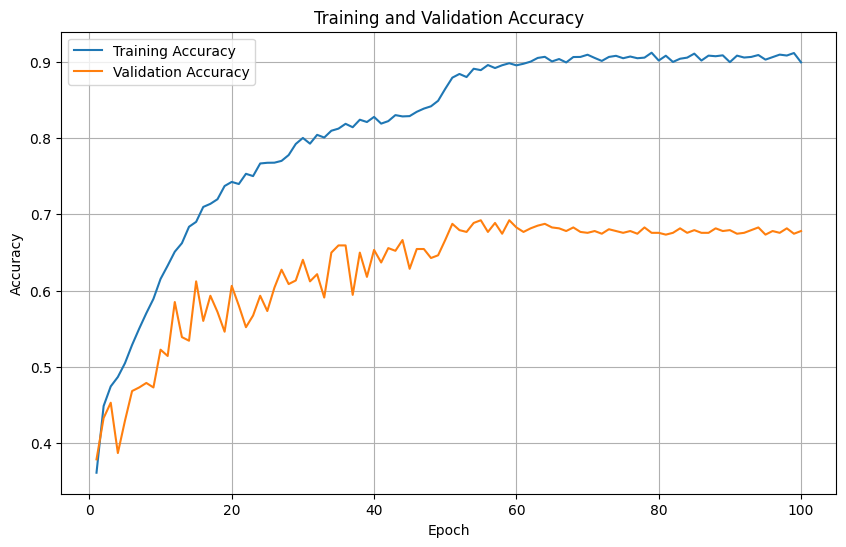

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Test Accuracy

In [ ]:
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Test acc: {:.3f}'.format(test_acc))

    end_time = time.time()

hours = (optim_end - start_time) // 3600
minutes = ((optim_end - start_time) % 3600) // 60
seconds = (optim_end - start_time) % 60

print(f'time to train hyperparameters: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

print(f'time to train model: \
{hours} hours, \
{minutes} minutes, \
{int(seconds)} seconds')

Test acc: 0.652
time to train hyperparameters: 0.0 hours, 39.0 minutes, 35 seconds
time to train model: 0.0 hours, 39.0 minutes, 35 seconds


# **ARCHIVE**

# CNN LSTM

In [ ]:
# given (200, 400, 22) <=> (batch_size, time_bins, channel)
class CNNLSTM(nn.Module):
  def __init__(self, num_classes):
    super(CNNLSTM, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=22, out_channels=25, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Dropout(0.6)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 22), stride=2),
        nn.ELU(),
        nn.BatchNorm2d(50),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.6)
    )

    self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=50, out_channels=100, kernel_size=5),
        nn.ELU(),
        nn.BatchNorm1d(100),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.6)
    )

    self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=5, stride=3),
        nn.ELU(),
        nn.BatchNorm1d(200),
        nn.MaxPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.6)
    )

    self.lstm = nn.LSTM(input_size=200, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3)
    self.dense = nn.Linear(in_features=128, out_features=num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = x.unsqueeze(2)
    x = self.conv2(x)
    x = x.squeeze(2)
    x = self.conv3(x)
    x = self.conv4(x)
    x = x.view(-1, 200)
    x, _ = self.lstm(x)
    x = self.dense(x)

    return F.log_softmax(x, dim=1)

In [ ]:
model = CNNLSTM(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [ ]:
train_accuracies = []
val_accuracies = []

for epoch_idx in range(num_epochs):
    print(f'EPOCH {epoch_idx}')
    model.train() # setting model to train mode because some models behave differently when in training or evaluation (think dropout)
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)

        logits = model(train_x)
        loss = criterion(logits, train_y) # loss function needs logits here (look at docs)

        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch

        # sometimes useful if you want to accumulate gradients across passes (in minibatch we dont want this)
        loss.backward() # do backwards pass
        optimizer.step() # take a step using gradients

        with torch.no_grad(): # stop gradients from being tracked (used when computing arbitrary statistics)
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count # getting accuracy measure

    model.eval() # puts the model in eval mode
    val_count = 0
    val_correct_count = 0
    with torch.no_grad(): # dont want gradients to be computed
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1) # choose most probable class in output
            #print(f"PRED: {y_hat}")
            #print(f"ACTUAL: {val_y}")
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_y.size(0)
    val_acc = val_correct_count / val_count

    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

EPOCH 0


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.35it/s]


Train acc: 0.254, Val acc: 0.230
EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.84it/s]


Train acc: 0.264, Val acc: 0.252
EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.92it/s]


Train acc: 0.285, Val acc: 0.285
EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.95it/s]


Train acc: 0.293, Val acc: 0.248
EPOCH 4


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.48it/s]


Train acc: 0.314, Val acc: 0.275
EPOCH 5


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.81it/s]


Train acc: 0.340, Val acc: 0.304
EPOCH 6


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.30it/s]


Train acc: 0.363, Val acc: 0.322
EPOCH 7


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 38.08it/s]


Train acc: 0.376, Val acc: 0.334
EPOCH 8


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.98it/s]


Train acc: 0.390, Val acc: 0.423
EPOCH 9


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.24it/s]


Train acc: 0.408, Val acc: 0.452
EPOCH 10


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.19it/s]


Train acc: 0.414, Val acc: 0.440
EPOCH 11


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.58it/s]


Train acc: 0.430, Val acc: 0.458
EPOCH 12


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.30it/s]


Train acc: 0.426, Val acc: 0.475
EPOCH 13


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.63it/s]


Train acc: 0.442, Val acc: 0.441
EPOCH 14


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.99it/s]


Train acc: 0.451, Val acc: 0.458
EPOCH 15


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.91it/s]


Train acc: 0.455, Val acc: 0.473
EPOCH 16


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.58it/s]


Train acc: 0.468, Val acc: 0.498
EPOCH 17


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.96it/s]


Train acc: 0.480, Val acc: 0.501
EPOCH 18


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.22it/s]


Train acc: 0.480, Val acc: 0.517
EPOCH 19


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.78it/s]


Train acc: 0.488, Val acc: 0.511
EPOCH 20


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.73it/s]


Train acc: 0.487, Val acc: 0.518
EPOCH 21


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.04it/s]


Train acc: 0.501, Val acc: 0.528
EPOCH 22


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.43it/s]


Train acc: 0.511, Val acc: 0.524
EPOCH 23


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.41it/s]


Train acc: 0.516, Val acc: 0.538
EPOCH 24


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.83it/s]


Train acc: 0.520, Val acc: 0.548
EPOCH 25


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.06it/s]


Train acc: 0.536, Val acc: 0.550
EPOCH 26


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.79it/s]


Train acc: 0.539, Val acc: 0.570
EPOCH 27


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.79it/s]


Train acc: 0.551, Val acc: 0.593
EPOCH 28


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.09it/s]


Train acc: 0.555, Val acc: 0.593
EPOCH 29


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.60it/s]


Train acc: 0.553, Val acc: 0.599
EPOCH 30


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.41it/s]


Train acc: 0.558, Val acc: 0.612
EPOCH 31


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.93it/s]


Train acc: 0.569, Val acc: 0.603
EPOCH 32


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.30it/s]


Train acc: 0.568, Val acc: 0.606
EPOCH 33


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.72it/s]


Train acc: 0.570, Val acc: 0.623
EPOCH 34


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.49it/s]


Train acc: 0.574, Val acc: 0.627
EPOCH 35


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.04it/s]


Train acc: 0.585, Val acc: 0.613
EPOCH 36


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.92it/s]


Train acc: 0.583, Val acc: 0.627
EPOCH 37


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.01it/s]


Train acc: 0.584, Val acc: 0.632
EPOCH 38


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.44it/s]


Train acc: 0.590, Val acc: 0.644
EPOCH 39


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.44it/s]


Train acc: 0.593, Val acc: 0.640
EPOCH 40


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.32it/s]


Train acc: 0.601, Val acc: 0.640
EPOCH 41


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.11it/s]


Train acc: 0.589, Val acc: 0.660
EPOCH 42


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.18it/s]


Train acc: 0.600, Val acc: 0.640
EPOCH 43


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.91it/s]


Train acc: 0.604, Val acc: 0.633
EPOCH 44


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.90it/s]


Train acc: 0.608, Val acc: 0.652
EPOCH 45


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.24it/s]


Train acc: 0.610, Val acc: 0.645
EPOCH 46


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.26it/s]


Train acc: 0.614, Val acc: 0.654
EPOCH 47


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.49it/s]


Train acc: 0.621, Val acc: 0.642
EPOCH 48


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.47it/s]


Train acc: 0.613, Val acc: 0.647
EPOCH 49


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.34it/s]


Train acc: 0.622, Val acc: 0.647
EPOCH 50


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.99it/s]


Train acc: 0.621, Val acc: 0.666
EPOCH 51


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.67it/s]


Train acc: 0.625, Val acc: 0.663
EPOCH 52


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.76it/s]


Train acc: 0.627, Val acc: 0.656
EPOCH 53


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.89it/s]


Train acc: 0.631, Val acc: 0.667
EPOCH 54


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.96it/s]


Train acc: 0.625, Val acc: 0.652
EPOCH 55


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.25it/s]


Train acc: 0.640, Val acc: 0.678
EPOCH 56


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.13it/s]


Train acc: 0.637, Val acc: 0.675
EPOCH 57


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.73it/s]


Train acc: 0.644, Val acc: 0.673
EPOCH 58


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.48it/s]


Train acc: 0.640, Val acc: 0.676
EPOCH 59


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.90it/s]


Train acc: 0.635, Val acc: 0.675
EPOCH 60


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.42it/s]


Train acc: 0.644, Val acc: 0.682
EPOCH 61


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.45it/s]


Train acc: 0.646, Val acc: 0.683
EPOCH 62


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.76it/s]


Train acc: 0.645, Val acc: 0.690
EPOCH 63


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.24it/s]


Train acc: 0.664, Val acc: 0.686
EPOCH 64


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.59it/s]


Train acc: 0.652, Val acc: 0.672
EPOCH 65


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.59it/s]


Train acc: 0.650, Val acc: 0.673
EPOCH 66


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.21it/s]


Train acc: 0.658, Val acc: 0.678
EPOCH 67


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.80it/s]


Train acc: 0.653, Val acc: 0.673
EPOCH 68


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.03it/s]


Train acc: 0.657, Val acc: 0.696
EPOCH 69


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.71it/s]


Train acc: 0.669, Val acc: 0.677
EPOCH 70


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.69it/s]


Train acc: 0.656, Val acc: 0.677
EPOCH 71


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.14it/s]


Train acc: 0.667, Val acc: 0.682
EPOCH 72


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.53it/s]


Train acc: 0.667, Val acc: 0.683
EPOCH 73


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.81it/s]


Train acc: 0.664, Val acc: 0.685
EPOCH 74


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.94it/s]


Train acc: 0.666, Val acc: 0.678
EPOCH 75


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.23it/s]


Train acc: 0.674, Val acc: 0.683
EPOCH 76


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.48it/s]


Train acc: 0.678, Val acc: 0.675
EPOCH 77


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.68it/s]


Train acc: 0.683, Val acc: 0.691
EPOCH 78


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.20it/s]


Train acc: 0.681, Val acc: 0.706
EPOCH 79


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.93it/s]


Train acc: 0.677, Val acc: 0.686
EPOCH 80


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.04it/s]


Train acc: 0.682, Val acc: 0.690
EPOCH 81


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.18it/s]


Train acc: 0.673, Val acc: 0.678
EPOCH 82


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.71it/s]


Train acc: 0.681, Val acc: 0.691
EPOCH 83


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.75it/s]


Train acc: 0.679, Val acc: 0.683
EPOCH 84


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.65it/s]


Train acc: 0.687, Val acc: 0.692
EPOCH 85


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.85it/s]


Train acc: 0.686, Val acc: 0.689
EPOCH 86


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.36it/s]


Train acc: 0.681, Val acc: 0.691
EPOCH 87


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.65it/s]


Train acc: 0.685, Val acc: 0.684
EPOCH 88


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.61it/s]


Train acc: 0.687, Val acc: 0.680
EPOCH 89


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.07it/s]


Train acc: 0.692, Val acc: 0.699
EPOCH 90


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.24it/s]


Train acc: 0.699, Val acc: 0.669
EPOCH 91


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.61it/s]


Train acc: 0.693, Val acc: 0.688
EPOCH 92


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.55it/s]


Train acc: 0.691, Val acc: 0.688
EPOCH 93


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.83it/s]


Train acc: 0.693, Val acc: 0.680
EPOCH 94


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.76it/s]


Train acc: 0.695, Val acc: 0.695
EPOCH 95


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.89it/s]


Train acc: 0.698, Val acc: 0.671
EPOCH 96


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.77it/s]


Train acc: 0.706, Val acc: 0.683
EPOCH 97


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.60it/s]


Train acc: 0.697, Val acc: 0.679
EPOCH 98


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.29it/s]


Train acc: 0.695, Val acc: 0.700
EPOCH 99


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.42it/s]


Train acc: 0.709, Val acc: 0.684


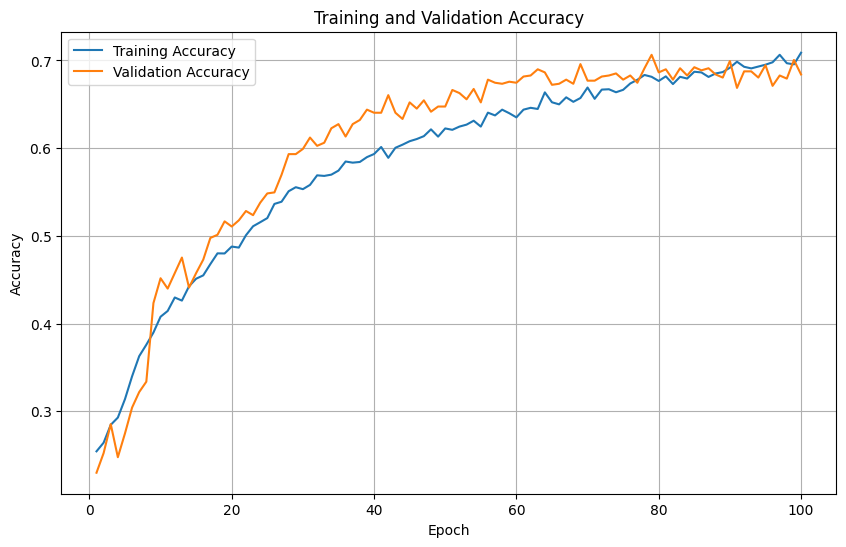

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Test acc: {:.3f}'.format(test_acc))

Test acc: 0.655


# Some bullshit 4 Layer CNN I brute-forced. (hit 60% once)

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=22, out_channels=25, kernel_size=4, stride=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=1),
        nn.BatchNorm1d(25),
        nn.Dropout(0.5)
    )

    self.conv2 = nn.Sequential(
        nn.Conv1d(in_channels=25, out_channels=50, kernel_size=4, stride=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=1),
        nn.BatchNorm1d(50),
        nn.Dropout(0.3)
    )

    self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=50, out_channels=100, kernel_size=4, stride=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=1),
        nn.BatchNorm1d(100),
        nn.Dropout(0.3)
    )

    self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=4, stride=3, padding=1),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=3, stride=1),
        nn.BatchNorm1d(200),
        nn.Dropout(0.3)
    )

    self.fc1 = nn.Linear(in_features=1800, out_features=900)
    self.fc2 = nn.Linear(in_features=900, out_features=256)
    self.z = nn.Linear(in_features=256, out_features=4)
    self.dropout = nn.Dropout(0.4)

  def forward(self, x):
    x = self.conv1(x.transpose(1, 2))
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)

    x = x.view(x.size(0), - 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.z(x)

    return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes) #  * sequence_length

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out =self.fc(out[:, -1, :])
        return out

# CNN that took fucking ages to get right.

In [ ]:
# given (200, 22, 400) <=> (batch_size, channels, time_bins)
class CNN(nn.Module):
  def __init__(self, num_classes):
    super(CNN, self).__init__()

    # first block: convolve over time with kernel size 3.
    # out_channels: 25
    # activation: ReLU
    # uses standard dropout of 0.5
    self.conv1 = nn.Sequential(
        nn.Conv1d(in_channels=22, out_channels=25, kernel_size=10),
        nn.ReLU(),
        nn.BatchNorm1d(25),
        nn.Dropout(0.5)
    )

    # second block: convolve over space with kernel size (1, 22) to match dims.
    #               and a stride of 2.
    # out_channels: 25 * 2 = 50
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=25, out_channels=50, kernel_size=(1, 22), stride=2),
        nn.ELU(),
        nn.BatchNorm2d(50),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # third block: convolve over time with kernel size 5.
    #               and a stride of 2.
    # out_channels: 50 * 2 = 100
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv3 = nn.Sequential(
        nn.Conv1d(in_channels=50, out_channels=100, kernel_size=5),
        nn.ELU(),
        nn.BatchNorm1d(100),
        nn.AvgPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # fourth block: convolve over time with kernel size 5 and a stride of 3.
    # out_channels: 100 * 2 = 200
    # activation: ELU
    # pooling: Mean pooling with kernel size (1, 3)
    # uses standard dropout of 0.5
    self.conv4 = nn.Sequential(
        nn.Conv1d(in_channels=100, out_channels=200, kernel_size=5, stride=3),
        nn.ELU(),
        nn.BatchNorm1d(200),
        nn.MaxPool2d(kernel_size=(1, 3)),
        nn.Dropout(0.5)
    )

    # dense block: fully-connected affine layer
    self.dense = nn.Linear(in_features=200, out_features=num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = x.unsqueeze(2)      # match dims for Conv2d().
    x = self.conv2(x)
    x = x.squeeze(2)        # match dims for Conv1d().
    x = self.conv3(x)
    x = self.conv4(x)
    x = torch.flatten(x, 1) # match dims for affine.
    x = self.dense(x)

    return F.log_softmax(x, dim=1)


In [ ]:
model = CNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=5e-3)

In [ ]:
train_accuracies = []
val_accuracies = []

for epoch_idx in range(num_epochs):
    print(f'EPOCH {epoch_idx}')
    model.train() # setting model to train mode because some models behave differently when in training or evaluation (think dropout)
    train_count = 0
    train_correct_count = 0
    for batch_idx, (train_x, train_y) in enumerate(tqdm(train_loader)):
        train_x = train_x.float().to(device)
        train_y = train_y.long().to(device)

        # print(train_x.shape)
        logits = model(train_x)
        # print(logits.shape)
        loss = criterion(logits, train_y) # loss function needs logits here (look at docs)

        optimizer.zero_grad() # Zero gradients, since we don't want gradients to accumulate between batches - we apply an update for each batch
        # sometimes useful if you want to accumulate gradients across passes (in minibatch we dont want this)
        loss.backward() # do backwards pass
        optimizer.step() # take a step using gradients

        with torch.no_grad(): # stop gradients from being tracked (used when computing arbitrary statistics)
            y_hat = torch.argmax(logits, dim=-1)
            train_correct_count += torch.sum(y_hat == train_y, axis=-1)
            train_count += train_x.size(0)

    train_acc = train_correct_count / train_count # getting accuracy measure

    model.eval() # puts the model in eval mode
    val_count = 0
    val_correct_count = 0
    with torch.no_grad(): # dont want gradients to be computed
        for idx, (val_x, val_y) in enumerate(val_loader):
            val_x = val_x.float().to(device)
            val_y = val_y.long().to(device)
            logits = model(val_x).detach()
            y_hat = torch.argmax(logits, dim=-1) # choose most probable class in output
            #print(f"PRED: {y_hat}")
            #print(f"ACTUAL: {val_y}")
            val_correct_count += torch.sum(y_hat == val_y, axis=-1)
            val_count += val_y.size(0)
    val_acc = val_correct_count / val_count

    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    print('Train acc: {:.3f}, Val acc: {:.3f}'.format(train_acc, val_acc))

EPOCH 0


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.18it/s]


Train acc: 0.302, Val acc: 0.425
EPOCH 1


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.84it/s]


Train acc: 0.417, Val acc: 0.547
EPOCH 2


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 51.22it/s]


Train acc: 0.491, Val acc: 0.547
EPOCH 3


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.25it/s]


Train acc: 0.542, Val acc: 0.482
EPOCH 4


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.96it/s]


Train acc: 0.565, Val acc: 0.515
EPOCH 5


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.71it/s]


Train acc: 0.584, Val acc: 0.412
EPOCH 6


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.28it/s]


Train acc: 0.608, Val acc: 0.519
EPOCH 7


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.59it/s]


Train acc: 0.626, Val acc: 0.501
EPOCH 8


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.35it/s]


Train acc: 0.639, Val acc: 0.620
EPOCH 9


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.10it/s]


Train acc: 0.654, Val acc: 0.454
EPOCH 10


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.44it/s]


Train acc: 0.666, Val acc: 0.502
EPOCH 11


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.59it/s]


Train acc: 0.676, Val acc: 0.659
EPOCH 12


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.17it/s]


Train acc: 0.695, Val acc: 0.596
EPOCH 13


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 52.62it/s]


Train acc: 0.691, Val acc: 0.354
EPOCH 14


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.31it/s]


Train acc: 0.687, Val acc: 0.515
EPOCH 15


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.12it/s]


Train acc: 0.702, Val acc: 0.542
EPOCH 16


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.86it/s]


Train acc: 0.712, Val acc: 0.612
EPOCH 17


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.30it/s]


Train acc: 0.722, Val acc: 0.545
EPOCH 18


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.68it/s]


Train acc: 0.720, Val acc: 0.684
EPOCH 19


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.40it/s]


Train acc: 0.740, Val acc: 0.624
EPOCH 20


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.37it/s]


Train acc: 0.726, Val acc: 0.590
EPOCH 21


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.23it/s]


Train acc: 0.733, Val acc: 0.645
EPOCH 22


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.05it/s]


Train acc: 0.744, Val acc: 0.566
EPOCH 23


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.00it/s]


Train acc: 0.739, Val acc: 0.402
EPOCH 24


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.21it/s]


Train acc: 0.745, Val acc: 0.580
EPOCH 25


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.10it/s]


Train acc: 0.747, Val acc: 0.623
EPOCH 26


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.19it/s]


Train acc: 0.766, Val acc: 0.517
EPOCH 27


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.72it/s]


Train acc: 0.767, Val acc: 0.620
EPOCH 28


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.768, Val acc: 0.494
EPOCH 29


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 52.39it/s]


Train acc: 0.762, Val acc: 0.527
EPOCH 30


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.10it/s]


Train acc: 0.748, Val acc: 0.618
EPOCH 31


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 50.43it/s]


Train acc: 0.767, Val acc: 0.519
EPOCH 32


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.90it/s]


Train acc: 0.764, Val acc: 0.521
EPOCH 33


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.90it/s]


Train acc: 0.782, Val acc: 0.678
EPOCH 34


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.85it/s]


Train acc: 0.791, Val acc: 0.505
EPOCH 35


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.90it/s]


Train acc: 0.770, Val acc: 0.552
EPOCH 36


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.34it/s]


Train acc: 0.783, Val acc: 0.502
EPOCH 37


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.43it/s]


Train acc: 0.783, Val acc: 0.529
EPOCH 38


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.45it/s]


Train acc: 0.782, Val acc: 0.442
EPOCH 39


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.64it/s]


Train acc: 0.764, Val acc: 0.657
EPOCH 40


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 53.80it/s]


Train acc: 0.799, Val acc: 0.656
EPOCH 41


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.42it/s]


Train acc: 0.804, Val acc: 0.646
EPOCH 42


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.63it/s]


Train acc: 0.801, Val acc: 0.630
EPOCH 43


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.66it/s]


Train acc: 0.804, Val acc: 0.616
EPOCH 44


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.56it/s]


Train acc: 0.807, Val acc: 0.554
EPOCH 45


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.81it/s]


Train acc: 0.801, Val acc: 0.518
EPOCH 46


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.85it/s]


Train acc: 0.807, Val acc: 0.650
EPOCH 47


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.92it/s]


Train acc: 0.808, Val acc: 0.456
EPOCH 48


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 49.03it/s]


Train acc: 0.739, Val acc: 0.631
EPOCH 49


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.65it/s]


Train acc: 0.794, Val acc: 0.658
EPOCH 50


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.71it/s]


Train acc: 0.809, Val acc: 0.639
EPOCH 51


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.57it/s]


Train acc: 0.808, Val acc: 0.624
EPOCH 52


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.58it/s]


Train acc: 0.810, Val acc: 0.620
EPOCH 53


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.91it/s]


Train acc: 0.813, Val acc: 0.548
EPOCH 54


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.27it/s]


Train acc: 0.805, Val acc: 0.488
EPOCH 55


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.91it/s]


Train acc: 0.811, Val acc: 0.664
EPOCH 56


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.76it/s]


Train acc: 0.820, Val acc: 0.675
EPOCH 57


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.10it/s]


Train acc: 0.823, Val acc: 0.538
EPOCH 58


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.11it/s]


Train acc: 0.816, Val acc: 0.699
EPOCH 59


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 59.75it/s]


Train acc: 0.824, Val acc: 0.593
EPOCH 60


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.79it/s]


Train acc: 0.810, Val acc: 0.665
EPOCH 61


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.15it/s]


Train acc: 0.825, Val acc: 0.564
EPOCH 62


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.57it/s]


Train acc: 0.814, Val acc: 0.581
EPOCH 63


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.37it/s]


Train acc: 0.816, Val acc: 0.637
EPOCH 64


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.12it/s]


Train acc: 0.814, Val acc: 0.644
EPOCH 65


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.65it/s]


Train acc: 0.819, Val acc: 0.617
EPOCH 66


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.83it/s]


Train acc: 0.823, Val acc: 0.657
EPOCH 67


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.18it/s]


Train acc: 0.816, Val acc: 0.532
EPOCH 68


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.36it/s]


Train acc: 0.807, Val acc: 0.554
EPOCH 69


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.73it/s]


Train acc: 0.815, Val acc: 0.567
EPOCH 70


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.816, Val acc: 0.670
EPOCH 71


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.08it/s]


Train acc: 0.840, Val acc: 0.587
EPOCH 72


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.13it/s]


Train acc: 0.832, Val acc: 0.584
EPOCH 73


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.91it/s]


Train acc: 0.828, Val acc: 0.686
EPOCH 74


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.14it/s]


Train acc: 0.847, Val acc: 0.665
EPOCH 75


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.24it/s]


Train acc: 0.830, Val acc: 0.637
EPOCH 76


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.05it/s]


Train acc: 0.824, Val acc: 0.593
EPOCH 77


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.59it/s]


Train acc: 0.837, Val acc: 0.642
EPOCH 78


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.93it/s]


Train acc: 0.830, Val acc: 0.665
EPOCH 79


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.73it/s]


Train acc: 0.838, Val acc: 0.688
EPOCH 80


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.06it/s]


Train acc: 0.832, Val acc: 0.526
EPOCH 81


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.43it/s]


Train acc: 0.827, Val acc: 0.676
EPOCH 82


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.48it/s]


Train acc: 0.837, Val acc: 0.656
EPOCH 83


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.11it/s]


Train acc: 0.845, Val acc: 0.700
EPOCH 84


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.65it/s]


Train acc: 0.843, Val acc: 0.673
EPOCH 85


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.71it/s]


Train acc: 0.839, Val acc: 0.607
EPOCH 86


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.75it/s]


Train acc: 0.842, Val acc: 0.685
EPOCH 87


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 55.41it/s]


Train acc: 0.840, Val acc: 0.550
EPOCH 88


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 50.91it/s]


Train acc: 0.806, Val acc: 0.645
EPOCH 89


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 54.62it/s]


Train acc: 0.838, Val acc: 0.669
EPOCH 90


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.70it/s]


Train acc: 0.841, Val acc: 0.676
EPOCH 91


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.41it/s]


Train acc: 0.846, Val acc: 0.624
EPOCH 92


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.91it/s]


Train acc: 0.836, Val acc: 0.682
EPOCH 93


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.26it/s]


Train acc: 0.837, Val acc: 0.478
EPOCH 94


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.12it/s]


Train acc: 0.805, Val acc: 0.640
EPOCH 95


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 56.34it/s]


Train acc: 0.833, Val acc: 0.692
EPOCH 96


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.96it/s]


Train acc: 0.843, Val acc: 0.682
EPOCH 97


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 57.73it/s]


Train acc: 0.844, Val acc: 0.690
EPOCH 98


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.59it/s]


Train acc: 0.846, Val acc: 0.676
EPOCH 99


100%|████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 58.13it/s]

Train acc: 0.845, Val acc: 0.716


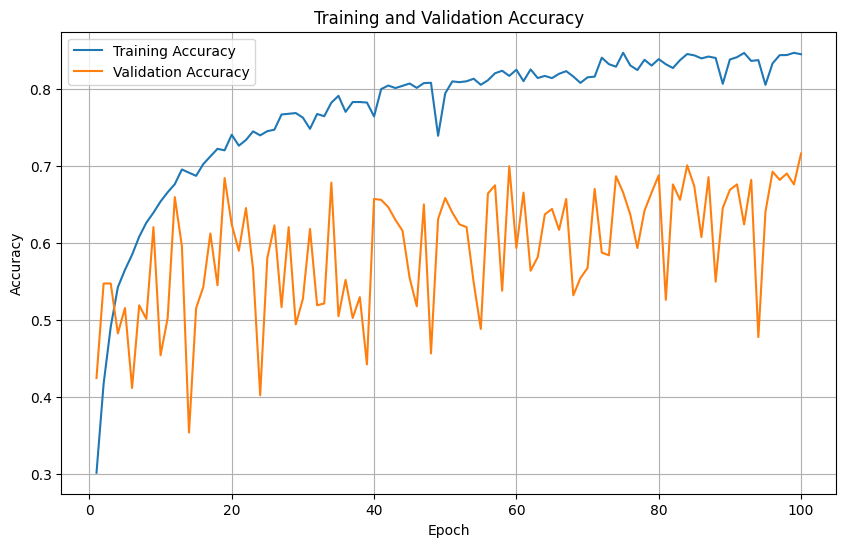

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    test_count = 0
    test_correct_count = 0
    for idx, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.float().to(device)
        test_y = test_y.long().to(device)
        logits = model(test_x).detach()
        y_hat = torch.argmax(logits, dim=-1)
        test_correct_count += torch.sum(y_hat == test_y, axis=-1)
        test_count += test_x.size(0)
    test_acc = test_correct_count / test_count
    print('Test acc: {:.3f}'.format(test_acc))

Test acc: 0.713
